
# RNN Dead Layer Fit Project

## Abigail Alexander, Aobo Li


## Plan:

1) Generating MC spectrums with different [FCCD Width, Dead Layer Ratio, transfer function], normalize them to contain the same number of events -> Done

2) Randomly pull out 2 MC spectrum(MC1 and MC2) and subtract them to obtain MCdiff = (MC1-MC2)

3) Feed MCdiff into RNN and train to answer questions: is FCCD Width of MC1>MC2? is dead layer ration of MC1>MC2? etc.
    
    - RNN: https://github.com/legend-exp/gem/blob/master/NetworkPSA/NetworkPSA_RNN.ipynb

4) Use the traditional peak-fitting technology you and Valentina developed, this will give you a MC spectrum given certain dead layer parameters, let’s call it MCbest

5) Calculate a new difference by doing MC_newdiff = Data-MCbest, then feeding MC_newdiff into the trained RNN. RNN will tell you if the [FCCD width, dead layer ratio,…] in MCbest is too low/too high.

6) Looking at the attention score, this will tell you which part of the spectrum the network has used to make the decision.

7) Trying to understand why a too low/too high FCCD width would have that kind of effect on that part of the spectrum, is it because of the MC simulation? transfer function? etc.

# ---------------------------------------------
# CLASSES AND FUNCTIONS
# ---------------------------------------------

# Import packages

In [1]:
#check env
import os
print (os.environ['CONDA_DEFAULT_ENV'])

/unix/legend/abi/ML_DL/MLenv


In [2]:
#General
import sys
import json
import yaml
import pandas as pd

#RNN imports
import numpy as np
import os
import argparse
import time
import math
import random
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import gzip
import pickle
import numpy as np
from torch.autograd import Variable
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsnooper #problem installing: !pip install torchsnooper --user #this worked for installing torchsnooper
import h5py
import re
from tqdm import tqdm
from torch.cuda.amp import autocast

torch.cuda.empty_cache()


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cuda:0")
print(DEVICE)

/unix/legend/abi/ML_DL/MLenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [3]:
torch.cuda.is_available()

True

## Get relevant paths

In [43]:
# Data paths:
CodePath = os.path.dirname(os.path.abspath("__file__"))
FCCD_DLF_list_path = CodePath+"/data/V05268A_data/1000random_FCCDs_DLFs.json"
DATA_PATH = CodePath+"/data/V05268A_data/data_hist_Ba_V05268A.h5"
MC_PATH = CodePath+"/data/V05268A_data/training_data_V05268A/"


print(MC_PATH)

/unix/legend/abi/ML_DL/data/V05268A_data/training_data_V05268A/


# Generating Pytorch data set for training

In [44]:
class DL_Dataset(Dataset):

    def __init__(self, path = MC_PATH, restrict_dataset = False, restrict_dict = None):
        
        self.event_dict = {}
        count = 0
        # Loop through all the files
        for filename in os.listdir(path):
            if count > 111111:
                break
            count += 1

            m = re.search('FCCD(.+?)mm_DLF', filename)
            n = re.search('DLF(.+?)_frac', filename)
            a = (float(m.group(1)),float(n.group(1)))
        
            if a:
                self.event_dict[a] = os.path.join(path, filename)

                                 
        self.event_list = list(self.event_dict.keys()) #list of [FCCD, DLF]
        self.size = len(self.event_list)
                                                                  
        self.hist_length = 900 #Energy Spectrum # of bins #binning: 0.5 keV bins from 0-450 keV:
        self.energy_bin = np.linspace(0,450.0,self.hist_length+1) # Only look at events between 0 and 450 keV
        
        self.scaler = self.build_scaler() #performs a ~normalisation on each bin so that they are all significant
        
        self.restrict_dataset = restrict_dataset
        self.restrict_dict = restrict_dict
        
        
    def __len__(self):
        return self.size
    
    def get_histlen(self):
        return self.hist_length

    
    # This function applies standard scaler to each spectrum, converting them in to 0-centered with 1 standard deviation.
    def build_scaler(self):
        hist_array = []
        for i in tqdm(range(self.size)):
                        
            FCCD, DLF = self.event_list[i][0], self.event_list[i][1]
            dead_layer_address = self.event_dict[(FCCD, DLF)]
            hist_array.append(self.get_hist_magnitude(dead_layer_address).reshape(1,-1))
            
        hist_array = np.concatenate(hist_array,axis=0)
        
        print(hist_array.shape)
        scaler = StandardScaler()
        scaler.fit(hist_array)
        return scaler
    
    
    # This get the energy spectrum of each file
    def get_hist_magnitude(self,h5_address,MC=True):
        
        df =  pd.read_hdf(h5_address, key="energy_hist")
        counts = df[0].to_numpy()
        bins = self.energy_bin #size 901, 0-450keV 0.5keV width
          
        if MC == True: #data doesnt need normalising, only MC
            counts = self.normalise_MC_counts(counts) 
        
        return counts
    
    def normalise_MC_counts(self, counts):
        
        #normalise MC to data`
        data_time = 30*60 #30 mins, 30*60s
        Ba133_activity = 116.1*10**3 #Bq
        data_evts = data_time*Ba133_activity
        MC_evts = 10**8
        MC_solidangle_fraction = 1/6 #30 degrees solid angle in MC
        scaling = MC_evts/MC_solidangle_fraction/data_evts
        
        counts_normalised = counts/scaling
        
        return counts_normalised
        

    def __getitem__(self, idx):
        #1st spectra read idx, 2nd spectra is random, then compute difference
        
        #1st spectrum
        FCCD, DLF = self.event_list[idx][0], self.event_list[idx][1]
        dead_layer_address = self.event_dict[(FCCD, DLF)]
        spectrum_original = self.get_hist_magnitude(dead_layer_address)
        spectrum = self.scaler.transform(self.get_hist_magnitude(dead_layer_address).reshape(1,-1))
        
        #2nd spectrum
        idx2 = np.random.randint(self.size)
        while idx2 == idx:
            idx2 = np.random.randint(self.size) #ensures we dont have same ind
        FCCD2, DLF2 = self.event_list[idx2][0], self.event_list[idx2][1]
        FCCD_diff, DLF_diff = FCCD-FCCD2, DLF - DLF2
        
        #for restricted datasets, ensure FCCDdiff and DLFdiff satisfy given restriction
        if self.restrict_dataset == True: 
            while abs(FCCD_diff) > self.restrict_dict["maxFCCDdiff"] or abs(DLF_diff) > self.restrict_dict["maxDLFdiff"]:
                idx2 = np.random.randint(self.size)
                while idx2 == idx:
                    idx2 = np.random.randint(self.size) #ensures we dont have same ind
                FCCD2, DLF2 = self.event_list[idx2][0], self.event_list[idx2][1]
                FCCD_diff, DLF_diff = FCCD-FCCD2, DLF - DLF2
        
        dead_layer_address2 = self.event_dict[(FCCD2, DLF2)]
        spectrum2 = self.scaler.transform(self.get_hist_magnitude(dead_layer_address2).reshape(1,-1))
        
        
        #compute difference and make binary label
        if FCCD_diff >=0:
            FCCD_diff_label = 1
        else:
            FCCD_diff_label = 0
        if DLF_diff >=0:
            DLF_diff_label = 1
        else:
            DLF_diff_label = 0
            
        spectrum_diff = spectrum - spectrum2
        
        #extras = info needed to investigate specific trials
        extras = {"FCCD1": FCCD, "FCCD2": FCCD2, "FCCD_diff": FCCD_diff, "DLF1": DLF, "DLF2": DLF2, "DLF_diff": DLF_diff}
        
        return spectrum_diff, FCCD_diff_label, DLF_diff_label, extras, spectrum_original
    
        
    def get_data(self):
        return self.scaler.transform(self.get_hist_magnitude(DATA_PATH, MC=False).reshape(1,-1))
    
    def get_hist_range(self):
        return self.energy_bin
    
    def get_scaler(self):
        return self.scaler

In [45]:
#Load dataset
def load_data(batch_size, restrict_dataset = False, restrict_dict = None):
    
    if restrict_dataset == True and restrict_dict is None:
        print("You must use kwarg restrict_dict in order to restrict dataset")
        return 0

    dataset = DL_Dataset(restrict_dataset = restrict_dataset, restrict_dict=restrict_dict)
    validation_split = .3 #Split data set into training & testing with 7:3 ratio
    shuffle_dataset = True
    random_seed= 42222

    dataset_size = int(len(dataset))
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = data_utils.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=batch_size,sampler=valid_sampler,  drop_last=True)

    return train_loader,test_loader, dataset

# The RNN Model

In [7]:
#The fully connected part of neural network

#try increasing no of linear layers, from 2 to >2
#try increasing dropout rate

class FCNet(nn.Module):
    def __init__(self, first_unit, last_unit):
        super(FCNet, self).__init__()
        
        #Number of channels in each fully connected layers
        fc1, fc2 = (first_unit, int(first_unit*0.25))
        do = 0.2
        self.fcnet = nn.Sequential(
            torch.nn.Linear(fc1, fc2),
            torch.nn.BatchNorm1d(fc2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(do),
#             torch.nn.Linear(fc2, fc3),
#             torch.nn.LeakyReLU(),
#             torch.nn.Dropout(do),
#             torch.nn.Linear(fc3, fc4),
#             torch.nn.LeakyReLU(),
#             torch.nn.Dropout(do),
            torch.nn.Linear(fc2, last_unit),
        )
    def forward(self, x):
        return self.fcnet(x)

In [8]:
#The RNN based model:
class RNN(nn.Module):
    def __init__(self,histlen,num_class, get_attention = False):
        super(RNN, self).__init__()
        
        bidirec = True
        self.bidirec = bidirec
        feed_in_dim = 512
        self.seg = 1
        self.seq_len = histlen // self.seg
        if bidirec:
            self.RNNLayer = torch.nn.GRU(input_size = self.seg, hidden_size = feed_in_dim//2,num_layers=2, batch_first=True,bidirectional=True,dropout=0.2)
            feed_in_dim *= 2
        else:
            self.RNNLayer = torch.nn.GRU(input_size = self.seg, hidden_size = feed_in_dim//2,num_layers=2, batch_first=True,bidirectional=False,dropout=0.2)
        self.fcnet = FCNet(feed_in_dim,2) #only 2 classes/decisions to make: FCCD1>FCCD2 and DLF1>DLF2
        self.attention_weight = nn.Linear(feed_in_dim//2, feed_in_dim//2, bias=False)
        self.get_attention = get_attention

#   @torchsnooper.snoop() #uncomment for troubleshooting if training fails
    def forward(self, x):
        x = x.view(-1,self.seq_len,self.seg)
        bsize = x.size(0)
        output, hidden = self.RNNLayer(x)
        if self.bidirec:
            hidden =  hidden[-2:]
            hidden = hidden.transpose(0,1).reshape(bsize,-1)
        else:
            hidden =  hidden[-1]
        
        
        #Attention Mechanism
        # output = output.permute(0,2,1) #[batch, seq_len, channel] -> [batch, channel, seq_len]
        hidden_attention = hidden.unsqueeze(-1) #[batch, channel]
        w_attention = self.attention_weight(output) # [batch, seq_len, channel] * [channel, channel] -> [batch, seq_len, channel]
        w_attention = torch.einsum("ijl,ilm->ijm",w_attention,hidden_attention).squeeze(-1)   # [batch, seq_len, channel] * [batch, channel] -> [batch, seq_len]
        attention_score = torch.softmax(w_attention,dim=-1) #Softmax over seq_len dimension
        if self.get_attention:
            return attention_score
        
        context = torch.sum(attention_score.unsqueeze(-1).expand(*output.size()) * output,dim=1) #Sum over seq_len dimension with attention score multiplied to output
        x = self.fcnet(torch.cat([context,hidden],dim=-1)) #concatenate context vector with last hidden state output
        x = torch.sigmoid(x) #forces NNoutput to be 0-1, means we can use BCE loss function and not BCEwithlogitloss
        # assert 0
        return x
    
    
    


# TRAINING FUNCTIONS

In [9]:
def train_RNN(train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, fulldataset=True, saveRNN=False, plot_training_results = False, RNN_ID = None):
    "function to create and train the RNN from a given dataset (test and train loader)"
    
    if RNN_ID is None and saveRNN==True:
        print("You must set RNN_ID to save RNN!")
        sys.exit()
        
    
    #Define RNN classifier
    RNNclassifier = RNN(dataset.get_histlen(),2) #only 2 classes
    RNNclassifier.to(DEVICE)

    print("#params", sum(x.numel() for x in RNNclassifier.parameters()))


    # Define categorical cross entropy loss
    RNNcriterion = torch.nn.BCELoss() #use binary cross entropy loss: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
    RNNcriterion = RNNcriterion.to(DEVICE)

    # Use lower learning rate at the first 400 iteration to "warm up" the attention mechanism
    warmup_size = 400
    print("Warmup Size: %d"%(warmup_size))
    lmbda = lambda epoch: min((epoch+1)**-0.5, (epoch+1)*warmup_size**-1.5)
    RNNoptimizer = torch.optim.AdamW(RNNclassifier.parameters(),lr=LEARNING_RATE, betas=(0.9, 0.98),eps=1e-9) #can change optimiser - read pytorch different optimisers

    scheduler = torch.optim.lr_scheduler.LambdaLR(RNNoptimizer, lr_lambda=lmbda)

    FCCD_accuracy_values, DLF_accuracy_values = [], []
    loss_values = []

    print("- - - - - - - - - - -")
    for epoch in range(NUM_EPOCHS):
        print("")
        print("EPOCH: ", epoch+1, "/",NUM_EPOCHS)
        print("Training network...")
        for i, (spectrum_diff, FCCDLabel, DLFLabel, extras, spectrum) in enumerate(train_loader):

            #RNN in train mode
            RNNclassifier.train() 

            #Send inputs and labels to DEVICE
            spectrum_diff = spectrum_diff.to(DEVICE).float()
            FCCDLabel = FCCDLabel.to(DEVICE).float() #(batch_size,)
            DLFLabel = DLFLabel.to(DEVICE).float() #(batch_size,)
            concat_labels = torch.stack([FCCDLabel, DLFLabel], dim=1) # (batch_size, 2)

            #Train RNN Classifier
            RNNoutputs  = RNNclassifier(spectrum_diff) #(batch_size, 2) 

            #Calculate Loss
            RNNloss = RNNcriterion(RNNoutputs, concat_labels)

            #Back-propagate Loss
            RNNloss.backward()

            # Perform gradient descent to update parameters
            RNNoptimizer.step()        # update parameters of net
            RNNoptimizer.zero_grad()   # reset gradient to 0

            scheduler.step()

            print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
                epoch+1, NUM_EPOCHS, i+1, len(train_loader),
                RNNloss.item(), end=""),end="")

        loss_values.append(RNNloss.item())

        print("")

        #================================================================================================

        RNNclassifier.eval() #RNN in evaluate mode



        # Plots per epoch
        fig, (ax_FCCD, ax_DLF) = plt.subplots(1, 2, figsize=(12,4))
        FCCD_labels_all = []
        FCCD_RNNoutputs_all = []
        FCCD_RNNoutputs_1 = [] #outputs where input label is 1
        FCCD_RNNoutputs_0 = [] #outputs where input label is 0

        DLF_labels_all = []
        DLF_RNNoutputs_all = []
        DLF_RNNoutputs_1 = [] #outputs where input label is 1
        DLF_RNNoutputs_0 = [] #outputs where input label is 0


        print("Testing/Validating...")
        for spectrum_diff, FCCDLabel, DLFLabel, extras, spectrum in tqdm(test_loader): 

            RNNclassifier.eval()
            labels = torch.stack([FCCDLabel, DLFLabel], dim=1) # (batch_size, 2)
            lb_data_in = labels.cpu().data.numpy()

            with torch.no_grad():
                spectrum_diff = spectrum_diff.to(DEVICE).float()
                outputs = RNNclassifier(spectrum_diff)
                outputs = outputs.cpu().data.numpy()

                for i in range(BATCH_SIZE):

                    FCCD_label = FCCDLabel[i].item()
                    DLF_label = DLFLabel[i].item()

                    RNNoutput_FCCD = outputs[i][0]
                    RNNoutput_DLF = outputs[i][1]


                    FCCD_labels_all.append(FCCD_label)
                    FCCD_RNNoutputs_all.append(RNNoutput_FCCD)

                    DLF_labels_all.append(DLF_label)
                    DLF_RNNoutputs_all.append(RNNoutput_DLF)

                    if FCCD_label == 1:
                        FCCD_RNNoutputs_1.append(RNNoutput_FCCD)
                    else:
                        FCCD_RNNoutputs_0.append(RNNoutput_FCCD)

                    if DLF_label == 1:
                        DLF_RNNoutputs_1.append(RNNoutput_DLF)
                    else:
                        DLF_RNNoutputs_0.append(RNNoutput_DLF)


        bins = np.linspace(0,1,201)  
        ax_FCCD.hist(np.array(FCCD_RNNoutputs_1), bins=bins, label = "label = 1", histtype="step")
        ax_FCCD.hist(np.array(FCCD_RNNoutputs_0), bins=bins, label = "label = 0", histtype="step")
        ax_FCCD.legend()
        ax_FCCD.set_xlabel("FCCD RNNoutput")
        ax_FCCD.set_yscale("log")

        ax_DLF.hist(np.array(DLF_RNNoutputs_1), bins=bins, label = "label = 1", histtype="step")
        ax_DLF.hist(np.array(DLF_RNNoutputs_0), bins=bins, label = "label = 0", histtype="step")
        ax_DLF.legend()
        ax_DLF.set_xlabel("DLF RNNoutput")
        ax_DLF.set_yscale("log")

        plt.show()

        #Print accuracy after each epoch with a default boundary at 0.5
        accuracy_FCCD, precision_FCCD, recall_FCCD = compute_accuracy(0.5, FCCD_labels_all, FCCD_RNNoutputs_all)
        FCCD_accuracy_values.append(accuracy_FCCD)
        print("accuracy_FCCD: ", accuracy_FCCD)
        accuracy_DLF, precision_DLF, recall_DLF = compute_accuracy(0.5, DLF_labels_all, DLF_RNNoutputs_all)
        DLF_accuracy_values.append(accuracy_DLF)
        print("accuracy_DLF: ", accuracy_DLF)
    
    print("")
    print("Training complete.")
    print("")
        
    if saveRNN == True:
        model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
        torch.save(RNNclassifier.state_dict(), model_path)
        print("Saving RNN at "+model_path)
        
    if plot_training_results == True:
        training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = True, RNN_ID = RNN_ID)
    


    return FCCD_accuracy_values, DLF_accuracy_values, loss_values

    

In [10]:
def training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = None):
    "function to plot the loss_values and training accuracies as a function of epoch"
    
    # Loss function plot
    plt.figure()
    plt.plot(np.arange(NUM_EPOCHS).astype(int), loss_values)
    plt.xlabel("Epochs")
    plt.ylabel("Binary Cross Entropy Loss [a.u.]")
    plt.ylim(0,1)
    if save_plots == True:
        plt.savefig(CodePath+"/saved_models/"+RNN_ID+"/plots/training_loss_values.png")

    # accuracy plot
    plt.figure()
    plt.plot(np.arange(NUM_EPOCHS).astype(int), FCCD_accuracy_values, label = "FCCD")
    plt.plot(np.arange(NUM_EPOCHS).astype(int), DLF_accuracy_values, label = "DLF")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    if save_plots == True:
        plt.savefig(CodePath+"/saved_models/"+RNN_ID+"/plots/training_accuracies.png")

    plt.show()

In [11]:
def compute_accuracy(cut,labels,outputs, print_results = False):
    "function to compute the accuracy, precision and recall of a binary classifier from its outputs and labels"
    
    #positive -> value of 1
    total = len(labels)

    TP, TN, FP, FN = 0, 0, 0, 0
    for i, label in enumerate(labels):

        if (label == 1) & (outputs[i] > cut):
            TP += 1

        if (label == 0) & (outputs[i] > cut):
            FP += 1

        if (label == 0) & (outputs[i] < cut):
            TN += 1

        if (label == 1) & (outputs[i] < cut):
            FN += 1
    
    
    #checking
    if print_results == True:
        print("total: ", total)
        print("TP: ", TP)
        print("FP: ", FP)
        print("TN: ", TN)
        print("FN: ", FN)
    

    accuracy = (TP+TN)/total #No. correct predictions / total number predictions
    precision = TP/(TP+FP) #What proportion of positive identifications was actually correct?
    recall = TP/(TP+FN) #What proportion of actual positives was identified correctly?
    
    return accuracy, precision, recall

In [12]:
# # THIS FUNCTION IS NOT CURRENTLY USED
# #This function gets the false positive rate, true positive rate, cutting threshold and area under curve using the given signal and background array
# def get_roc(sig, bkg):
#     testY = np.array([1]*len(sig) + [0]*len(bkg))
#     predY = np.array(sig+bkg)
#     auc = roc_auc_score(testY, predY)
#     fpr, tpr, thr = roc_curve(testY, predY)
#     return fpr,tpr,thr,auc

# TESTING FUNCTIONS

In [13]:
def test_RNN(RNNclassifier, test_loader, RNN_ID=None, performance_plots = False, misclassified_trials_plots = False, save_results = False):
    "function to test a trained RNN on given test dataset"
    
    if RNN_ID is None and save_results==True:
        print("You must set RNN_ID to save results!")
        return 0
    
    RNNclassifier.eval()
    RNNclassifier.to(DEVICE)

    FCCD_labels_all = []
    FCCD_RNNoutputs_all = []
    FCCD_RNNoutputs_1 = [] #outputs where input label is 1
    FCCD_RNNoutputs_0 = [] #outputs where input label is 0

    DLF_labels_all = []
    DLF_RNNoutputs_all = []
    DLF_RNNoutputs_1 = [] #outputs where input label is 1
    DLF_RNNoutputs_0 = [] #outputs where input label is 0

    FCCD_RNNoutput_cut = 0.5
    DLF_RNNoutput_cut = 0.5

    #misclassified trials
    FCCD_misclassified_FCCD_diff = []
    FCCD_misclassified_FCCD1 = []
    FCCD_misclassified_FCCD2 = []
    FCCD_misclassified_FCCD_RNNoutput =[]
    DLF_misclassified_DLF_diff = []
    DLF_misclassified_DLF1 = []
    DLF_misclassified_DLF2 = []
    DLF_misclassified_DLF_RNNoutput =[]


    # Run test data set through trained RNN
    for j, (spectrum_diff, FCCDLabel, DLFLabel, extras, spectrum) in enumerate(tqdm(test_loader)): 

        labels = torch.stack([FCCDLabel, DLFLabel], dim=1) # (batch_size, 2)!
        lb_data_in = labels.cpu().data.numpy()

        with torch.no_grad():
            spectrum_diff = spectrum_diff.to(DEVICE).float()
            outputs = RNNclassifier(spectrum_diff)
            outputs = outputs.cpu().data.numpy()

            for i in range(BATCH_SIZE):

                FCCD_label = FCCDLabel[i].item()
                DLF_label = DLFLabel[i].item()

                RNNoutput_FCCD = outputs[i][0]
                RNNoutput_DLF = outputs[i][1]

                FCCD_labels_all.append(FCCD_label)
                FCCD_RNNoutputs_all.append(RNNoutput_FCCD)

                DLF_labels_all.append(DLF_label)
                DLF_RNNoutputs_all.append(RNNoutput_DLF)

                if FCCD_label == 1:
                    FCCD_RNNoutputs_1.append(RNNoutput_FCCD)
                else:
                    FCCD_RNNoutputs_0.append(RNNoutput_FCCD)

                if DLF_label == 1:
                    DLF_RNNoutputs_1.append(RNNoutput_DLF)
                else:
                    DLF_RNNoutputs_0.append(RNNoutput_DLF)


                #misclassified trials
                FCCD_pred = 1 if RNNoutput_FCCD > FCCD_RNNoutput_cut else 0
                DLF_pred = 1 if RNNoutput_DLF > DLF_RNNoutput_cut else 0
                FCCDmisclassified, DLFmisclassified = False, False
                if FCCD_pred != FCCD_label:
                    FCCDmisclassified = True
                    FCCD_diff, FCCD1, FCCD2 = extras["FCCD_diff"][i].item(), extras["FCCD1"][i].item(), extras["FCCD2"][i].item()
                    FCCD_misclassified_FCCD_diff.append(FCCD_diff)
                    FCCD_misclassified_FCCD1.append(FCCD1)
                    FCCD_misclassified_FCCD2.append(FCCD2)
                    FCCD_misclassified_FCCD_RNNoutput.append(RNNoutput_FCCD)
                if DLF_pred != DLF_label:
                    DLFmisclassified = True
                    DLF_diff, DLF1, DLF2 = extras["DLF_diff"][i].item(), extras["DLF1"][i].item(), extras["DLF2"][i].item()
                    DLF_misclassified_DLF_diff.append(DLF_diff)
                    DLF_misclassified_DLF1.append(DLF1)
                    DLF_misclassified_DLF2.append(DLF2)
                    DLF_misclassified_DLF_RNNoutput.append(RNNoutput_DLF)

                if FCCDmisclassified is True and DLFmisclassified is True:
                    print("DLF and FCCD misclassified for same trial:")
                    print("j: ", j, ", i: ", i)
                    print("FCCD1: ", FCCD1, ", FCCD2: ", FCCD2, ", FCCD_diff: ", FCCD_diff, ", RNNoutput: ", RNNoutput_FCCD)
                    print("DLF1: ", DLF1, ", DLF2: ", DLF2, ", DLF_diff: ", DLF_diff, ", RNNoutput: ", RNNoutput_DLF)


    #Compute accuracy
    print("FCCD accuracies: ")
    accuracy_FCCD, precision_FCCD, recall_FCCD = compute_accuracy(FCCD_RNNoutput_cut, FCCD_labels_all, FCCD_RNNoutputs_all, print_results=True)
    print("accuracy: ", accuracy_FCCD)
    print("precision: ", precision_FCCD)
    print("recall: ", recall_FCCD)
    print("")
    print("DLF accuracies: ")
    accuracy_DLF, precision_DLF, recall_DLF = compute_accuracy(DLF_RNNoutput_cut, DLF_labels_all, DLF_RNNoutputs_all, print_results=True)
    print("accuracy: ", accuracy_DLF)
    print("precision: ", precision_DLF)
    print("recall: ", recall_DLF)
    accuracies = {"accuracy_FCCD":accuracy_FCCD, "precision_FCCD":precision_FCCD, "recall_FCCD":recall_FCCD, "accuracy_DLF":accuracy_DLF, "precision_DLF":precision_DLF, "recall_DLF":recall_DLF}
    if save_results == True:
        with open(CodePath+"/saved_models/"+RNN_ID+"/test_accuracies.json", "w") as outfile:
            json.dump(accuracies, outfile, indent=4)
    
    # Performance Plots
    if performance_plots == True:
        fig, (ax_FCCD, ax_DLF) = plt.subplots(1, 2, figsize=(12,4))
        bins = np.linspace(0,1,201)  
        counts, bins, bars = ax_FCCD.hist(np.array(FCCD_RNNoutputs_1), bins=bins, label = "label = 1", histtype="step")
        ax_FCCD.hist(np.array(FCCD_RNNoutputs_0), bins=bins, label = "label = 0", histtype="step")
        ax_FCCD.legend()
        ax_FCCD.set_xlabel("FCCD RNNoutput")
        ax_FCCD.vlines(FCCD_RNNoutput_cut, min(counts), 2*max(counts), linestyles="dashed", color="gray", label ="cut")
        ax_FCCD.set_yscale("log")

        ax_DLF.hist(np.array(DLF_RNNoutputs_1), bins=bins, label = "label = 1", histtype="step")
        counts, bins, bars = ax_DLF.hist(np.array(DLF_RNNoutputs_0), bins=bins, label = "label = 0", histtype="step")
        ax_DLF.legend()
        ax_DLF.set_xlabel("DLF RNNoutput")
        ax_DLF.vlines(DLF_RNNoutput_cut, min(counts), 2*max(counts), linestyles="dashed", color="gray", label ="cut")
        ax_DLF.set_yscale("log")
        
        if save_results == True:
            plt.savefig(CodePath+"/saved_models/"+RNN_ID+"/plots/test_RNN_performance.png")

#         plt.show()
    
    if misclassified_trials_plots == True:

        print("Total # misclassified trials FCCD: ", len(FCCD_misclassified_FCCD1), " /", len(FCCD_labels_all))
        print("Total # misclassified trials DLF: ", len(DLF_misclassified_DLF1), " /", len(FCCD_labels_all))

        #FCCD
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,4))
        fig.suptitle("Misclassified trials: FCCD", fontsize=12)
        bins = 20
        ax1.hist(np.array(FCCD_misclassified_FCCD_diff), bins=bins, label = "FCCD_diff", histtype="step")
        ax1.set_xlabel("FCCD diff / mm")
        ax1.set_xlim(-2,2)
        ax2.hist(np.array(FCCD_misclassified_FCCD1), bins=bins, label = "FCCD1", histtype="step")
        ax2.set_xlabel("FCCD 1 / mm")
        ax2.set_xlim(0,2)
        ax3.hist(np.array(FCCD_misclassified_FCCD2), bins=bins, label = "FCCD2", histtype="step")
        ax3.set_xlabel("FCCD 2 / mm")
        ax3.set_xlim(0,2)
        ax4.hist(np.array(FCCD_misclassified_FCCD_RNNoutput), bins=bins, label = "RNNoutput", histtype="step")
        ax4.set_xlabel("RNNoutput")
        ax4.set_xlim(0,1)
        ax1.text(0.05, 0.95, 'total: '+str(len(FCCD_misclassified_FCCD1)), transform=ax1.transAxes, fontsize=10,verticalalignment='top')
        ax1.set_ylabel("Frequency")
        if save_results == True:
            plt.savefig(CodePath+"/saved_models/"+RNN_ID+"/plots/test_misclassified_hist_FCCD.png")

        #DLF
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,4))
        fig.suptitle("Misclassified trials: DLF", fontsize=12)
        bins = 20
        ax1.hist(np.array(DLF_misclassified_DLF_diff), bins=bins, label = "DLF_diff", histtype="step", color="orange")
        ax1.set_xlabel("DLF diff")
        ax1.set_xlim(-1,1)
        ax2.hist(np.array(DLF_misclassified_DLF1), bins=bins, label = "DLF1", histtype="step", color="orange")
        ax2.set_xlabel("DLF 1")
        ax2.set_xlim(0,1)
        ax3.hist(np.array(DLF_misclassified_DLF2), bins=bins, label = "DLF2", histtype="step", color="orange")
        ax3.set_xlabel("DLF 2")
        ax3.set_xlim(0,1)
        ax4.hist(np.array(DLF_misclassified_DLF_RNNoutput), bins=bins, label = "RNNoutput", histtype="step", color="orange")
        ax4.set_xlabel("RNNoutput")
        ax4.set_xlim(0,1)
        ax1.text(0.05, 0.95, 'total: '+str(len(DLF_misclassified_DLF1)), transform=ax1.transAxes, fontsize=10,verticalalignment='top')
        ax1.set_ylabel("Frequency")
        if save_results == True:
            plt.savefig(CodePath+"/saved_models/"+RNN_ID+"/plots/test_misclassified_hist_DLF.png")
        
        
        #FCCD and DLF
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
        fig.suptitle("Misclassified trials", fontsize=12)
        ax1.scatter(FCCD_misclassified_FCCD1, FCCD_misclassified_FCCD2, label="trials")
        ax1.set_xlabel("FCCD 1 / mm")
        ax1.set_ylabel("FCCD 2 / mm")
        ax1.set_xlim(0,2)
        ax1.set_ylim(0,2)
        ax1.axline((0, 0), slope=1, color='grey', linestyle="dashed", label="y=x line")
        ax1.text(0.05, 0.95, 'total: '+str(len(FCCD_misclassified_FCCD1)), transform=ax1.transAxes, fontsize=10,verticalalignment='top')
        ax1.legend(loc="lower right")
        ax2.scatter(DLF_misclassified_DLF1, DLF_misclassified_DLF2, color="orange", label="trials")
        ax2.set_xlabel("DLF 1")
        ax2.set_ylabel("DLF 2")
        ax2.set_xlim(0,1)
        ax2.set_ylim(0,1)
        ax2.axline((0, 0), slope=1, color='grey', linestyle="dashed", label="y=x line")
        ax2.text(0.05, 0.95, 'total: '+str(len(DLF_misclassified_DLF1)), transform=ax2.transAxes, fontsize=10,verticalalignment='top')
        ax2.legend(loc="lower right")
        if save_results == True:
            plt.savefig(CodePath+"/saved_models/"+RNN_ID+"/plots/test_misclassified_scatter.png")
    
    
    return accuracies

In [14]:
def plot_attention(spectrum, attscore, labels, ax= None, fig=None):
    '''
    This function plots the attention score distribution on given spectrum
    '''
    
    from matplotlib import cm
    from matplotlib import gridspec
    colormap_normal = cm.get_cmap("cool")
    
    spectrum=np.array(spectrum)
    attscore = np.array(attscore)
    fig, ax = plt.subplots(figsize=(8, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[8,1]) 

    plt.subplot(gs[0])
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    len_spectrum = len(spectrum)
    plt.bar(np.linspace(0,450,len_spectrum), spectrum, width=1.5, color=colormap_normal(rescale(attscore)))
    plt.xlabel("Energy / keV")
    plt.ylabel("Counts")
    plt.yscale("log")

    loss_ax_scale = fig.add_subplot(gs[1])
    loss_ax_scale.set_xticks([])
    loss_ax_scale.tick_params(length=0)
    plt.yticks([1,72], ["High Attention", "Low Attention"], rotation=90)  # Set text labels and properties.

    loss_scale = np.linspace(1.0, 0.0, 100)

    for i in range(0,1):
        loss_scale = np.vstack((loss_scale,loss_scale))
    loss_scale = loss_ax_scale.imshow(np.transpose(loss_scale),cmap=colormap_normal, interpolation='nearest')

    plt.tight_layout()
    
    info_str = '\n'.join((r'FCCD 1=%s'%(labels["FCCD1"]), r'FCCD 2=%s'%(labels["FCCD2"]), r'DLF 1=%s'%(labels["DLF1"]), r'DLF 2=%s'%(labels["DLF2"])))
    plt.text(0, 0.98, info_str, transform=ax.transAxes, fontsize=10 ,verticalalignment='center') 
    
    return fig
    

# -------------------------------------------------------
# WORKFLOW
# -------------------------------------------------------

# TRAINING 1: full dataset

In [15]:
NUM_EPOCHS = 30 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
RNN_ID = "RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_fulldataset"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

In [16]:
#load dataset
## TO DO: edit class so that we can add option to limit samples (close FCCD values)
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE)

100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.43it/s]

(1000, 900)


## Training  (DO NOT RERUN UNLESS NECESSARY)

#params 2106114
Warmup Size: 400
- - - - - - - - - - -

EPOCH:  1 / 30
Training network...
Epoch [1/30], Iter [175/175] Loss: 0.4799
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.65it/s]


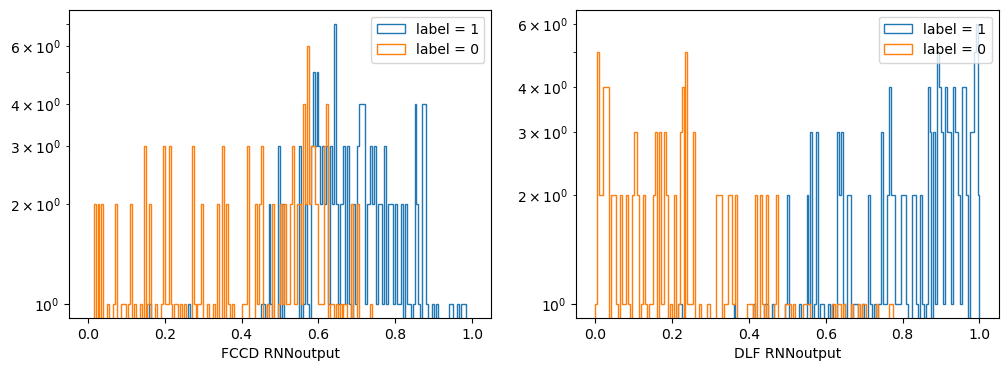

accuracy_FCCD:  0.75
accuracy_DLF:  0.91

EPOCH:  2 / 30
Training network...
Epoch [2/30], Iter [175/175] Loss: 0.3462
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.55it/s]


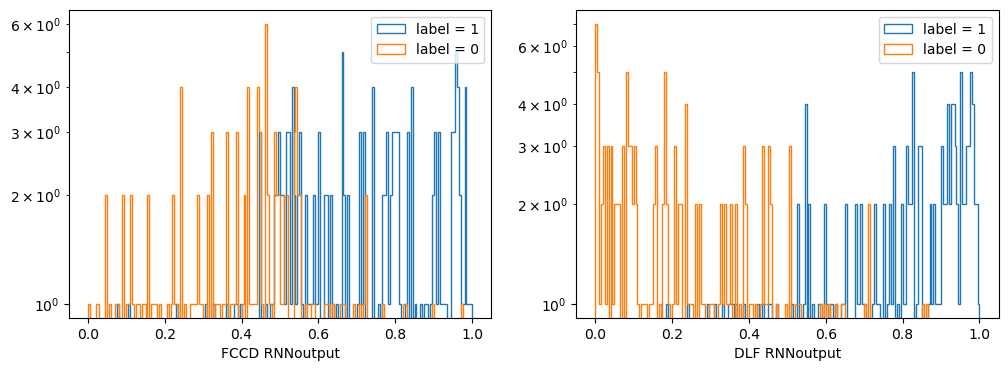

accuracy_FCCD:  0.8033333333333333
accuracy_DLF:  0.8933333333333333

EPOCH:  3 / 30
Training network...
Epoch [3/30], Iter [175/175] Loss: 0.2400
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.60it/s]


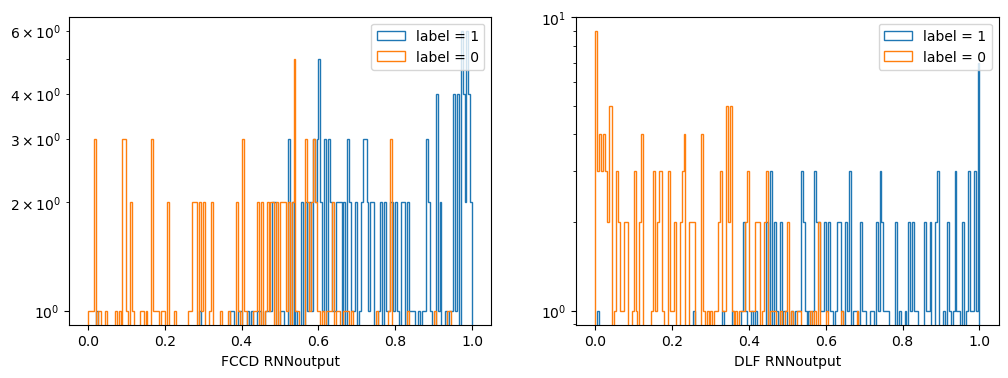

accuracy_FCCD:  0.76
accuracy_DLF:  0.8866666666666667

EPOCH:  4 / 30
Training network...
Epoch [4/30], Iter [175/175] Loss: 0.3077
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.72it/s]


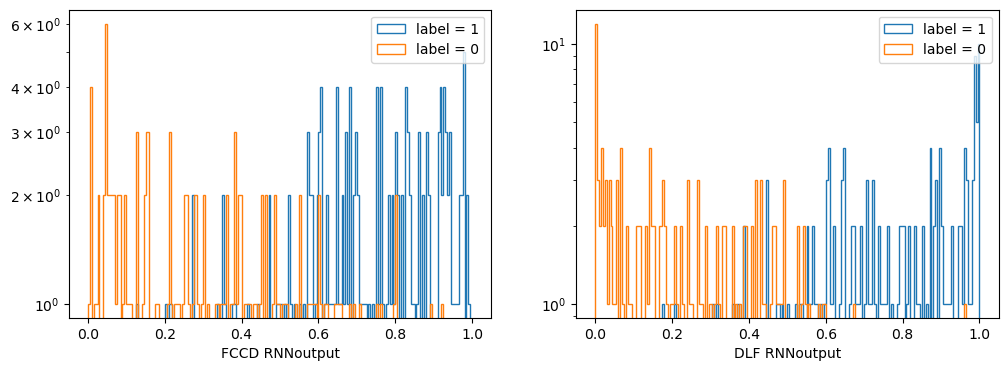

accuracy_FCCD:  0.84
accuracy_DLF:  0.9133333333333333

EPOCH:  5 / 30
Training network...
Epoch [5/30], Iter [175/175] Loss: 0.7248
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.23it/s]


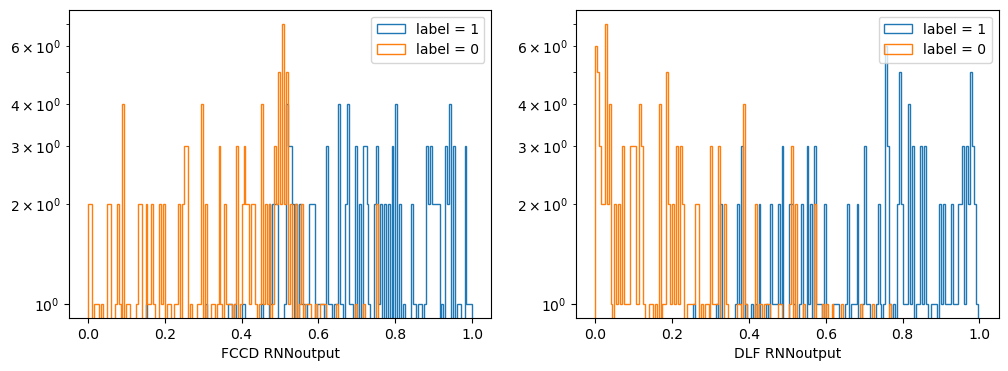

accuracy_FCCD:  0.8233333333333334
accuracy_DLF:  0.8533333333333334

EPOCH:  6 / 30
Training network...
Epoch [6/30], Iter [175/175] Loss: 0.7530
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.78it/s]


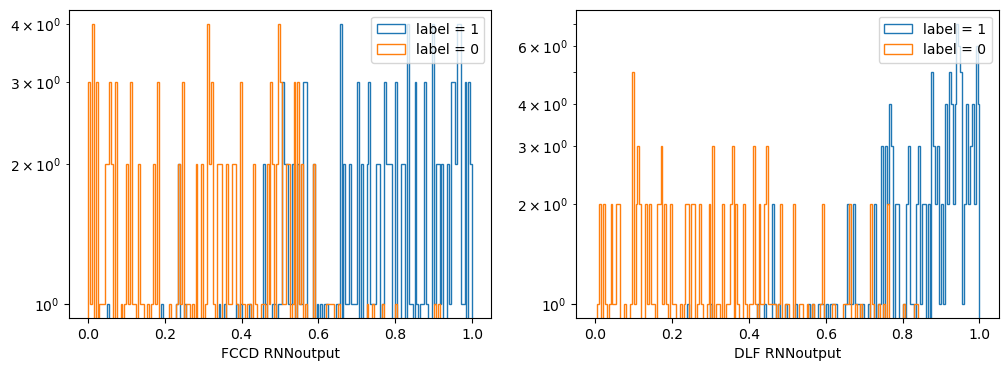

accuracy_FCCD:  0.8333333333333334
accuracy_DLF:  0.8733333333333333

EPOCH:  7 / 30
Training network...
Epoch [7/30], Iter [175/175] Loss: 0.3696
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.36it/s]


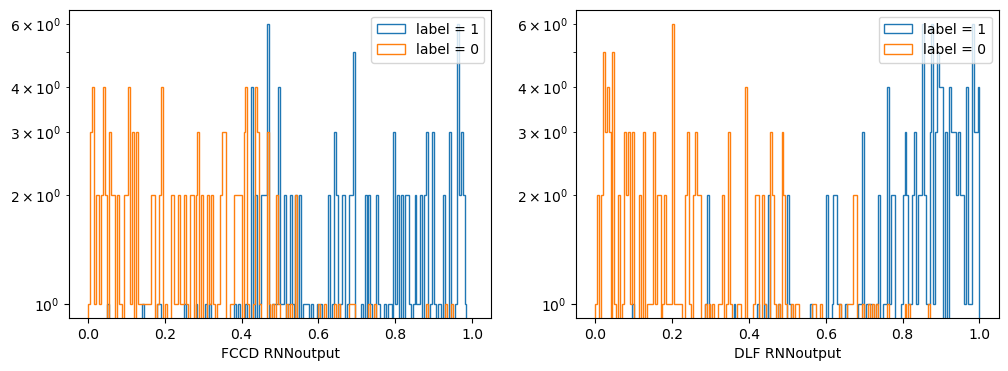

accuracy_FCCD:  0.8233333333333334
accuracy_DLF:  0.89

EPOCH:  8 / 30
Training network...
Epoch [8/30], Iter [175/175] Loss: 0.2294
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.08it/s]


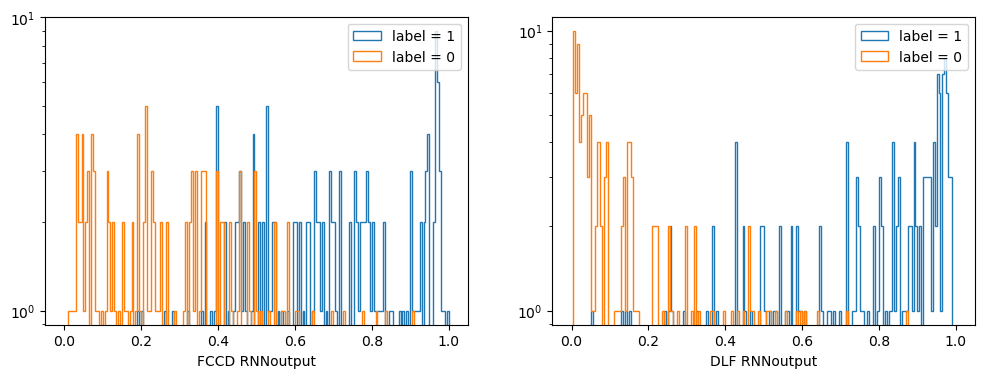

accuracy_FCCD:  0.8233333333333334
accuracy_DLF:  0.8733333333333333

EPOCH:  9 / 30
Training network...
Epoch [9/30], Iter [175/175] Loss: 0.6396
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.51it/s]


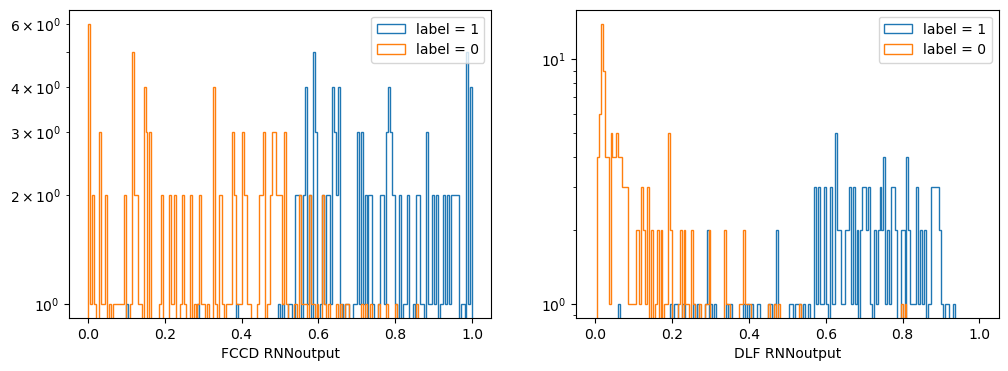

accuracy_FCCD:  0.8733333333333333
accuracy_DLF:  0.9066666666666666

EPOCH:  10 / 30
Training network...
Epoch [10/30], Iter [175/175] Loss: 0.4144
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.10it/s]


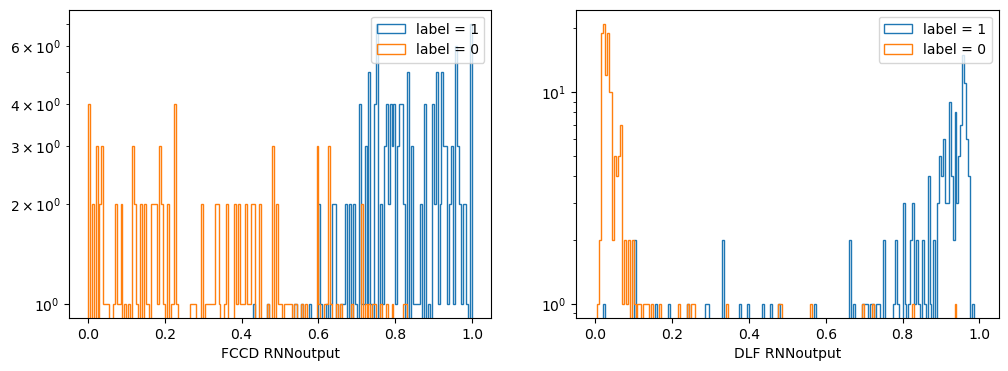

accuracy_FCCD:  0.8833333333333333
accuracy_DLF:  0.9333333333333333

EPOCH:  11 / 30
Training network...
Epoch [11/30], Iter [175/175] Loss: 0.9995
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.69it/s]


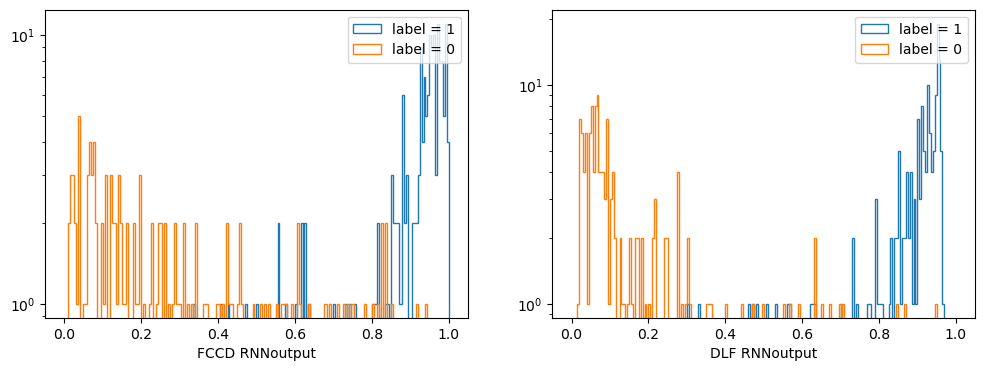

accuracy_FCCD:  0.8866666666666667
accuracy_DLF:  0.9433333333333334

EPOCH:  12 / 30
Training network...
Epoch [12/30], Iter [175/175] Loss: 0.1523
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.95it/s]


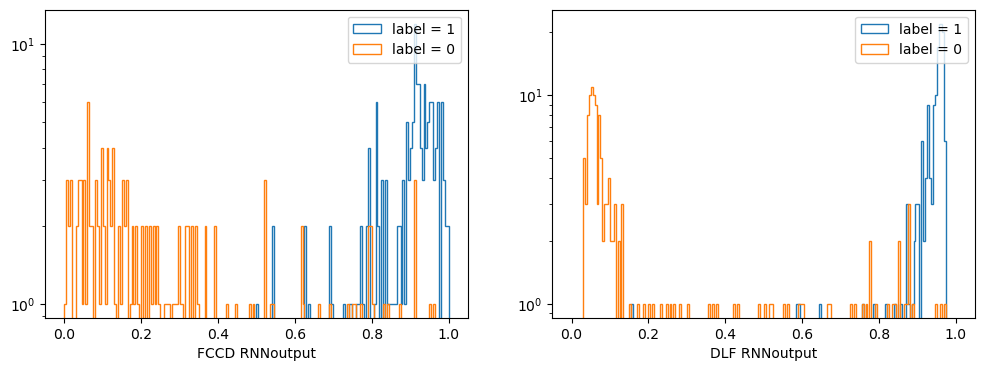

accuracy_FCCD:  0.91
accuracy_DLF:  0.8933333333333333

EPOCH:  13 / 30
Training network...
Epoch [13/30], Iter [175/175] Loss: 0.2637
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.47it/s]


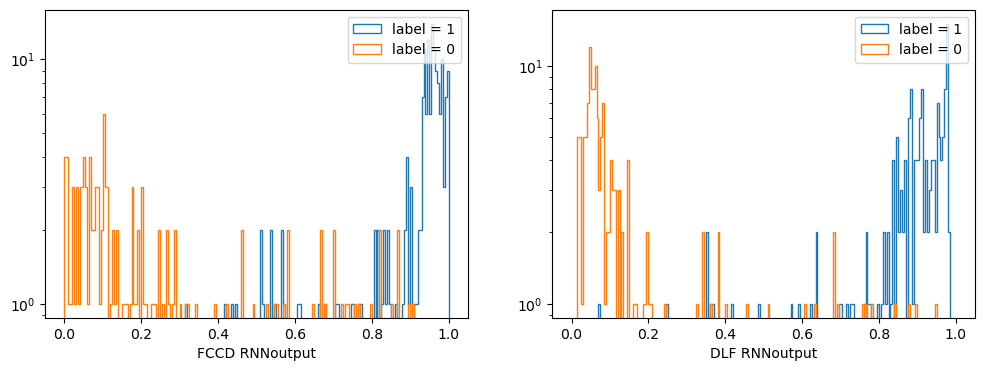

accuracy_FCCD:  0.9033333333333333
accuracy_DLF:  0.93

EPOCH:  14 / 30
Training network...
Epoch [14/30], Iter [175/175] Loss: 0.4406
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 13.45it/s]


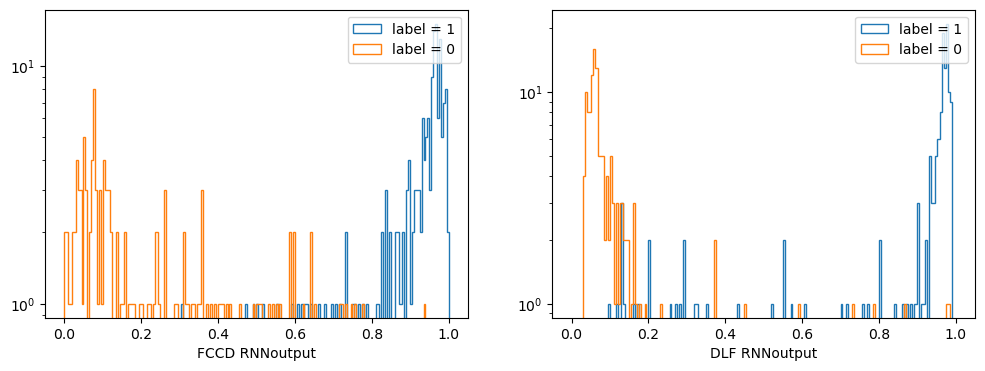

accuracy_FCCD:  0.9166666666666666
accuracy_DLF:  0.9166666666666666

EPOCH:  15 / 30
Training network...
Epoch [15/30], Iter [175/175] Loss: 0.3351
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.11it/s]


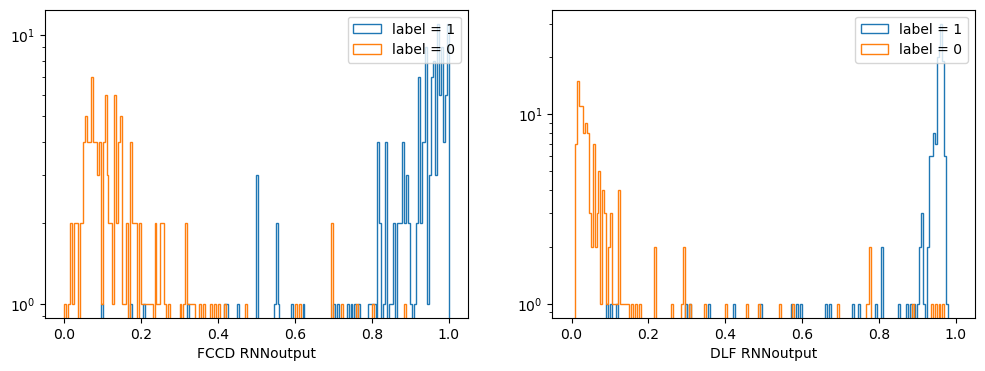

accuracy_FCCD:  0.95
accuracy_DLF:  0.9333333333333333

EPOCH:  16 / 30
Training network...
Epoch [16/30], Iter [175/175] Loss: 0.1732
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.40it/s]


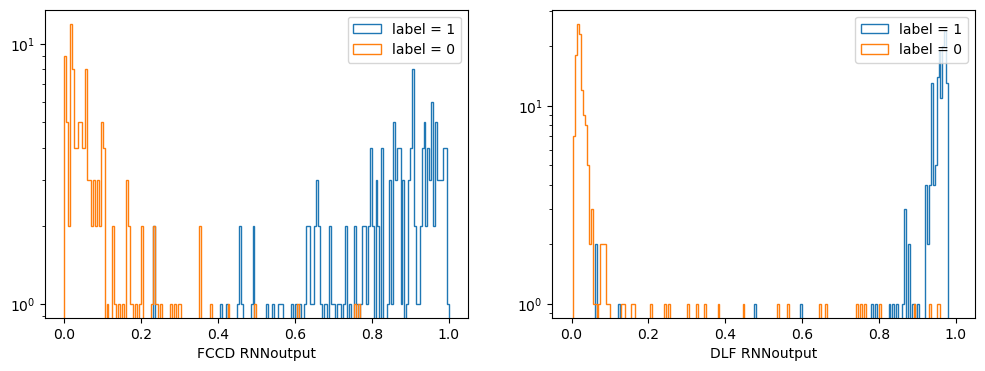

accuracy_FCCD:  0.9533333333333334
accuracy_DLF:  0.9466666666666667

EPOCH:  17 / 30
Training network...
Epoch [17/30], Iter [175/175] Loss: 0.3055
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.95it/s]


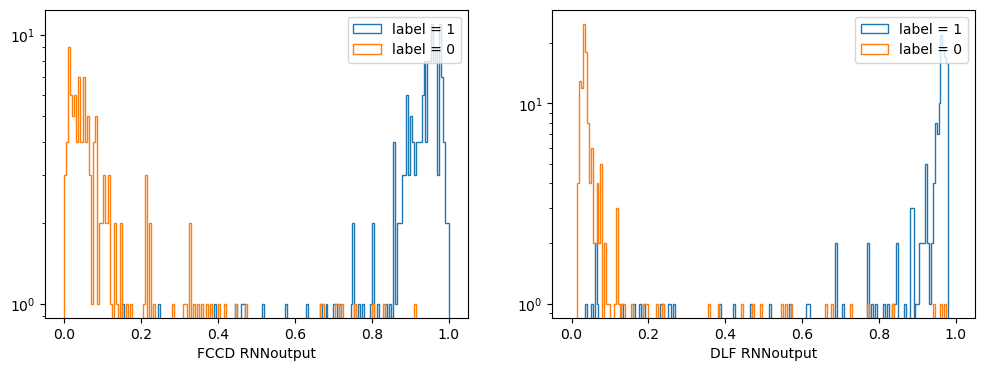

accuracy_FCCD:  0.95
accuracy_DLF:  0.9066666666666666

EPOCH:  18 / 30
Training network...
Epoch [18/30], Iter [175/175] Loss: 0.2806
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.40it/s]


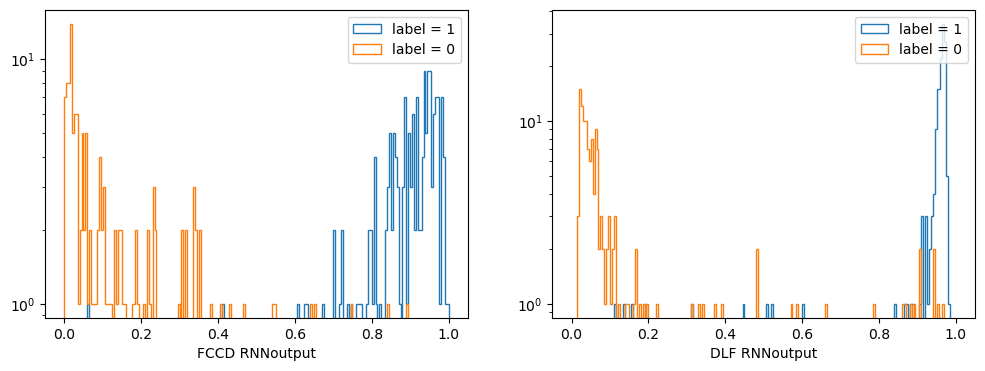

accuracy_FCCD:  0.97
accuracy_DLF:  0.9333333333333333

EPOCH:  19 / 30
Training network...
Epoch [19/30], Iter [175/175] Loss: 0.1957
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.20it/s]


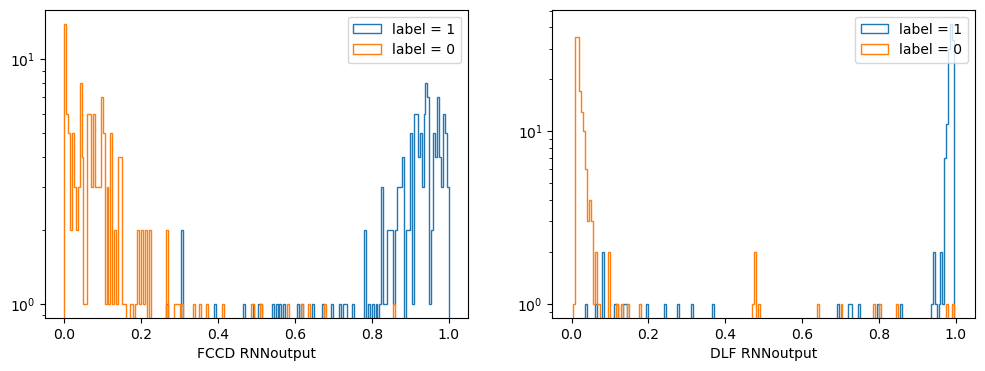

accuracy_FCCD:  0.96
accuracy_DLF:  0.9333333333333333

EPOCH:  20 / 30
Training network...
Epoch [20/30], Iter [175/175] Loss: 0.0997
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.71it/s]


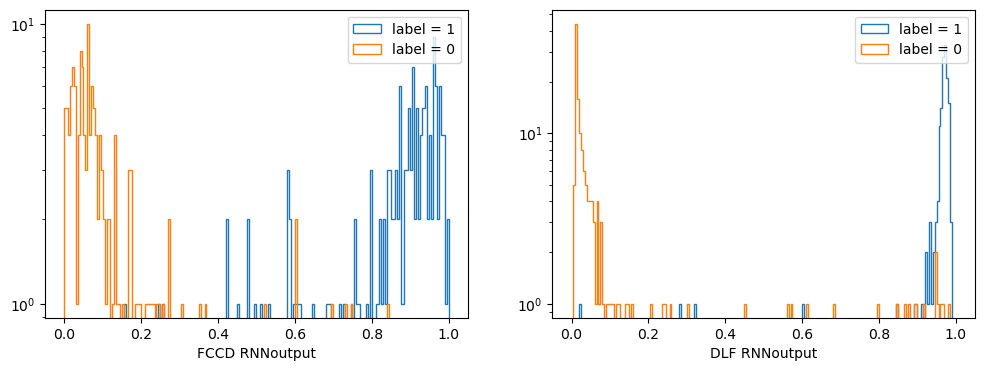

accuracy_FCCD:  0.9466666666666667
accuracy_DLF:  0.9333333333333333

EPOCH:  21 / 30
Training network...
Epoch [21/30], Iter [175/175] Loss: 0.3475
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.61it/s]


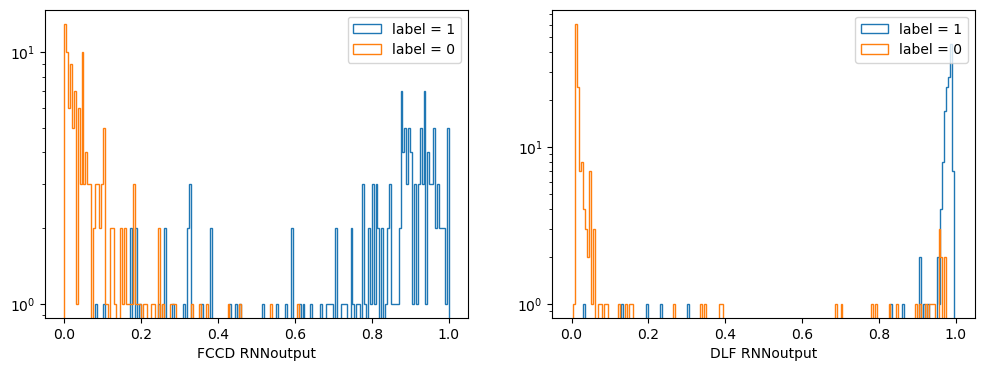

accuracy_FCCD:  0.9166666666666666
accuracy_DLF:  0.92

EPOCH:  22 / 30
Training network...
Epoch [22/30], Iter [175/175] Loss: 0.4649
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.45it/s]


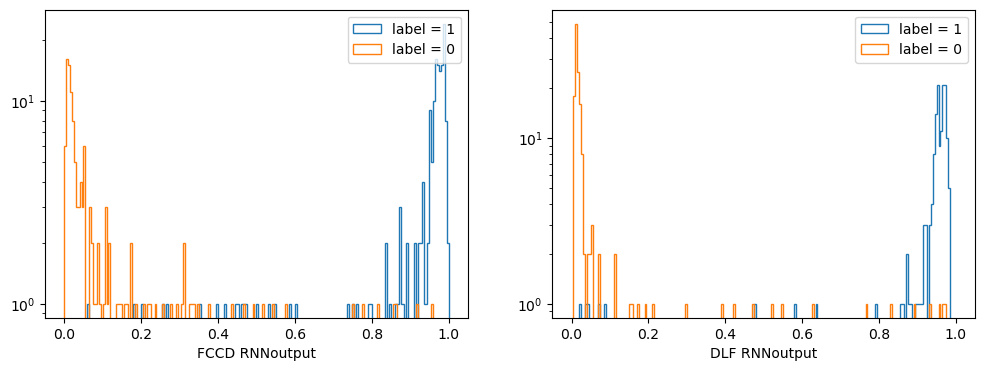

accuracy_FCCD:  0.9233333333333333
accuracy_DLF:  0.9466666666666667

EPOCH:  23 / 30
Training network...
Epoch [23/30], Iter [175/175] Loss: 0.6918
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.66it/s]


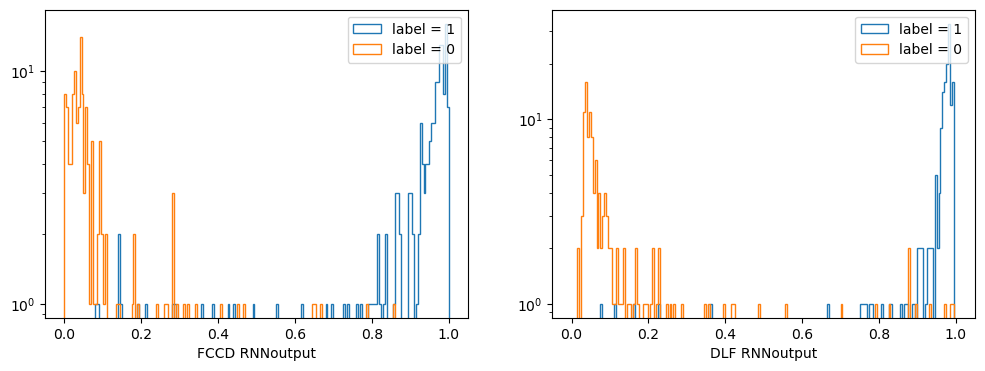

accuracy_FCCD:  0.9366666666666666
accuracy_DLF:  0.9466666666666667

EPOCH:  24 / 30
Training network...
Epoch [24/30], Iter [175/175] Loss: 0.1462
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.44it/s]


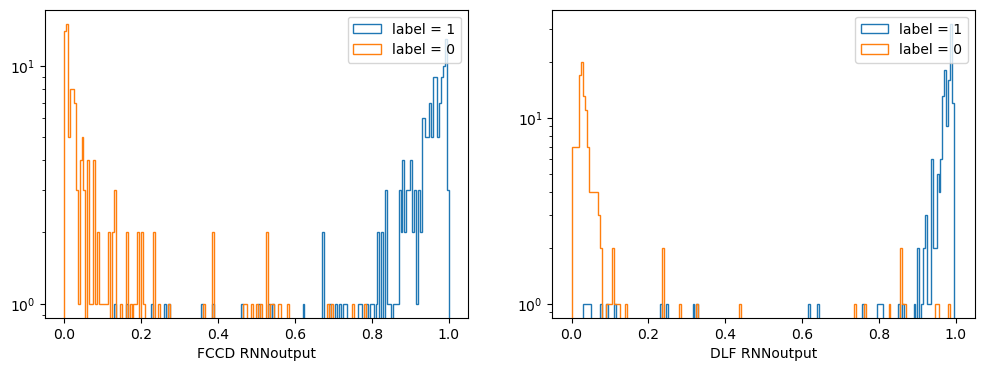

accuracy_FCCD:  0.93
accuracy_DLF:  0.93

EPOCH:  25 / 30
Training network...
Epoch [25/30], Iter [175/175] Loss: 0.0443
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.11it/s]


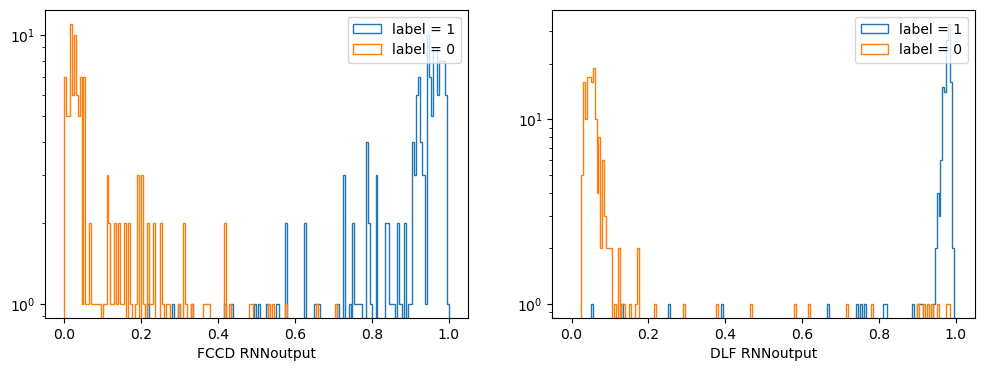

accuracy_FCCD:  0.96
accuracy_DLF:  0.95

EPOCH:  26 / 30
Training network...
Epoch [26/30], Iter [175/175] Loss: 0.4257
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.97it/s]


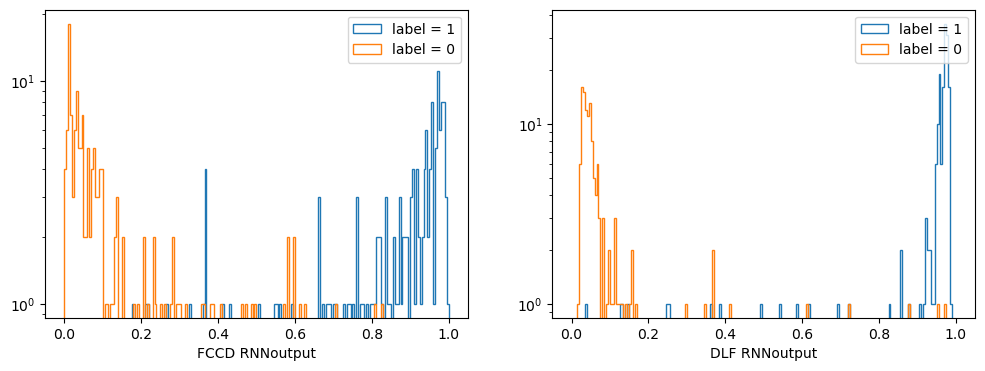

accuracy_FCCD:  0.9266666666666666
accuracy_DLF:  0.9533333333333334

EPOCH:  27 / 30
Training network...
Epoch [27/30], Iter [175/175] Loss: 0.3475
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 13.81it/s]


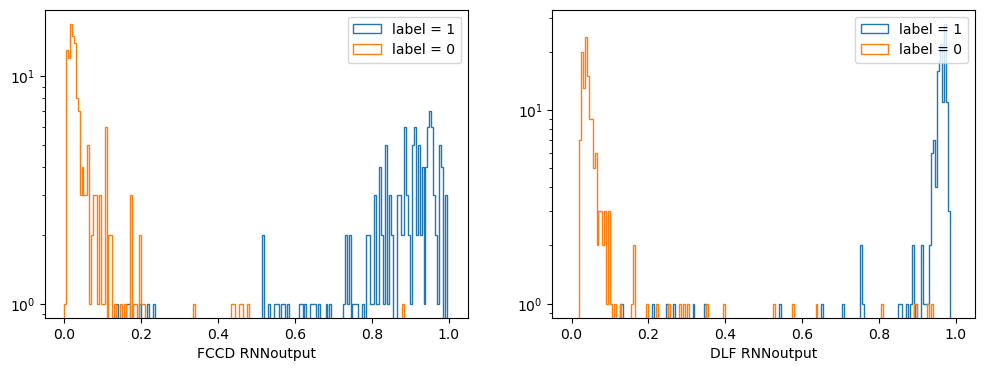

accuracy_FCCD:  0.9766666666666667
accuracy_DLF:  0.95

EPOCH:  28 / 30
Training network...
Epoch [28/30], Iter [175/175] Loss: 0.1815
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.66it/s]


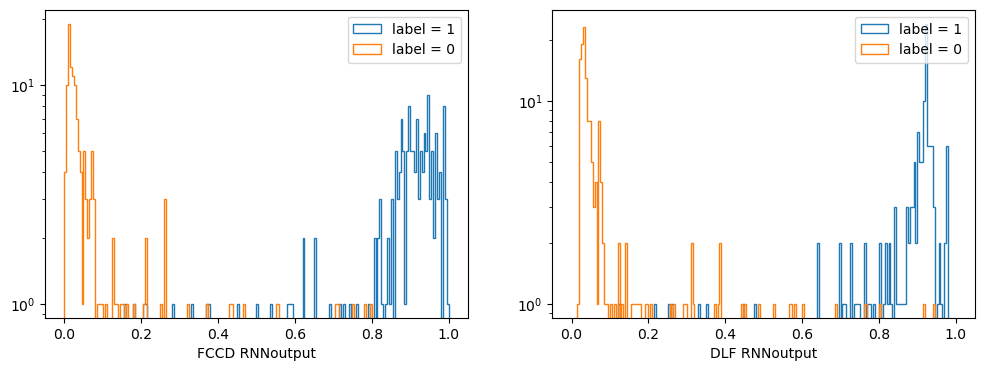

accuracy_FCCD:  0.9466666666666667
accuracy_DLF:  0.9366666666666666

EPOCH:  29 / 30
Training network...
Epoch [29/30], Iter [175/175] Loss: 0.2047
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.34it/s]


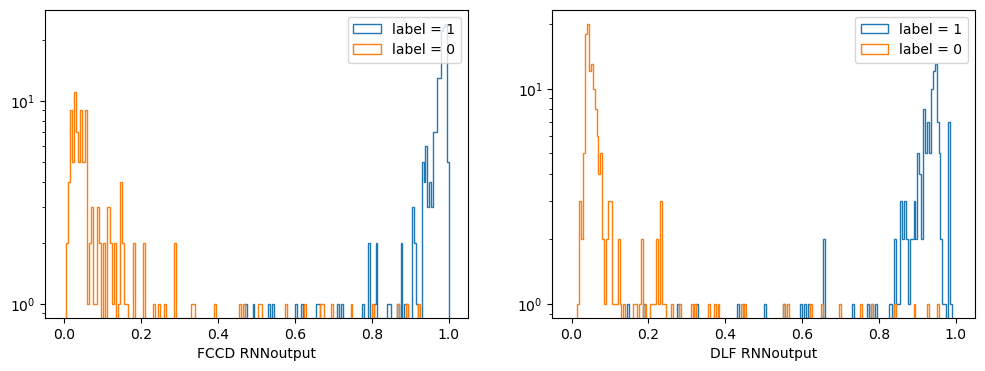

accuracy_FCCD:  0.9533333333333334
accuracy_DLF:  0.9433333333333334

EPOCH:  30 / 30
Training network...
Epoch [30/30], Iter [175/175] Loss: 0.0804
Testing/Validating...


100%|██████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 15.43it/s]


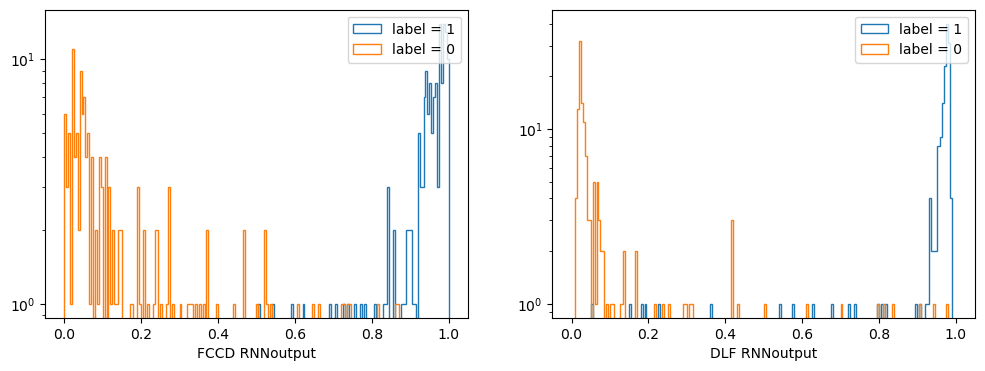

accuracy_FCCD:  0.95
accuracy_DLF:  0.95

Training complete.

Saving RNN at /unix/legend/abi/ML_DL/saved_models/RNN_30epochs_LR0.005_fulldataset.pkl


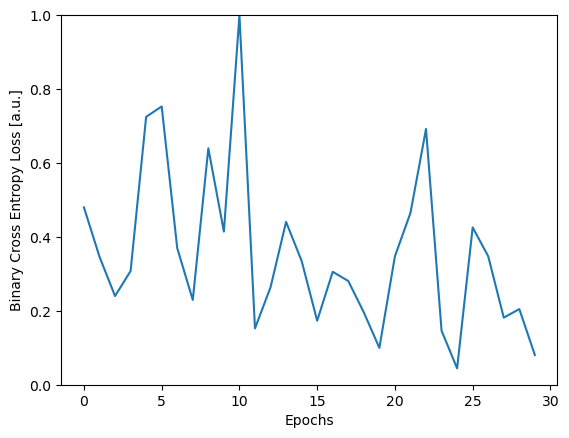

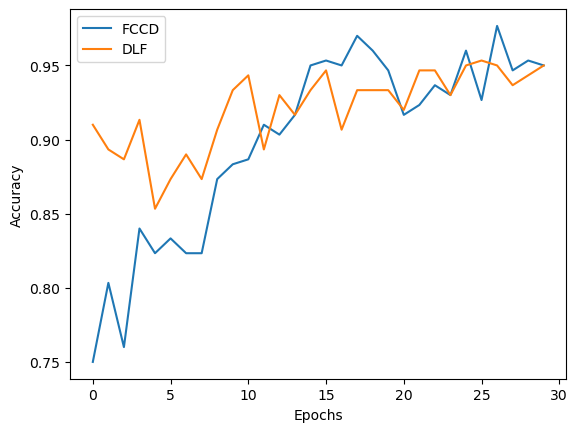

In [54]:
#Training - do not rerun if not necesarry
# torch.cuda.empty_cache()
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)


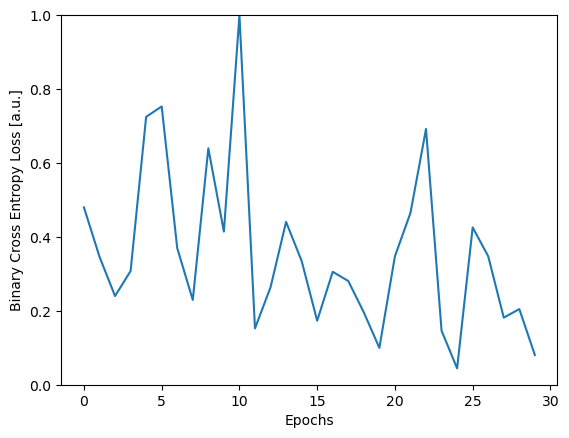

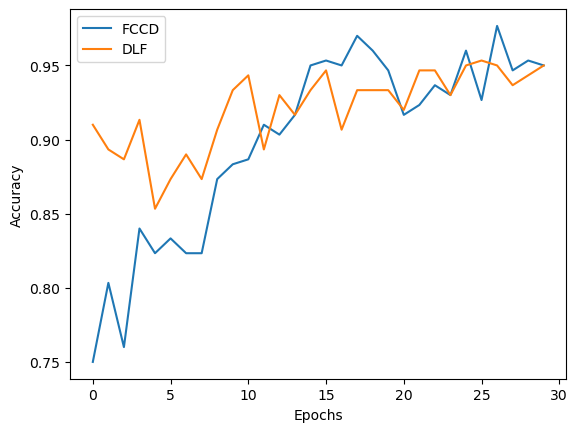

In [56]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing

In [17]:
# Load saved model
RNNclassifier_fulldataset = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_fulldataset.load_state_dict(torch.load(model_path))
RNNclassifier_fulldataset.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.40it/s]


FCCD accuracies: 
total:  300
TP:  153
FP:  16
TN:  129
FN:  2
accuracy:  0.94
precision:  0.9053254437869822
recall:  0.9870967741935484

DLF accuracies: 
total:  300
TP:  141
FP:  12
TN:  143
FN:  4
accuracy:  0.9466666666666667
precision:  0.9215686274509803
recall:  0.9724137931034482
Total # misclassified trials FCCD:  18  / 300
Total # misclassified trials DLF:  16  / 300


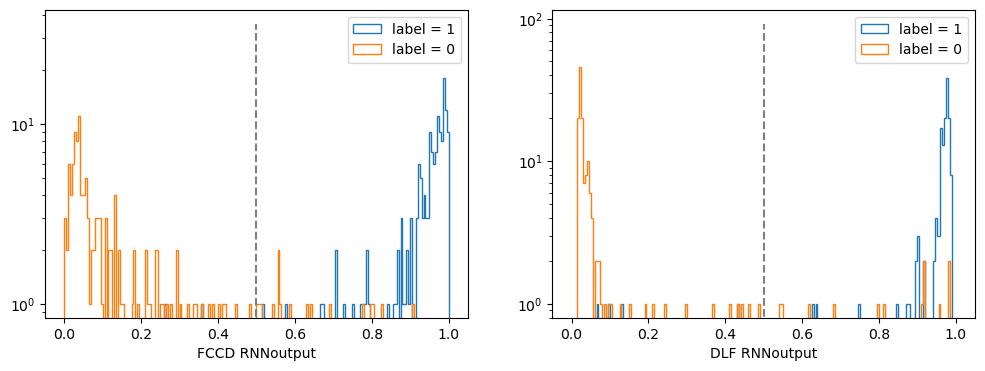

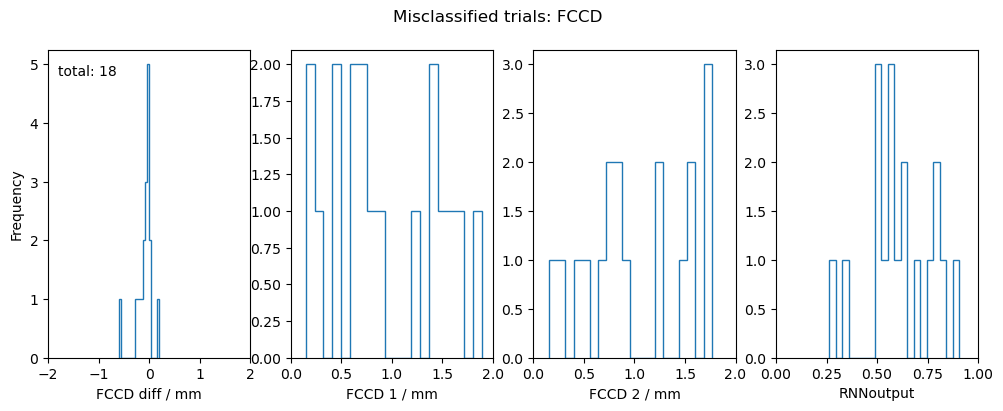

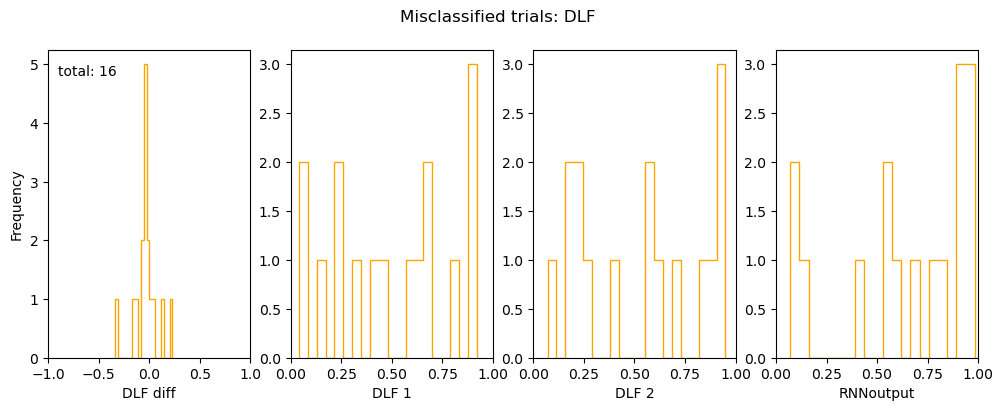

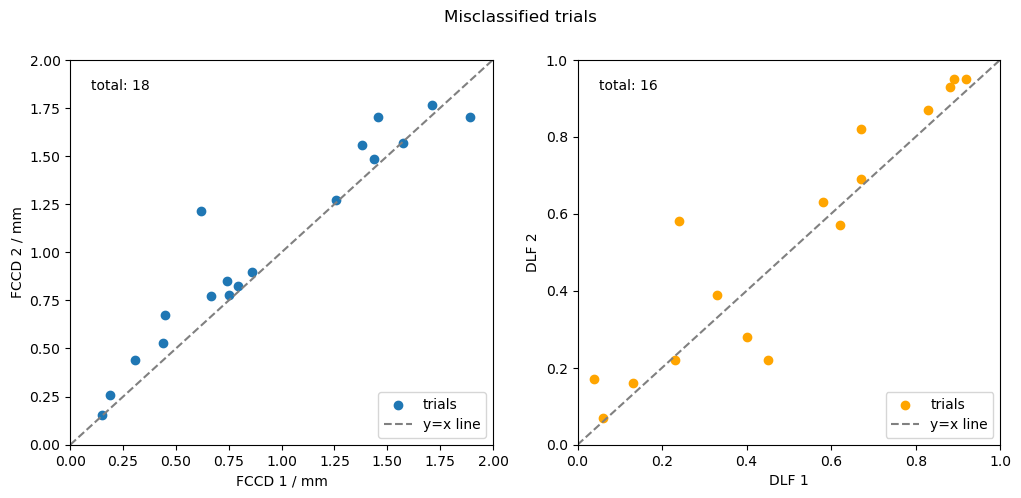

In [18]:
#testing
accuracies_fulldataset = test_RNN(RNNclassifier_fulldataset, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


## Investigate Attention

In [24]:
next(iter(test_loader))

[tensor([[[-0.9223, -1.0171, -1.0745,  ..., -1.5851, -1.5227, -3.1125]],
 
         [[ 0.1187,  0.0932,  0.0765,  ..., -0.7926, -1.5227,  0.0000]],
 
         [[-0.1848, -0.1725, -0.1650,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.1142, -0.0980, -0.0999,  ...,  0.0000,  0.0000,  0.0000]]],
        dtype=torch.float64),
 tensor([0, 1, 0, 0]),
 tensor([1, 0, 1, 1]),
 {'FCCD1': tensor([0.1900, 1.0500, 0.7700, 1.7120], dtype=torch.float64),
  'FCCD2': tensor([0.2560, 0.3480, 1.9960, 1.7580], dtype=torch.float64),
  'FCCD_diff': tensor([-0.0660,  0.7020, -1.2260, -0.0460], dtype=torch.float64),
  'DLF1': tensor([0.8400, 0.5300, 0.9400, 0.8100], dtype=torch.float64),
  'DLF2': tensor([0.1300, 0.6900, 0.6200, 0.6200], dtype=torch.float64),
  'DLF_diff': tensor([ 0.7100, -0.1600,  0.3200,  0.1900], dtype=torch.float64)},
 tensor([[1.5290e+03, 1.7600e+03, 1.8261e+03,  ..., 6.9660e-01, 3.4830e-01,
          3.4830e-01],
         [3.9960e+03, 4.0253e+03, 3.5910e+03,  ..., 0.0000e+00, 0.00

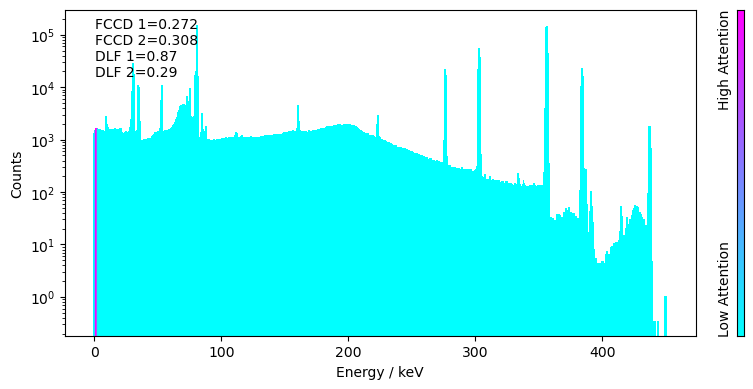

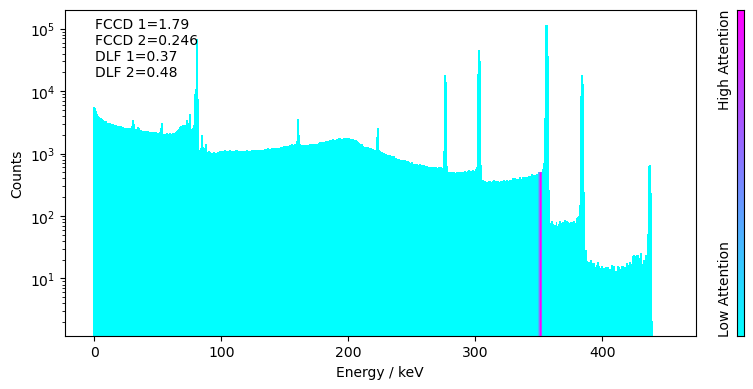

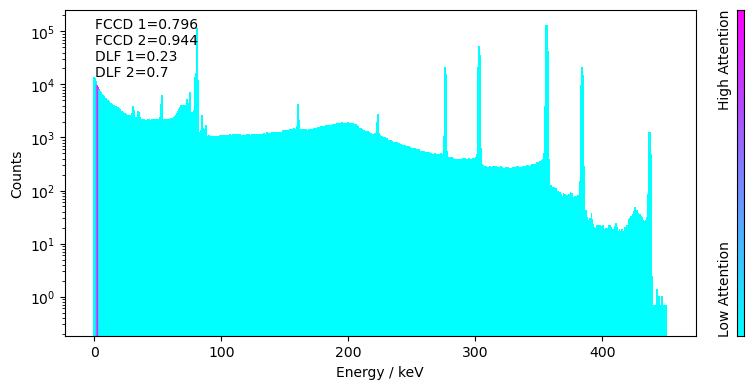

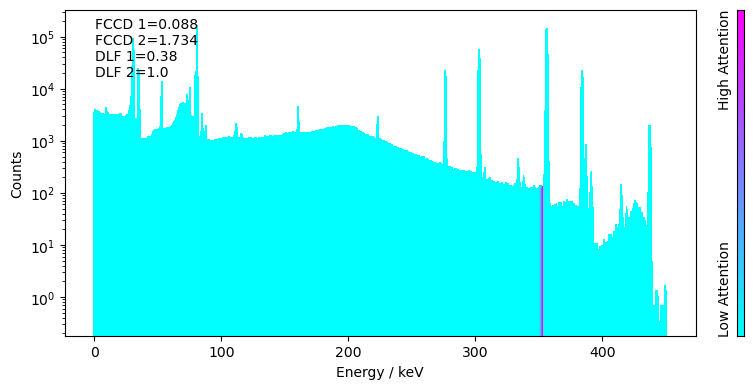

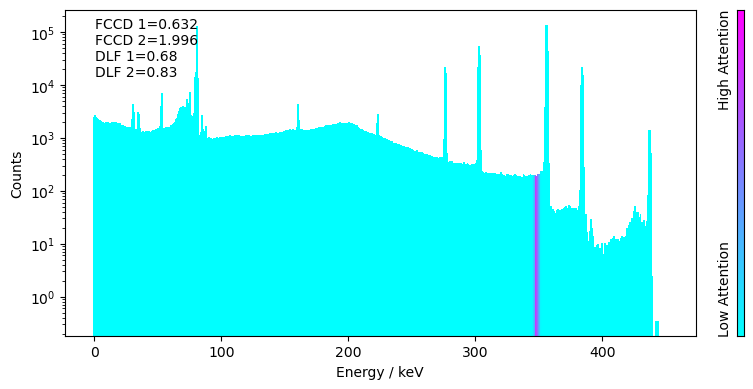

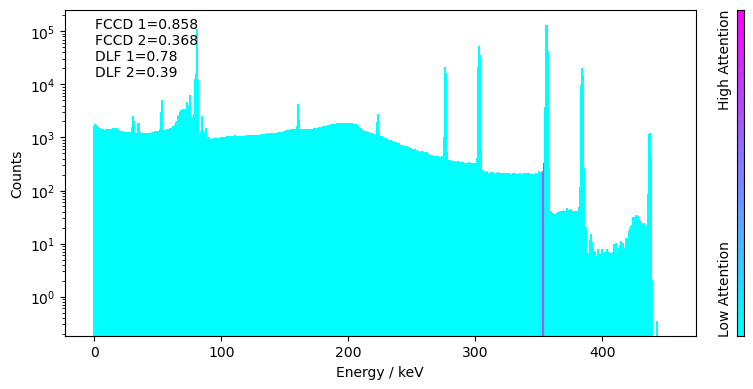

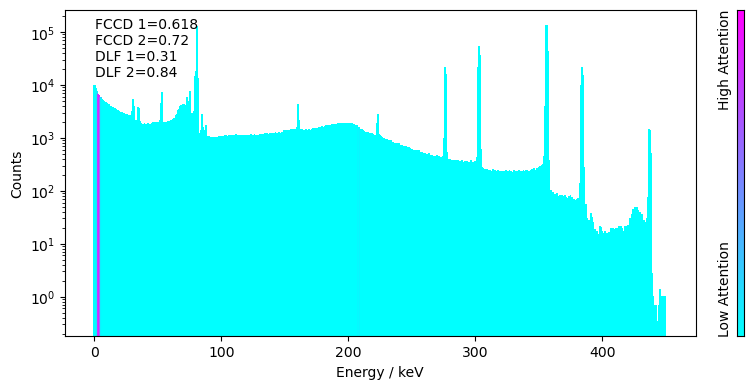

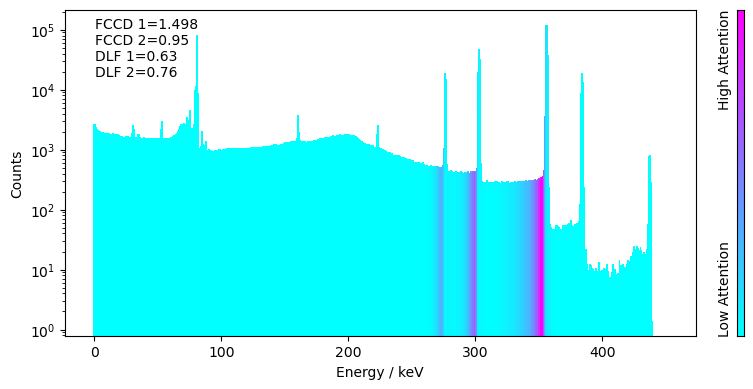

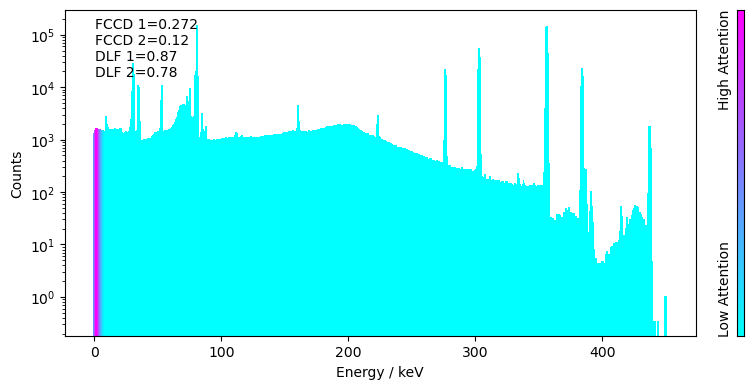

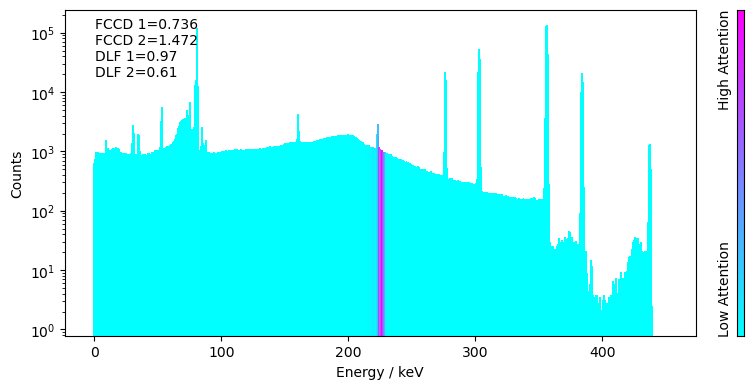

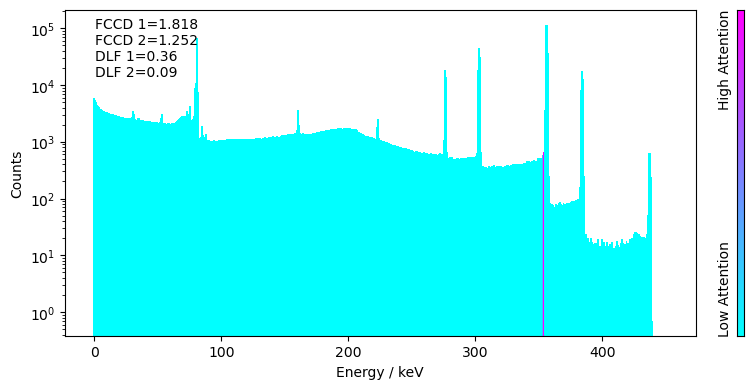

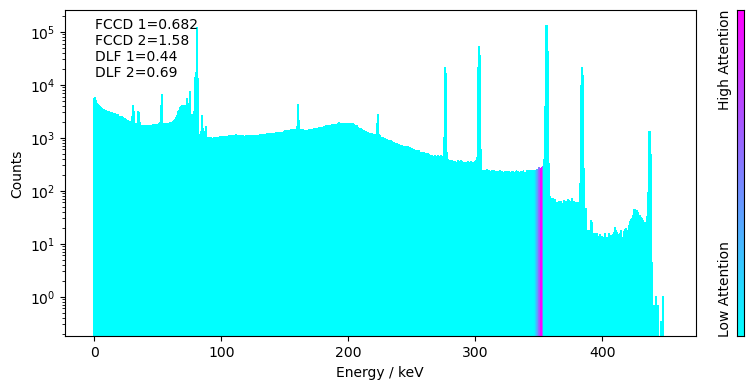

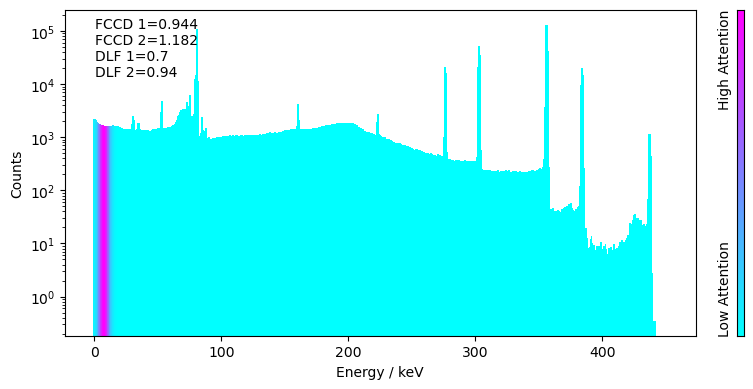

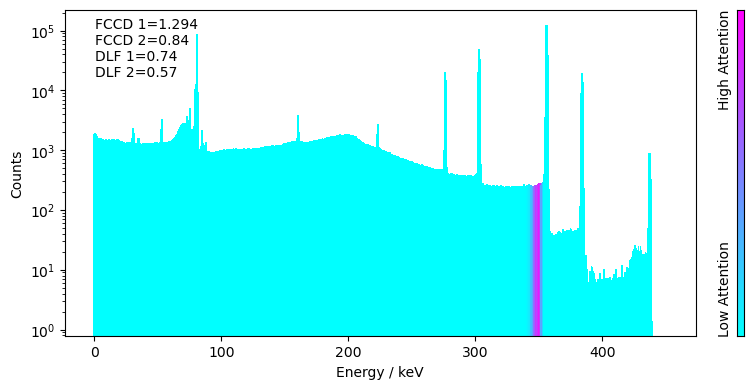

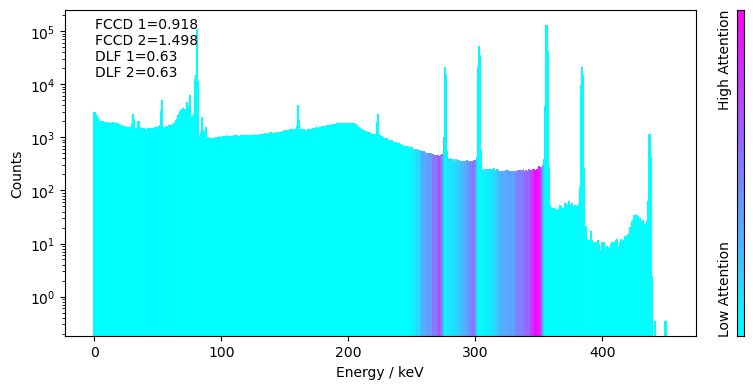

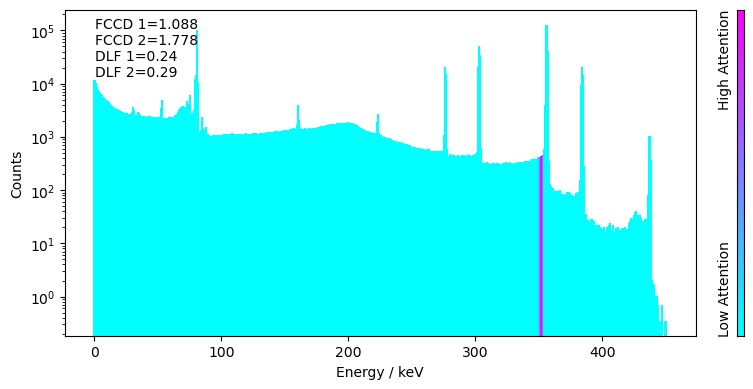

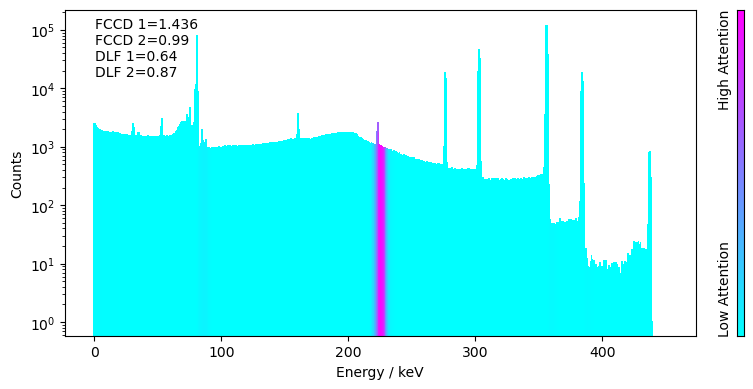

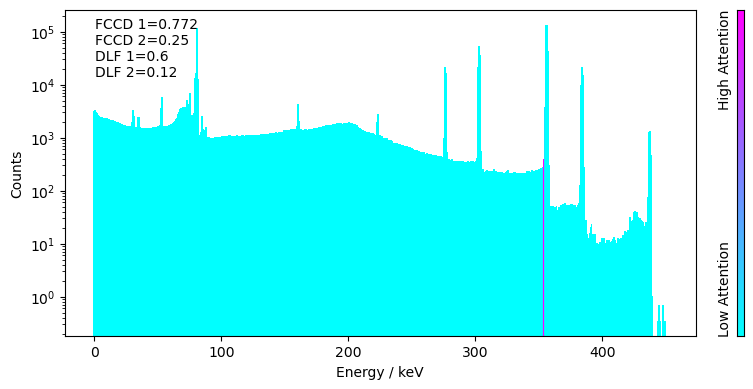

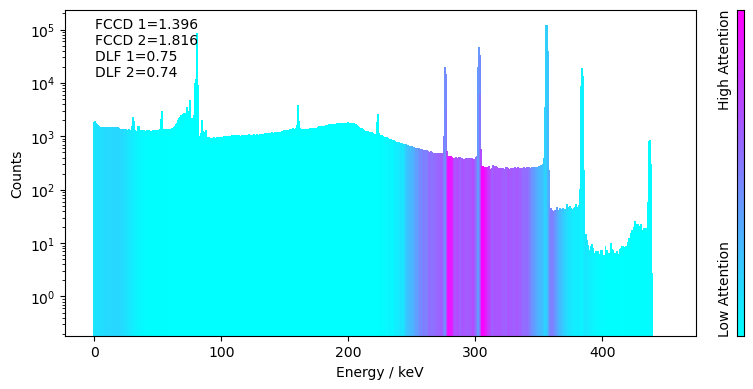

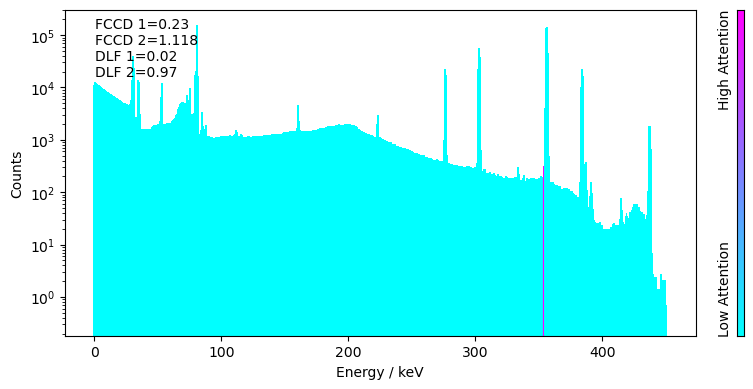

In [25]:
#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")

for a in range(5): 
    
    #Load a test event through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)


    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)

    #     pdf.savefig(fig)
        fig.savefig(pdf, format='pdf') 

pdf.close()
    

In [26]:
#     # data values
#     data_spectrum = torch.tensor(dataset.get_data()).to(DEVICE).float()
#     data_outputs = RNNclassifier(data_spectrum)
#     data_outputs = data_outputs.cpu().data.numpy()#.flatten()
#     data_out_index = np.argmax(data_outputs)

# TRAINING 2: restircted dataset - Max FCCD diff = 0.5 mm

Only train on FCCDs with a max diff of 0.5 mm

In [27]:
NUM_EPOCHS = 30 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
maxFCCDdiff = 0.5
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID = "RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

In [28]:
#load dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict)

100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 178.69it/s]

(1000, 900)


## Training - DO NOT RERUN UNLESS NECESARRY

#params 2106114
Warmup Size: 400
- - - - - - - - - - -

EPOCH:  1 / 30
Training network...
Epoch [1/30], Iter [175/175] Loss: 0.3339
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.07it/s]


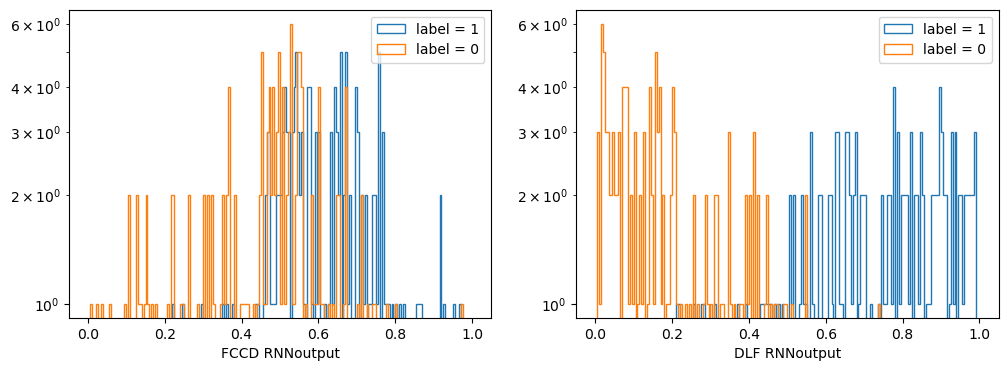

accuracy_FCCD:  0.6966666666666667
accuracy_DLF:  0.93

EPOCH:  2 / 30
Training network...
Epoch [2/30], Iter [175/175] Loss: 0.2843
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.05it/s]


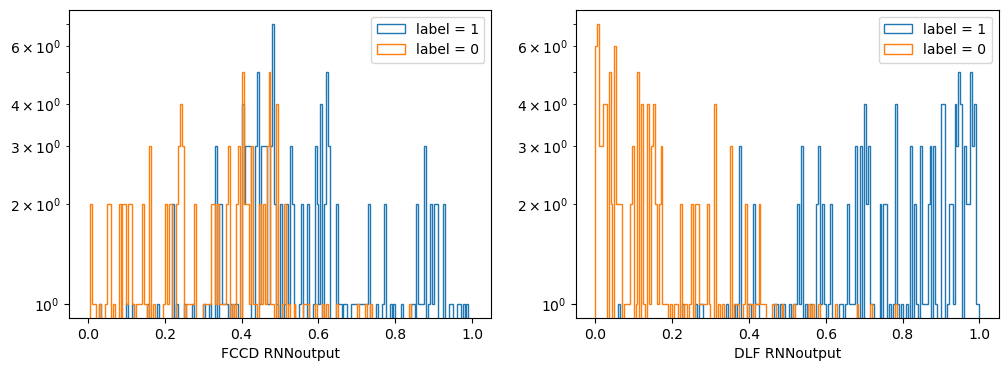

accuracy_FCCD:  0.7033333333333334
accuracy_DLF:  0.9033333333333333

EPOCH:  3 / 30
Training network...
Epoch [3/30], Iter [175/175] Loss: 0.4812
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.00it/s]


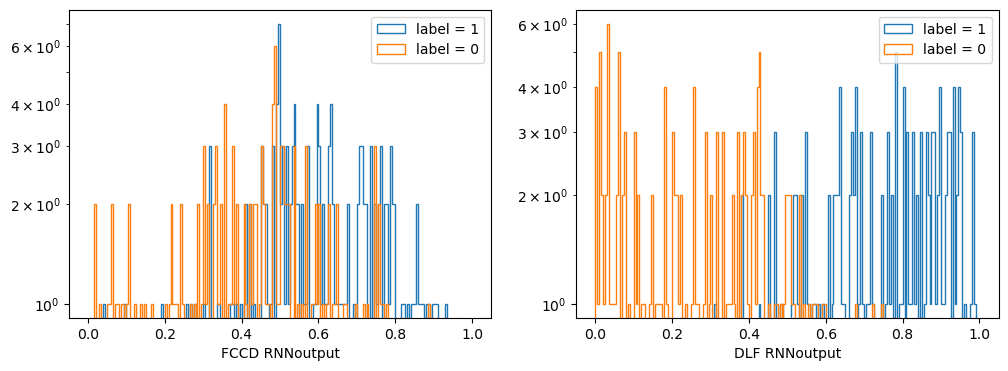

accuracy_FCCD:  0.6866666666666666
accuracy_DLF:  0.9033333333333333

EPOCH:  4 / 30
Training network...
Epoch [4/30], Iter [175/175] Loss: 0.3504
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.10it/s]


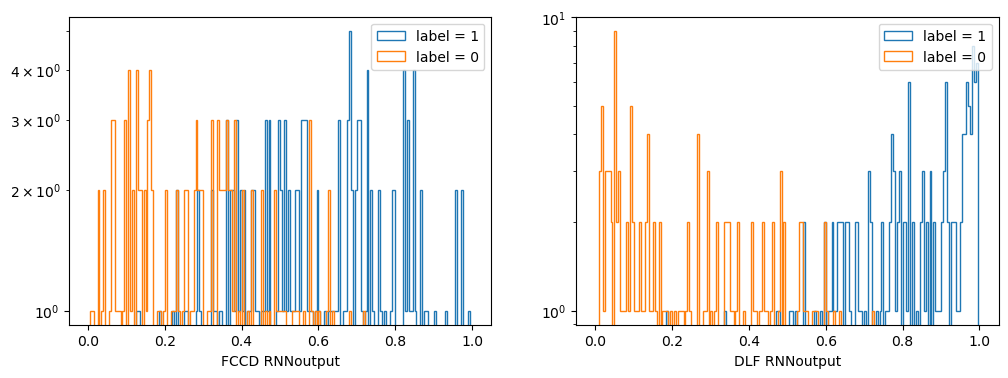

accuracy_FCCD:  0.7466666666666667
accuracy_DLF:  0.93

EPOCH:  5 / 30
Training network...
Epoch [5/30], Iter [175/175] Loss: 0.3014
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.83it/s]


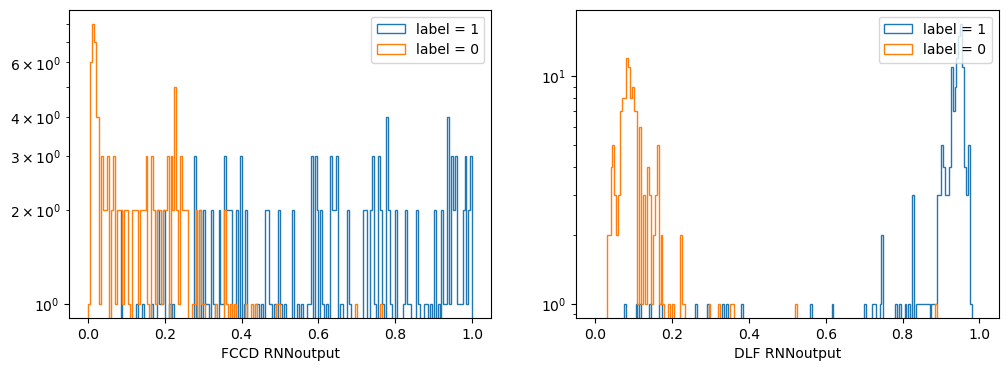

accuracy_FCCD:  0.8
accuracy_DLF:  0.9566666666666667

EPOCH:  6 / 30
Training network...
Epoch [6/30], Iter [175/175] Loss: 0.2975
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.13it/s]


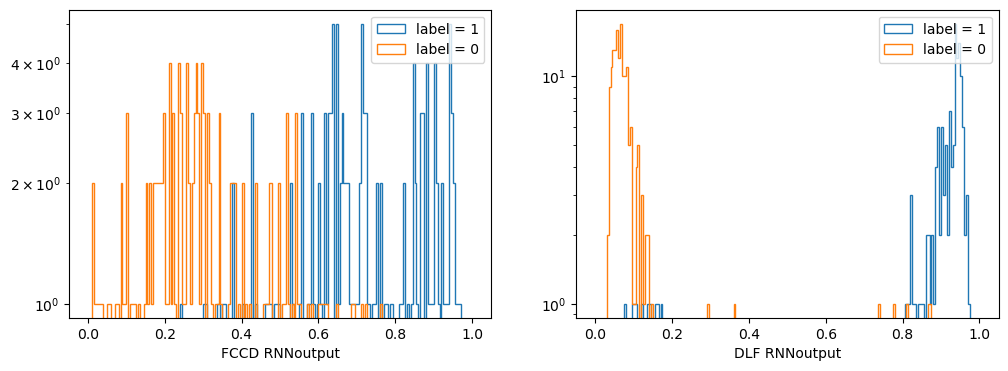

accuracy_FCCD:  0.8466666666666667
accuracy_DLF:  0.95

EPOCH:  7 / 30
Training network...
Epoch [7/30], Iter [175/175] Loss: 0.1157
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.96it/s]


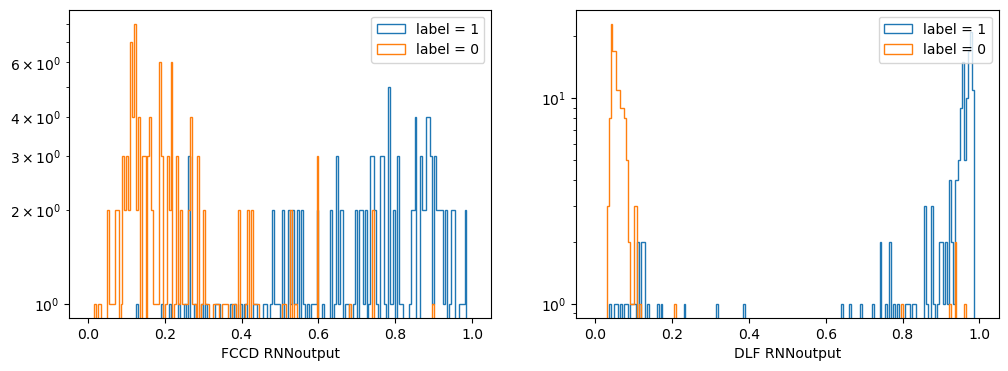

accuracy_FCCD:  0.86
accuracy_DLF:  0.9133333333333333

EPOCH:  8 / 30
Training network...
Epoch [8/30], Iter [175/175] Loss: 0.4871
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.77it/s]


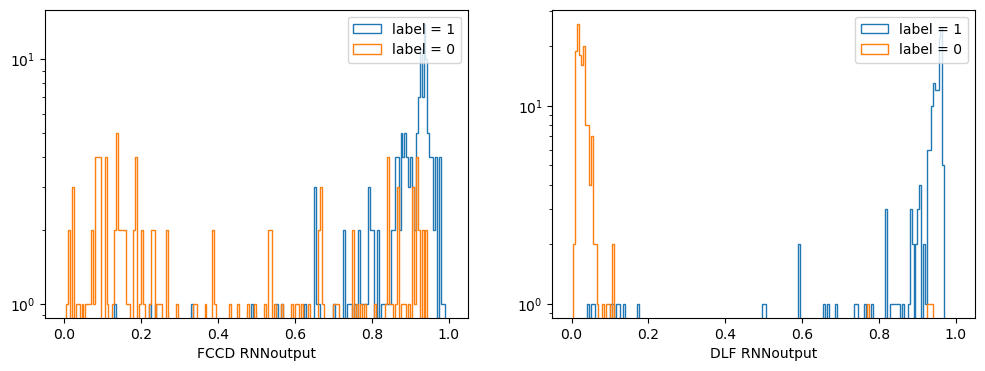

accuracy_FCCD:  0.7966666666666666
accuracy_DLF:  0.9533333333333334

EPOCH:  9 / 30
Training network...
Epoch [9/30], Iter [175/175] Loss: 0.4442
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 12.01it/s]


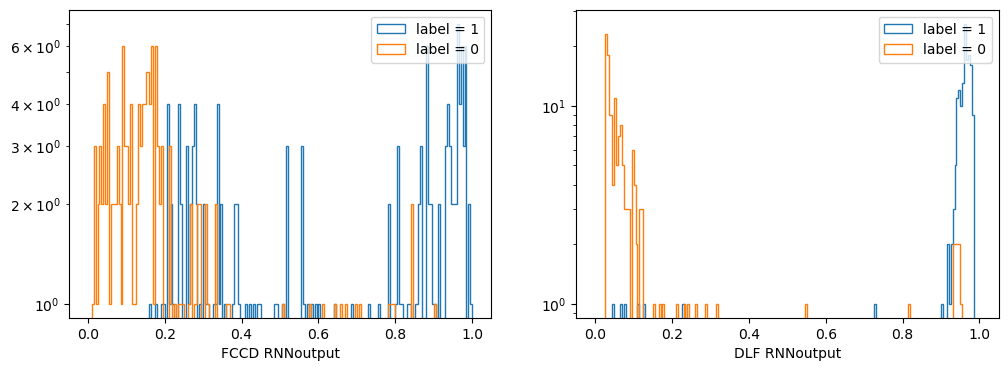

accuracy_FCCD:  0.7466666666666667
accuracy_DLF:  0.94

EPOCH:  10 / 30
Training network...
Epoch [10/30], Iter [175/175] Loss: 0.4646
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.35it/s]


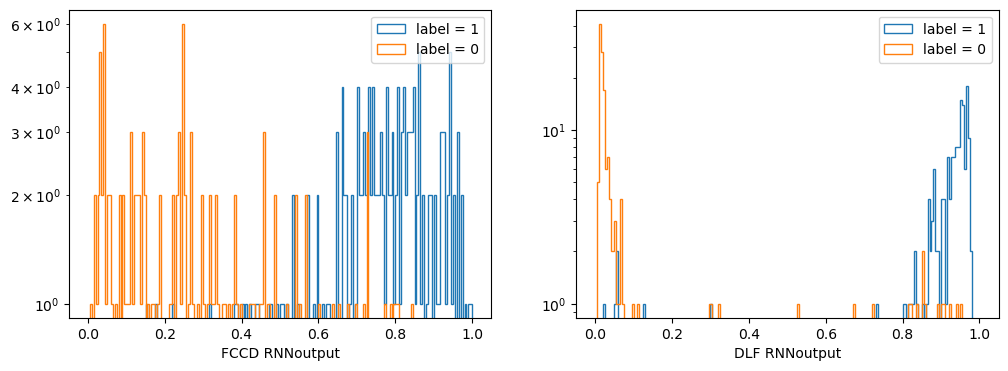

accuracy_FCCD:  0.8833333333333333
accuracy_DLF:  0.93

EPOCH:  11 / 30
Training network...
Epoch [11/30], Iter [175/175] Loss: 0.5268
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.33it/s]


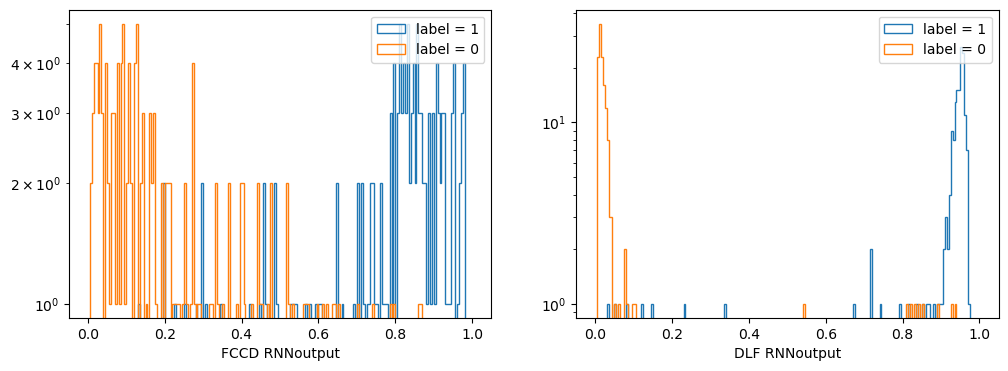

accuracy_FCCD:  0.8766666666666667
accuracy_DLF:  0.9466666666666667

EPOCH:  12 / 30
Training network...
Epoch [12/30], Iter [175/175] Loss: 0.5936
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.76it/s]


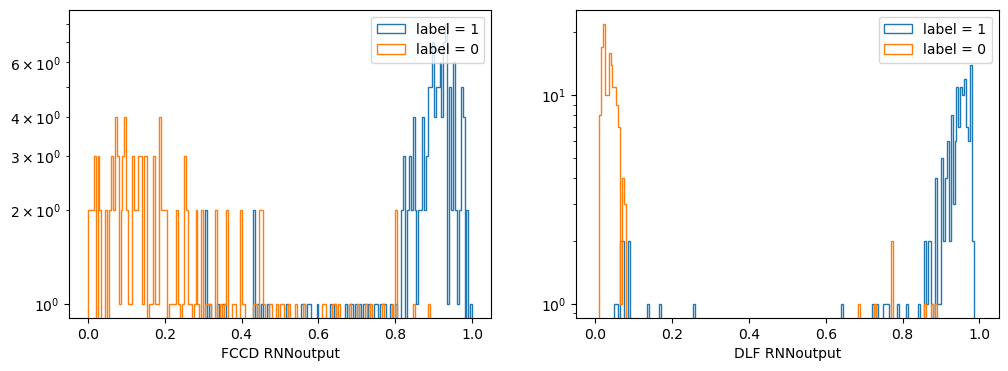

accuracy_FCCD:  0.8966666666666666
accuracy_DLF:  0.94

EPOCH:  13 / 30
Training network...
Epoch [13/30], Iter [175/175] Loss: 0.1677
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.45it/s]


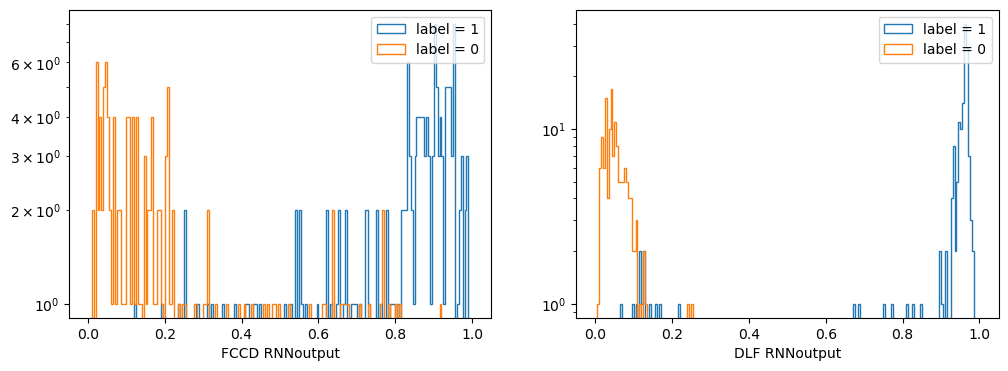

accuracy_FCCD:  0.88
accuracy_DLF:  0.96

EPOCH:  14 / 30
Training network...
Epoch [14/30], Iter [175/175] Loss: 0.2229
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.39it/s]


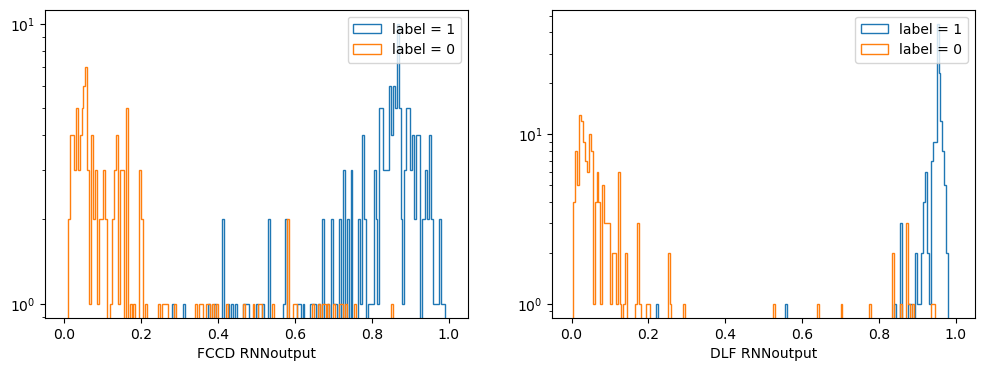

accuracy_FCCD:  0.9
accuracy_DLF:  0.95

EPOCH:  15 / 30
Training network...
Epoch [15/30], Iter [175/175] Loss: 0.1732
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.16it/s]


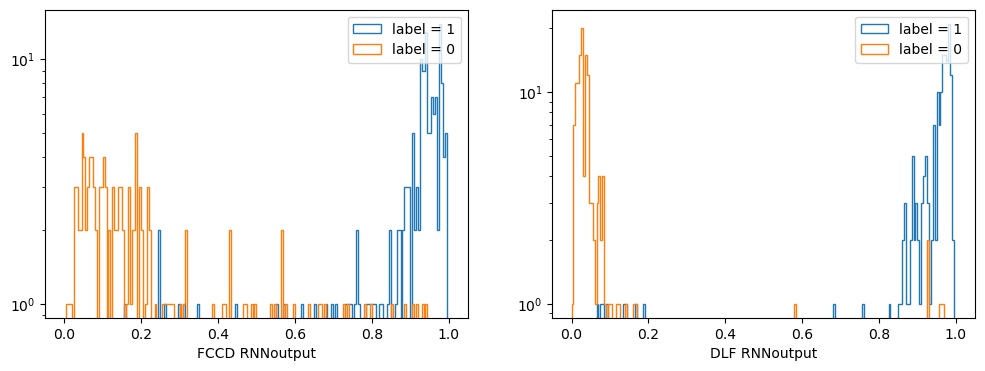

accuracy_FCCD:  0.9066666666666666
accuracy_DLF:  0.9533333333333334

EPOCH:  16 / 30
Training network...
Epoch [16/30], Iter [175/175] Loss: 0.1110
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.31it/s]


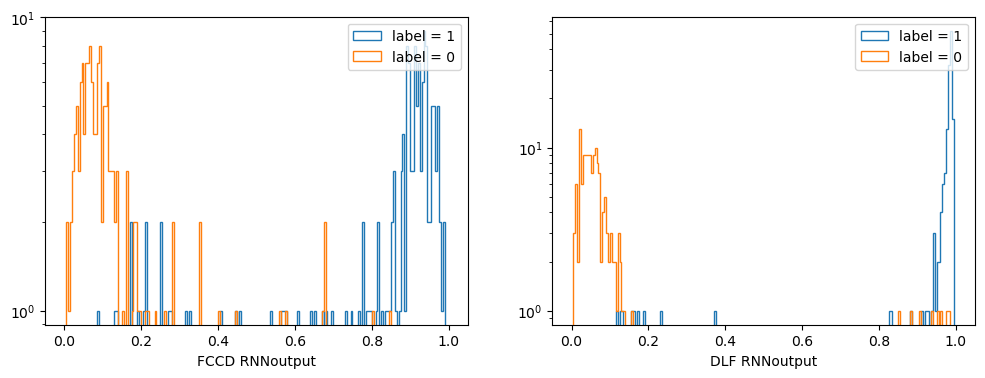

accuracy_FCCD:  0.9166666666666666
accuracy_DLF:  0.9433333333333334

EPOCH:  17 / 30
Training network...
Epoch [17/30], Iter [175/175] Loss: 0.1061
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.07it/s]


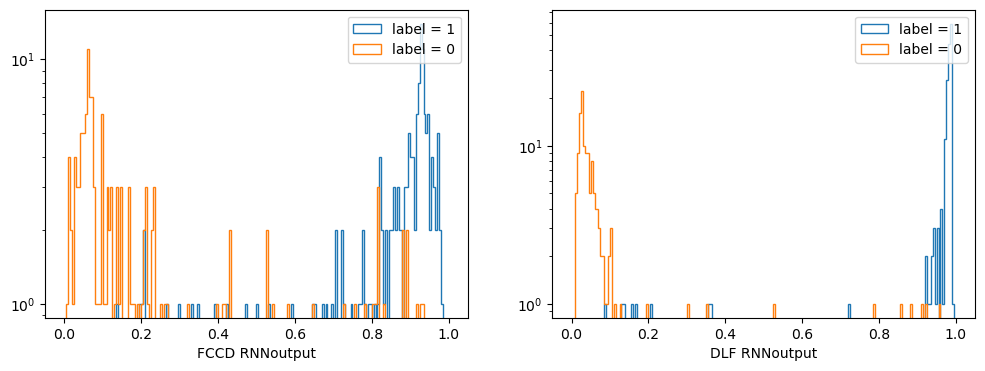

accuracy_FCCD:  0.8866666666666667
accuracy_DLF:  0.95

EPOCH:  18 / 30
Training network...
Epoch [18/30], Iter [175/175] Loss: 0.2961
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.21it/s]


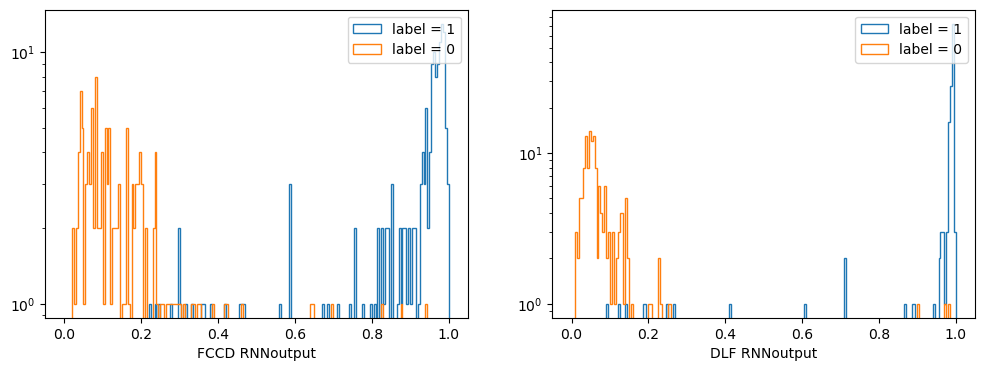

accuracy_FCCD:  0.9266666666666666
accuracy_DLF:  0.9633333333333334

EPOCH:  19 / 30
Training network...
Epoch [19/30], Iter [175/175] Loss: 0.1047
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.52it/s]


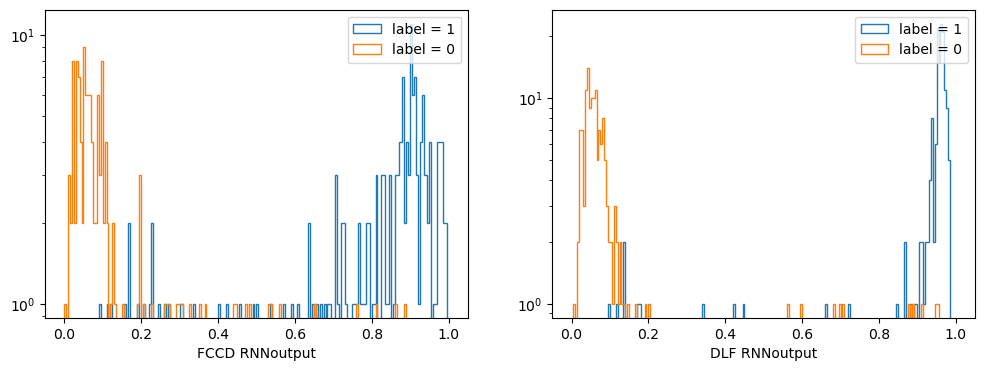

accuracy_FCCD:  0.9033333333333333
accuracy_DLF:  0.9366666666666666

EPOCH:  20 / 30
Training network...
Epoch [20/30], Iter [175/175] Loss: 0.0897
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 12.10it/s]


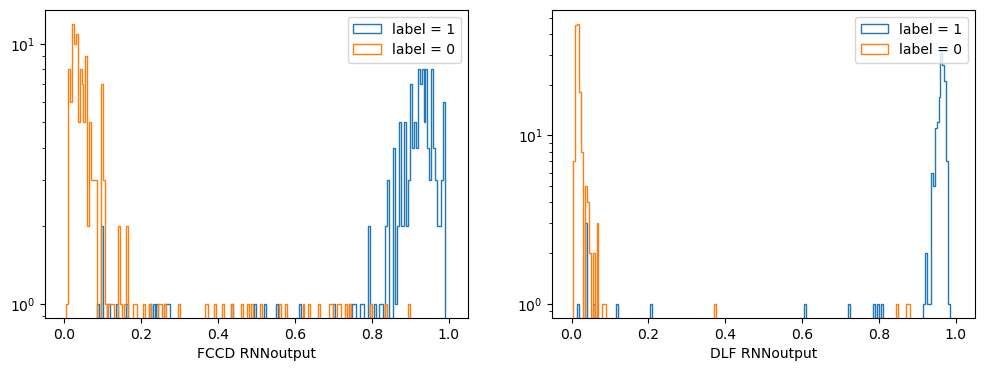

accuracy_FCCD:  0.9
accuracy_DLF:  0.9666666666666667

EPOCH:  21 / 30
Training network...
Epoch [21/30], Iter [175/175] Loss: 0.2227
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.08it/s]


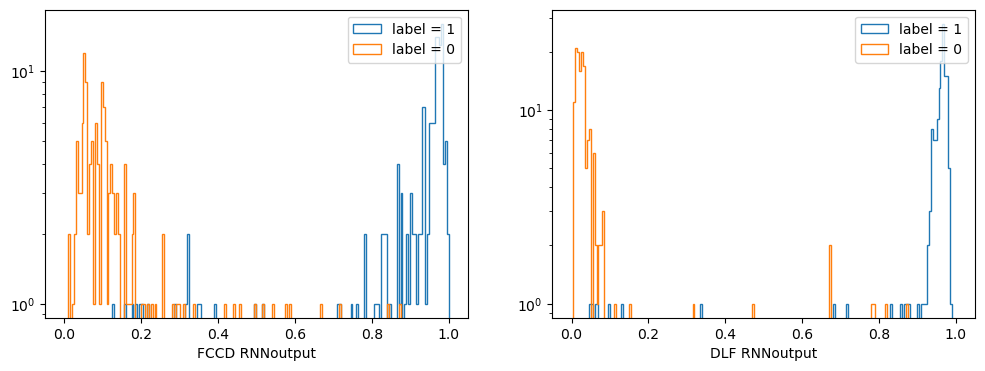

accuracy_FCCD:  0.9233333333333333
accuracy_DLF:  0.9566666666666667

EPOCH:  22 / 30
Training network...
Epoch [22/30], Iter [175/175] Loss: 0.4584
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.53it/s]


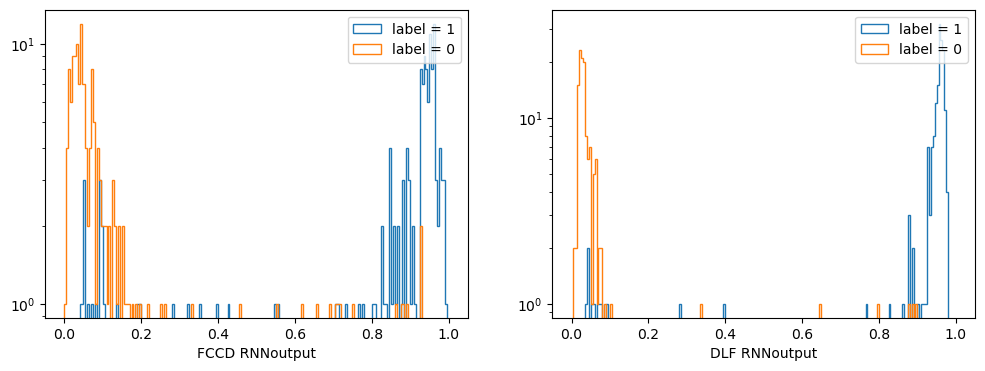

accuracy_FCCD:  0.88
accuracy_DLF:  0.9466666666666667

EPOCH:  23 / 30
Training network...
Epoch [23/30], Iter [175/175] Loss: 0.4327
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.57it/s]


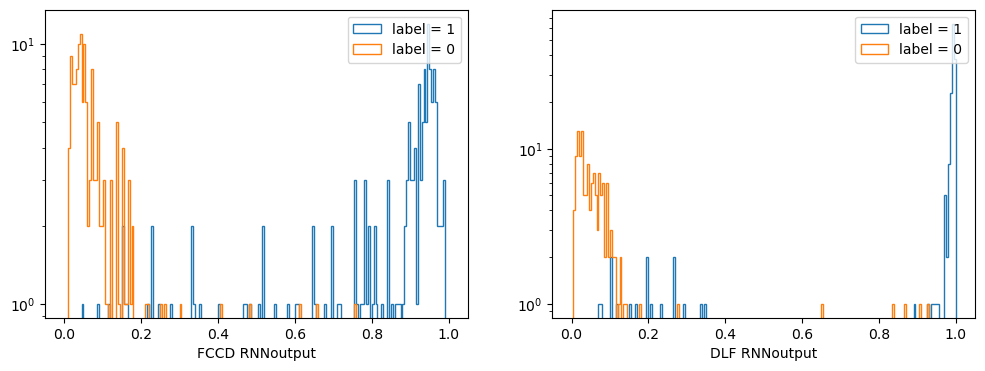

accuracy_FCCD:  0.9233333333333333
accuracy_DLF:  0.93

EPOCH:  24 / 30
Training network...
Epoch [24/30], Iter [175/175] Loss: 0.5635
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.22it/s]


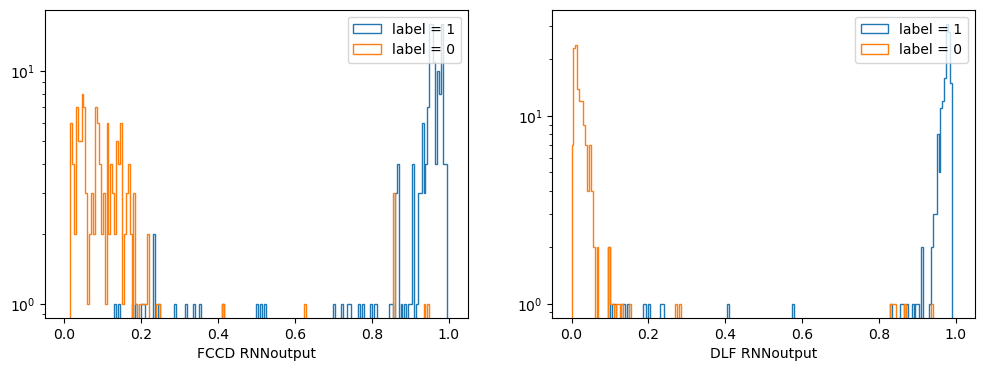

accuracy_FCCD:  0.9333333333333333
accuracy_DLF:  0.94

EPOCH:  25 / 30
Training network...
Epoch [25/30], Iter [175/175] Loss: 0.0829
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.74it/s]


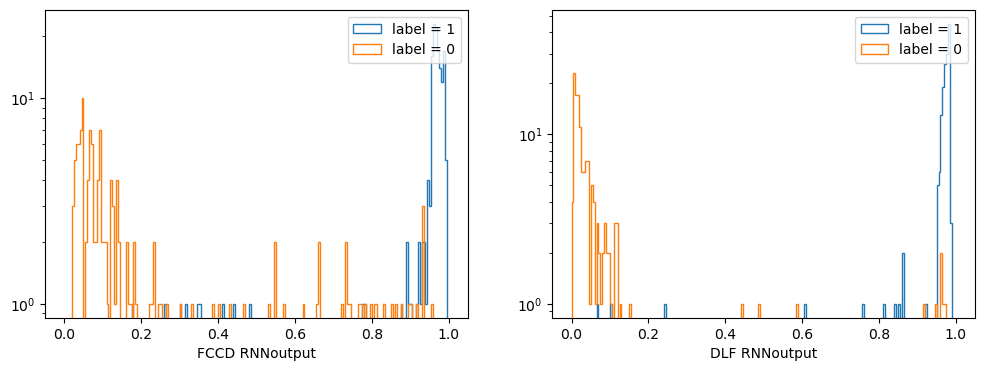

accuracy_FCCD:  0.87
accuracy_DLF:  0.9666666666666667

EPOCH:  26 / 30
Training network...
Epoch [26/30], Iter [175/175] Loss: 0.2110
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.91it/s]


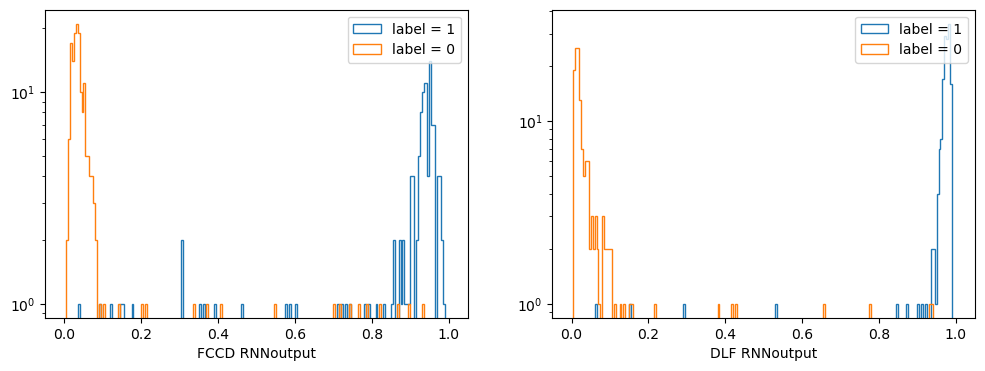

accuracy_FCCD:  0.9266666666666666
accuracy_DLF:  0.9766666666666667

EPOCH:  27 / 30
Training network...
Epoch [27/30], Iter [175/175] Loss: 0.3956
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.13it/s]


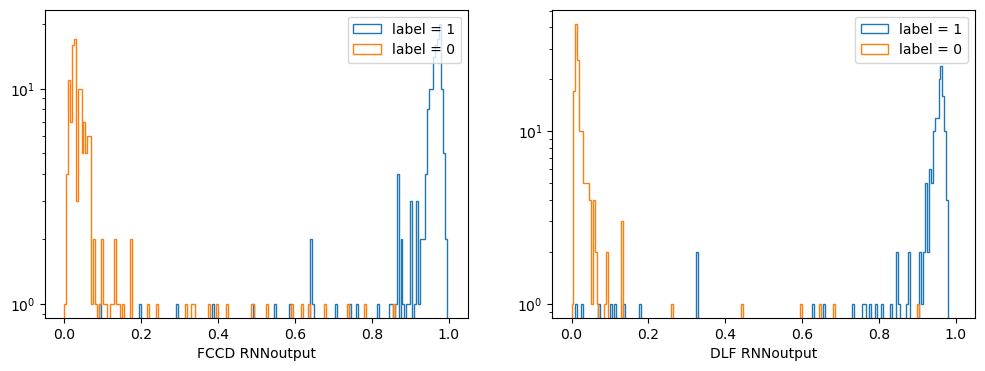

accuracy_FCCD:  0.9566666666666667
accuracy_DLF:  0.9566666666666667

EPOCH:  28 / 30
Training network...
Epoch [28/30], Iter [175/175] Loss: 0.0536
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.00it/s]


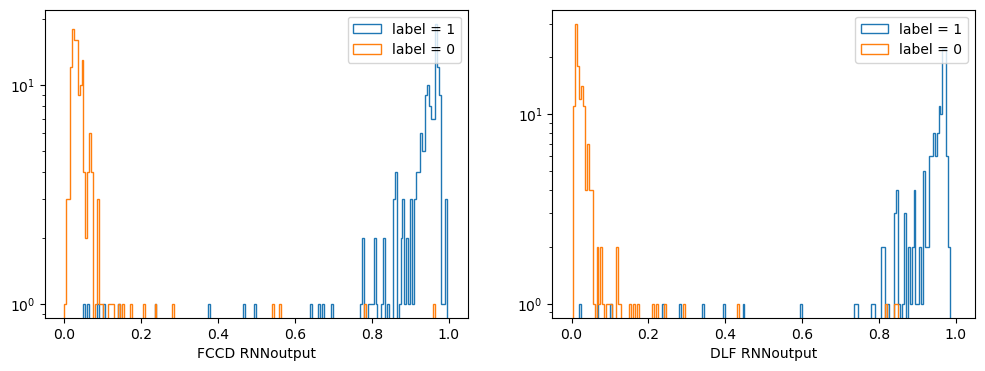

accuracy_FCCD:  0.9566666666666667
accuracy_DLF:  0.9633333333333334

EPOCH:  29 / 30
Training network...
Epoch [29/30], Iter [175/175] Loss: 0.4696
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.00it/s]


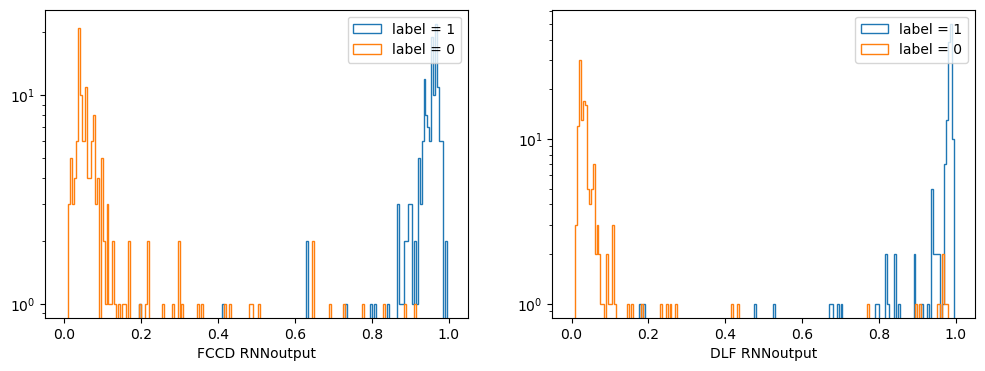

accuracy_FCCD:  0.9633333333333334
accuracy_DLF:  0.96

EPOCH:  30 / 30
Training network...
Epoch [30/30], Iter [175/175] Loss: 0.6616
Testing/Validating...


100%|██████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 12.19it/s]


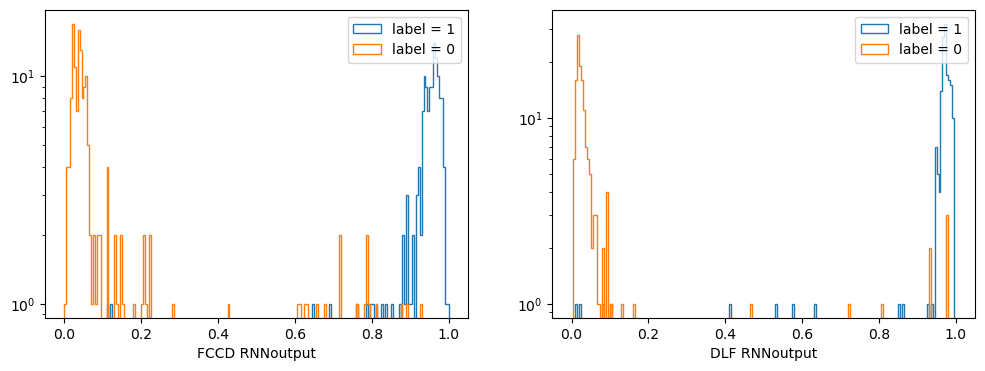

accuracy_FCCD:  0.9366666666666666
accuracy_DLF:  0.96

Training complete.

Saving RNN at /unix/legend/abi/ML_DL/saved_models/RNN_30epochs_LR0.005_maxFCCDdiff0.5mm/RNN_30epochs_LR0.005_maxFCCDdiff0.5mm.pkl


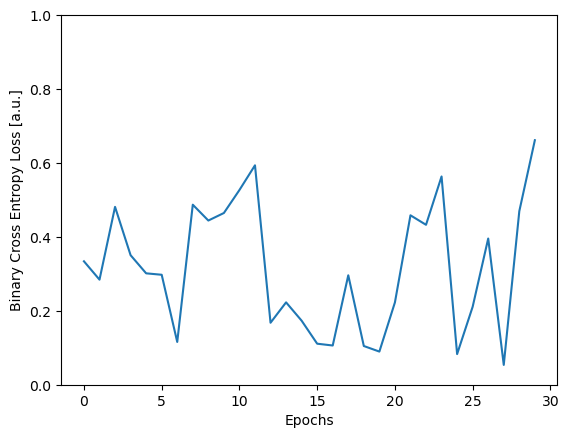

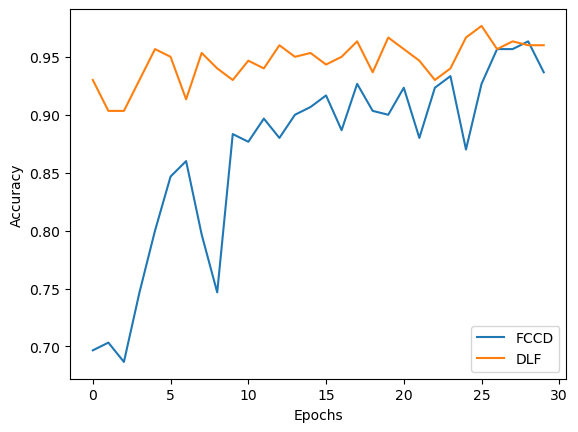

In [17]:
#Training - do not rerun if not necesarry
# torch.cuda.empty_cache()
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)


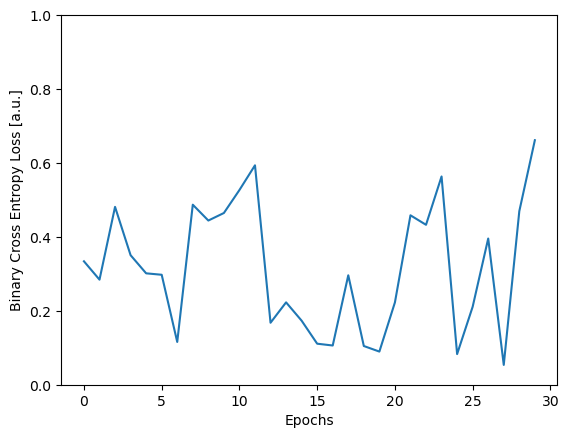

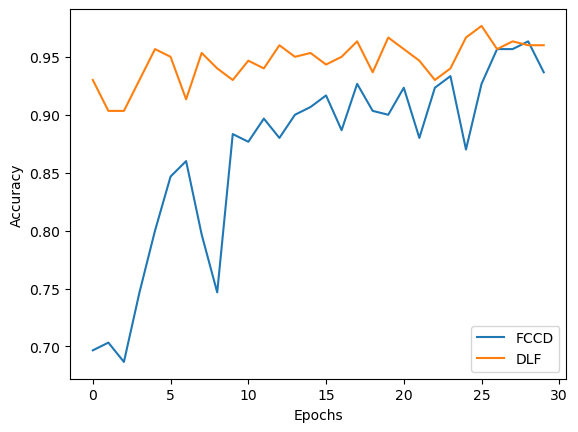

In [22]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing

In [29]:
# Load saved model
RNNclassifier_maxFCCDdiff0_5mm = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_5mm.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCdiffD0_5mm.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.23it/s]


FCCD accuracies: 
total:  300
TP:  151
FP:  11
TN:  131
FN:  7
accuracy:  0.94
precision:  0.9320987654320988
recall:  0.9556962025316456

DLF accuracies: 
total:  300
TP:  139
FP:  16
TN:  143
FN:  2
accuracy:  0.94
precision:  0.896774193548387
recall:  0.9858156028368794
Total # misclassified trials FCCD:  18  / 300
Total # misclassified trials DLF:  18  / 300


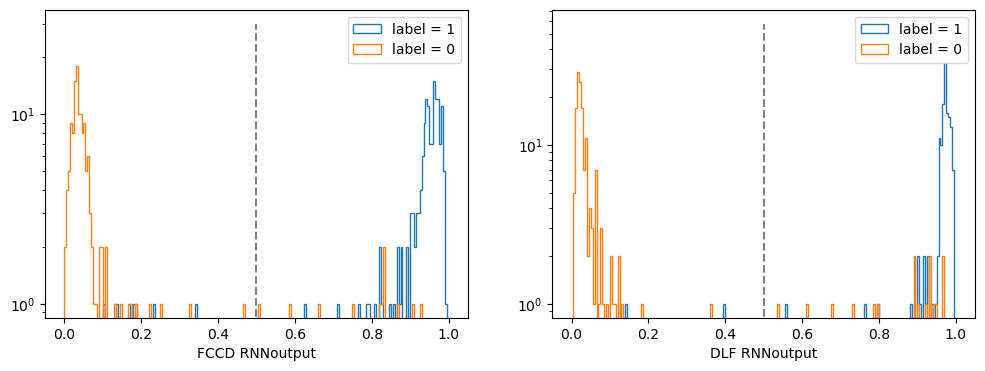

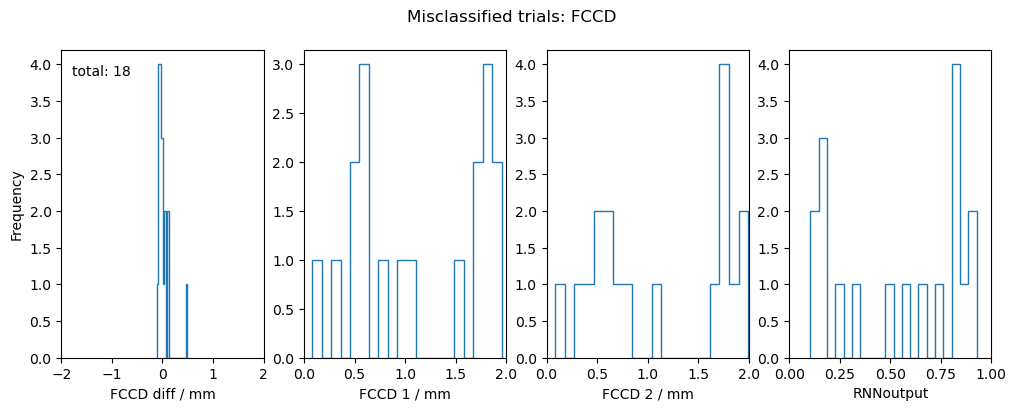

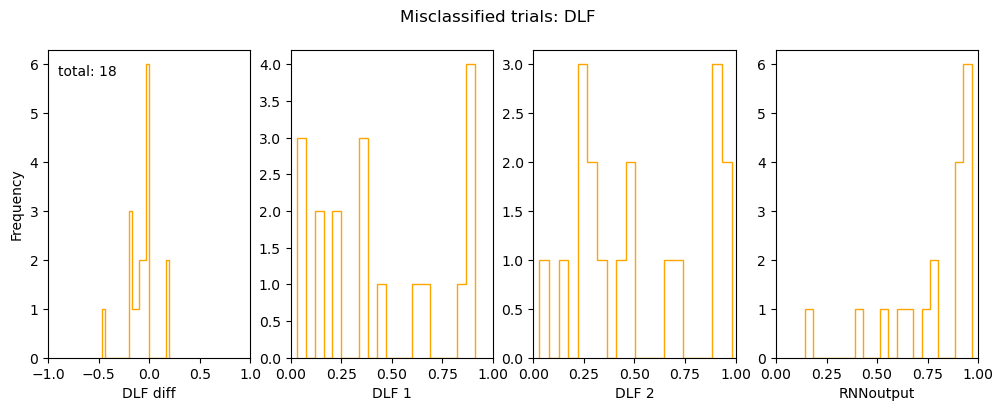

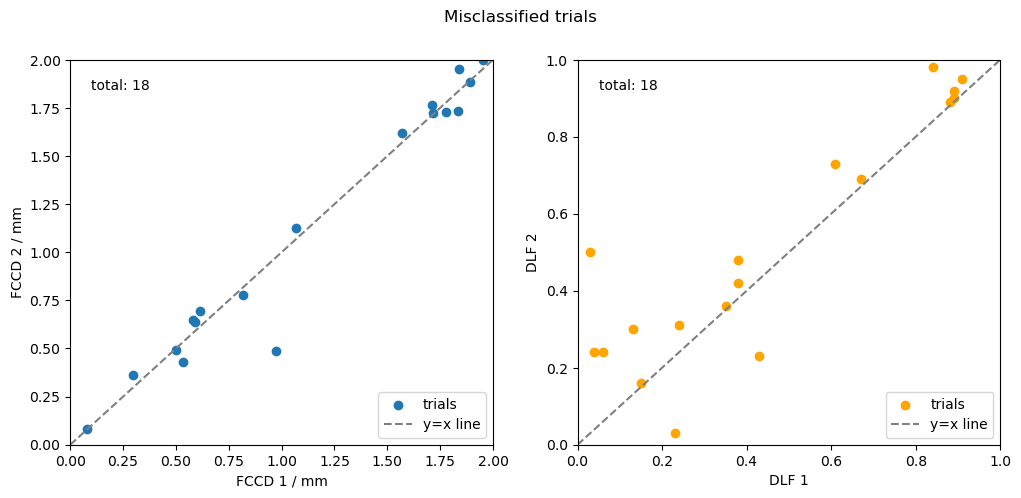

In [30]:
#testing
accuracies_maxFCCDdiff0_5mm = test_RNN(RNNclassifier_maxFCCDdiff0_5mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


## Investigate Attention

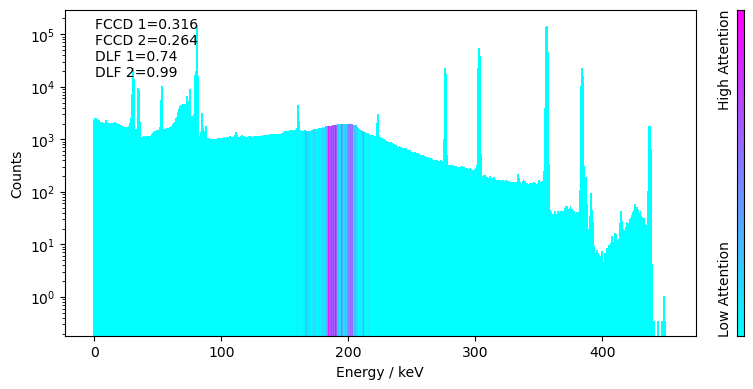

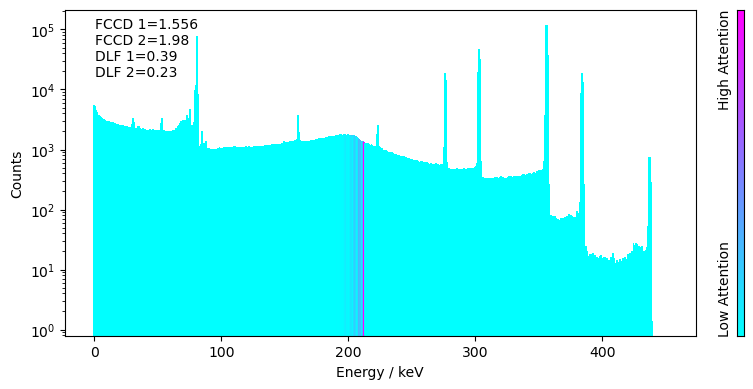

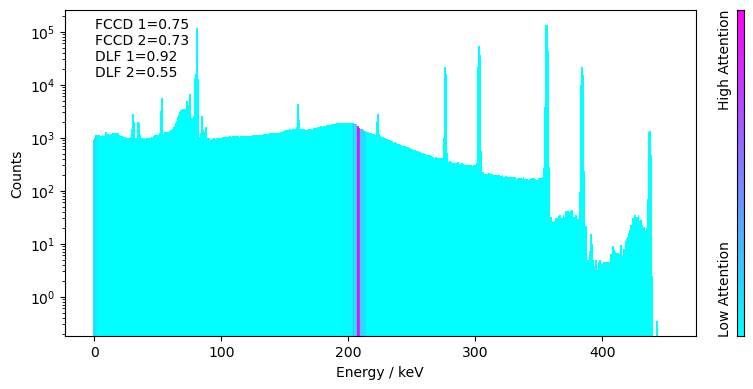

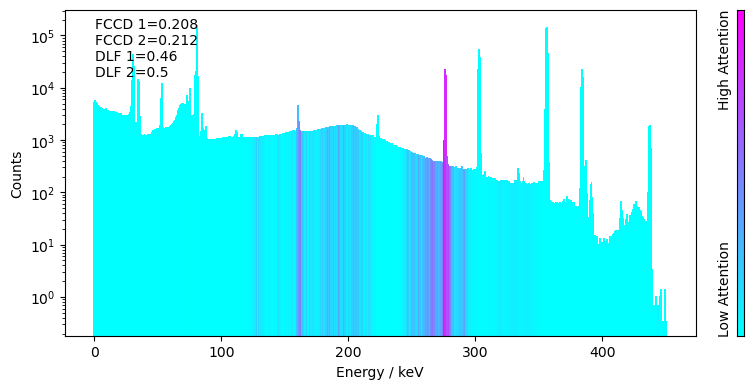

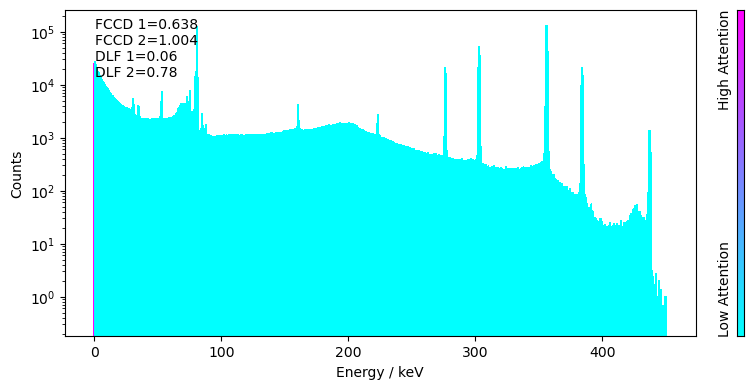

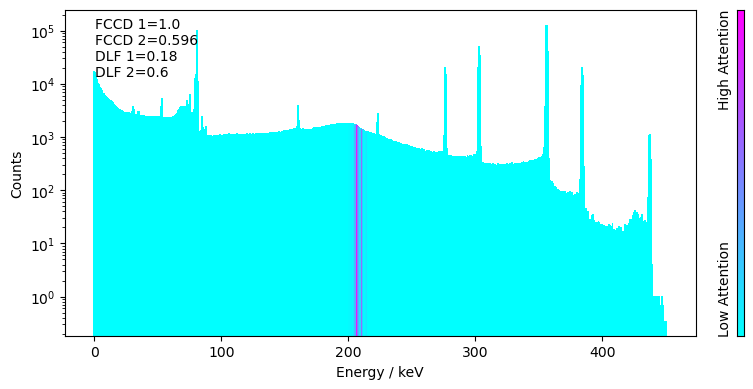

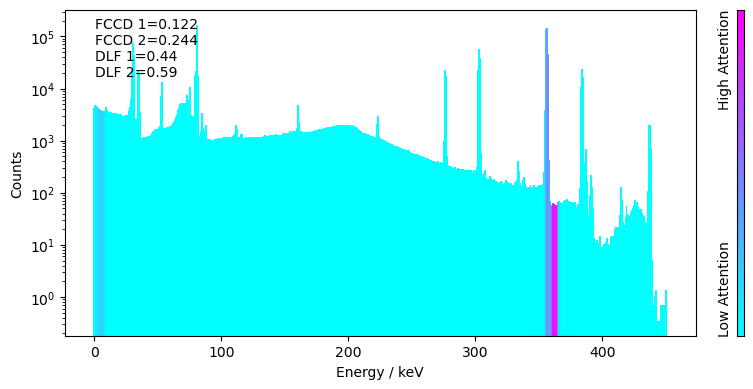

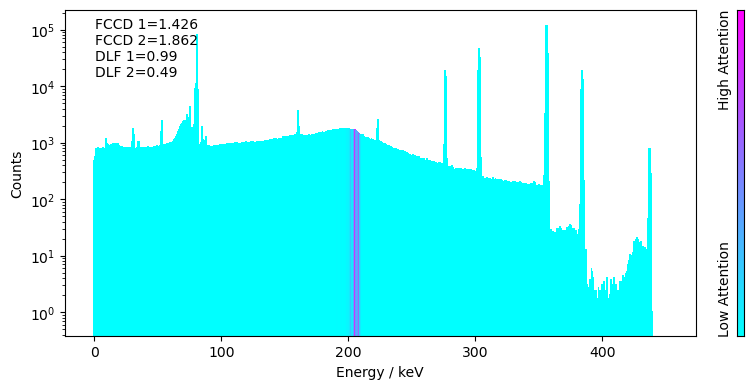

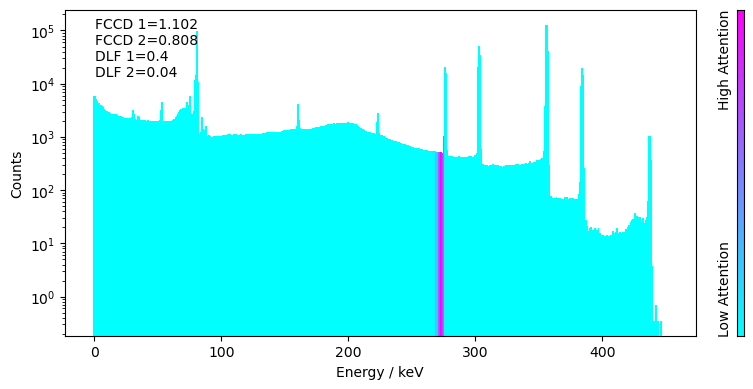

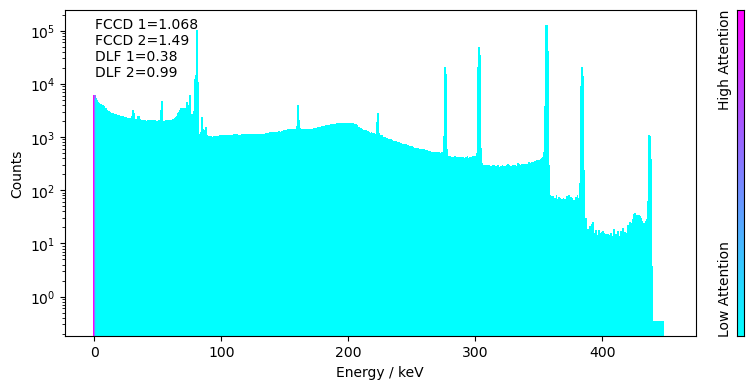

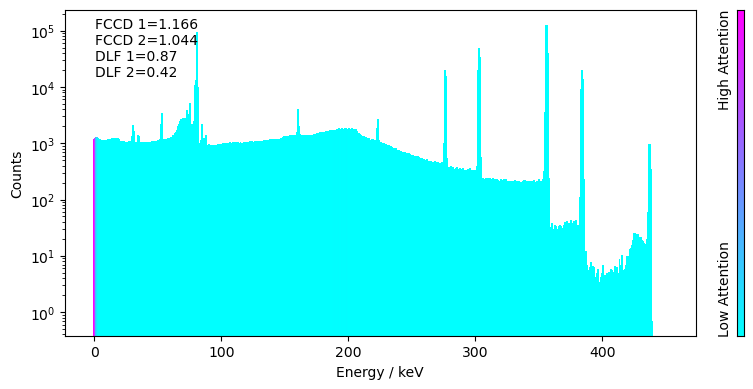

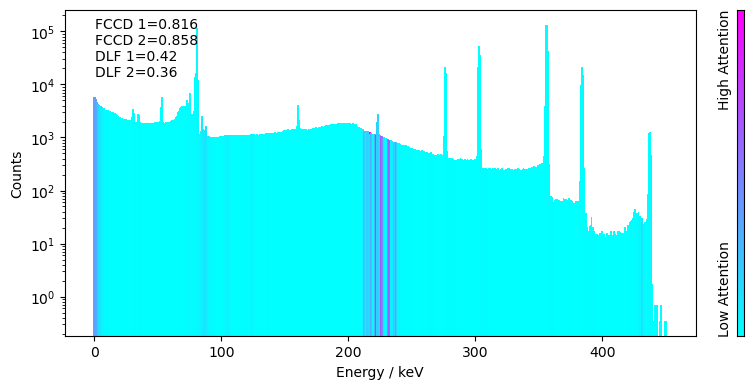

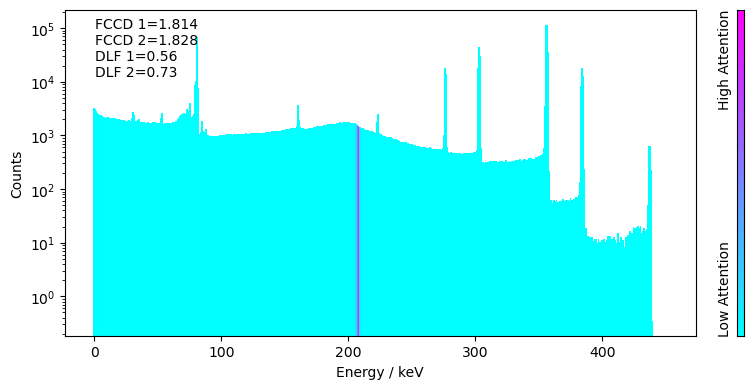

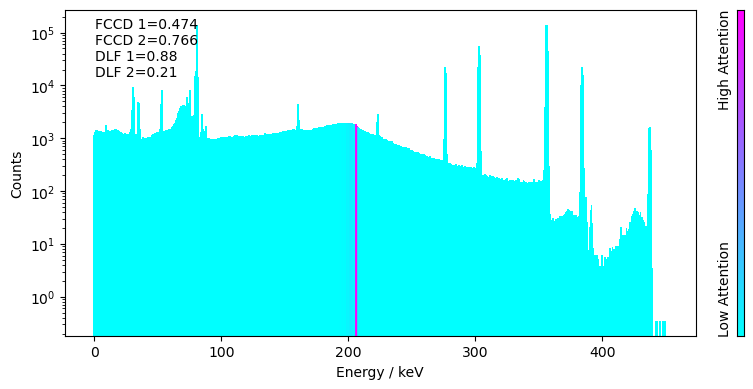

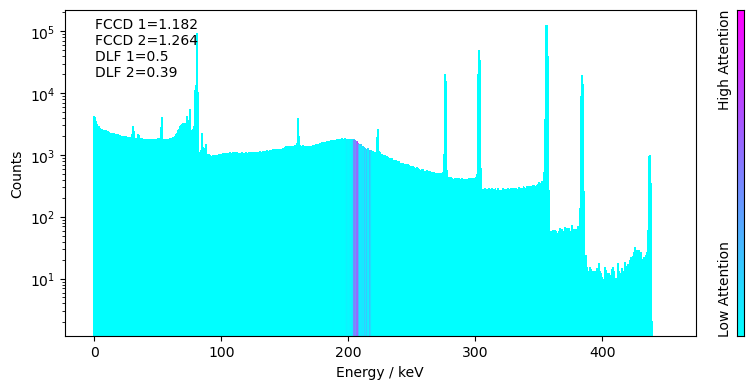

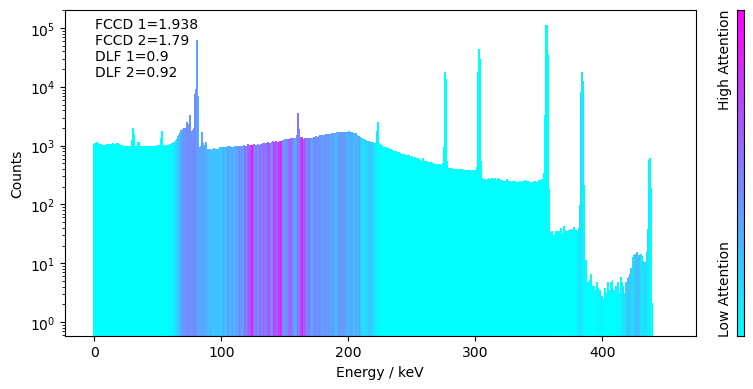

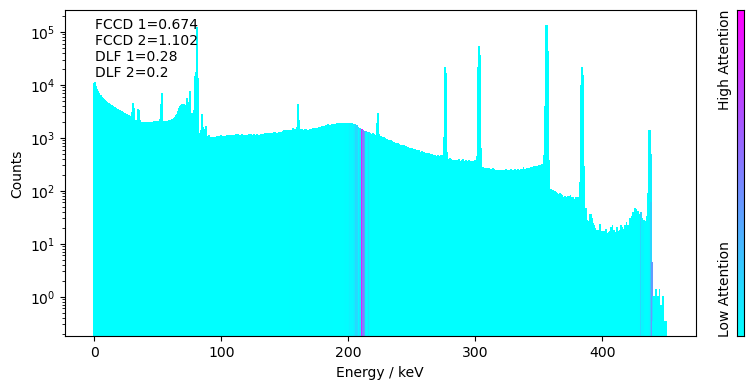

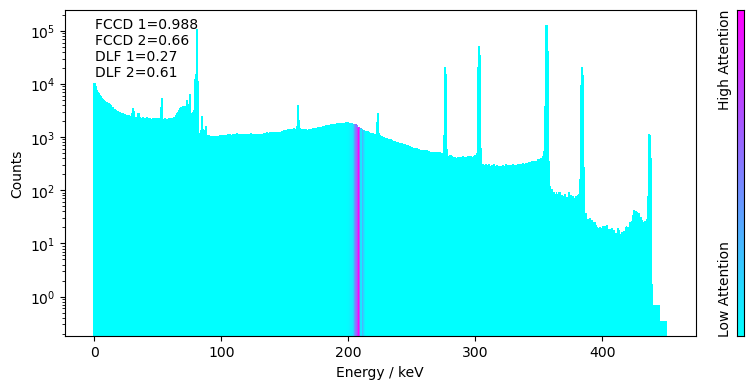

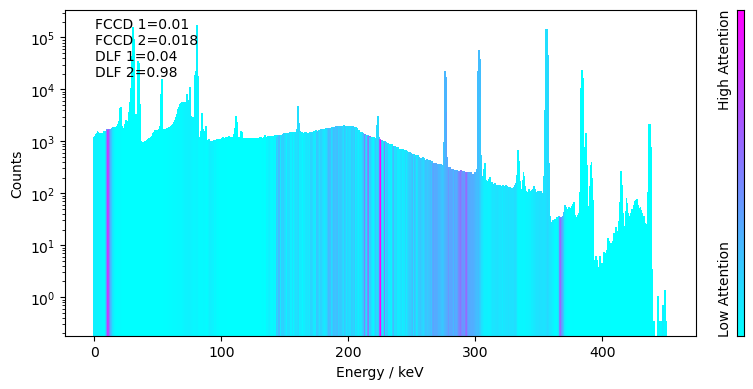

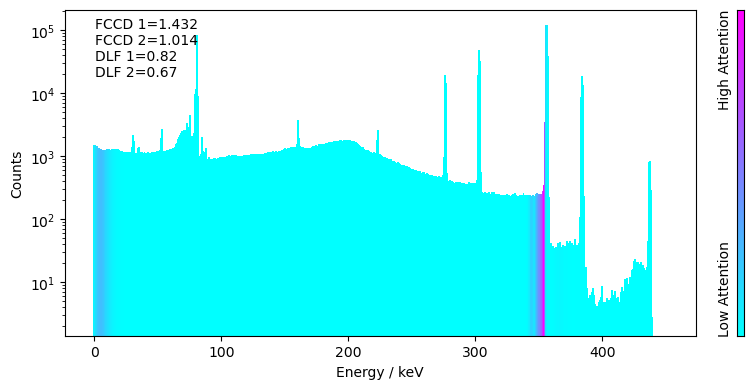

In [31]:
#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

# TRAINING 3: restircted dataset - Max FCCD diff = 0.25 mm

Only train on FCCDs with a max diff of 0.25 mm

In [32]:
NUM_EPOCHS = 30 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
maxFCCDdiff = 0.25
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID = "RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

In [33]:
#load dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict)

100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.36it/s]

(1000, 900)


## Training - DO NOT RERUN UNLESS NECESARRY

#params 2106114
Warmup Size: 400
- - - - - - - - - - -

EPOCH:  1 / 30
Training network...
Epoch [1/30], Iter [175/175] Loss: 0.4195
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.73it/s]


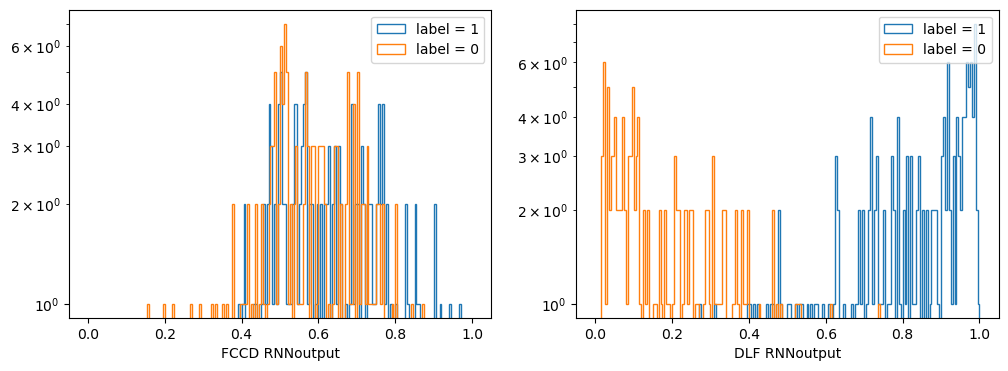

accuracy_FCCD:  0.53
accuracy_DLF:  0.9433333333333334

EPOCH:  2 / 30
Training network...
Epoch [2/30], Iter [175/175] Loss: 0.4633
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.26it/s]


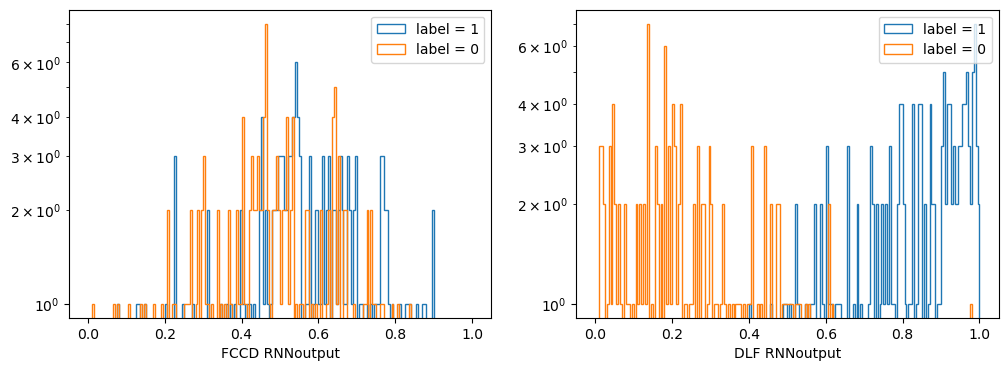

accuracy_FCCD:  0.6533333333333333
accuracy_DLF:  0.9466666666666667

EPOCH:  3 / 30
Training network...
Epoch [3/30], Iter [175/175] Loss: 0.3459
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.40it/s]


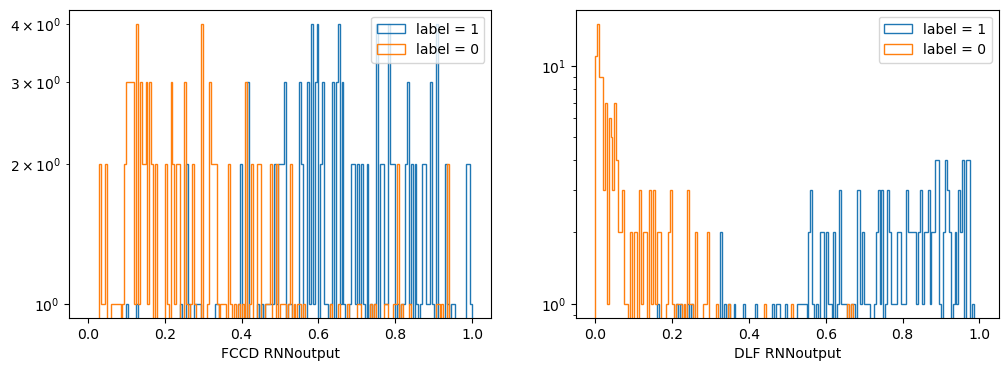

accuracy_FCCD:  0.8
accuracy_DLF:  0.9366666666666666

EPOCH:  4 / 30
Training network...
Epoch [4/30], Iter [175/175] Loss: 0.4010
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.49it/s]


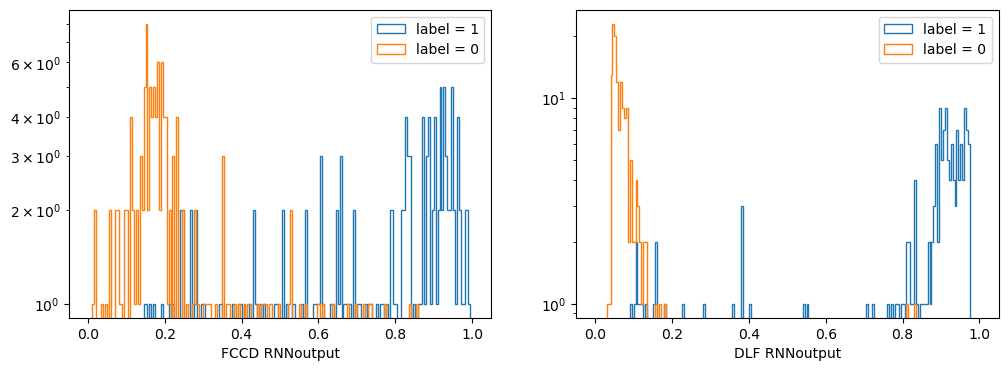

accuracy_FCCD:  0.8366666666666667
accuracy_DLF:  0.93

EPOCH:  5 / 30
Training network...
Epoch [5/30], Iter [175/175] Loss: 0.1640
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.47it/s]


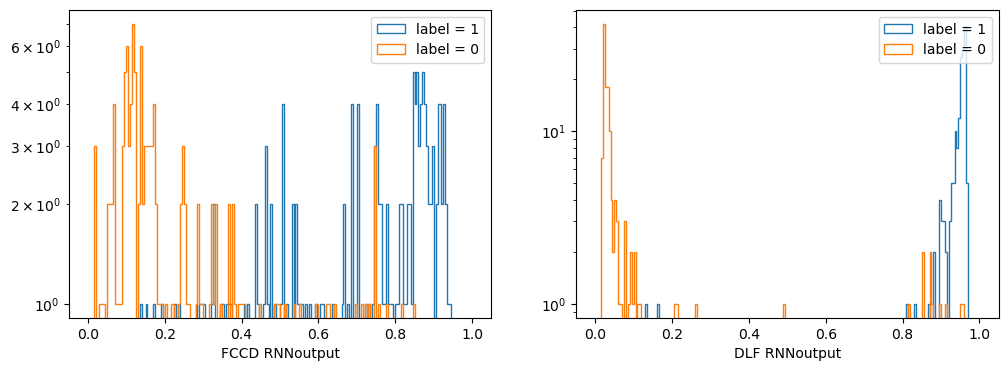

accuracy_FCCD:  0.8333333333333334
accuracy_DLF:  0.96

EPOCH:  6 / 30
Training network...
Epoch [6/30], Iter [175/175] Loss: 0.4799
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.28it/s]


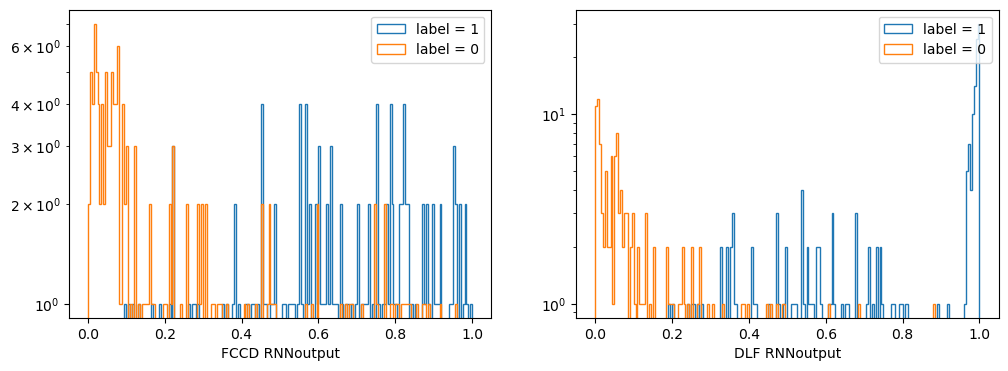

accuracy_FCCD:  0.7866666666666666
accuracy_DLF:  0.89

EPOCH:  7 / 30
Training network...
Epoch [7/30], Iter [175/175] Loss: 0.4858
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.07it/s]


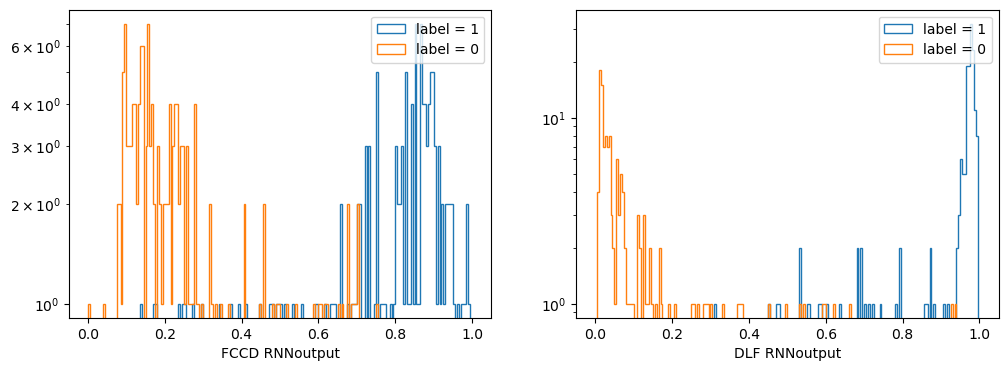

accuracy_FCCD:  0.8833333333333333
accuracy_DLF:  0.96

EPOCH:  8 / 30
Training network...
Epoch [8/30], Iter [175/175] Loss: 0.3320
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.92it/s]


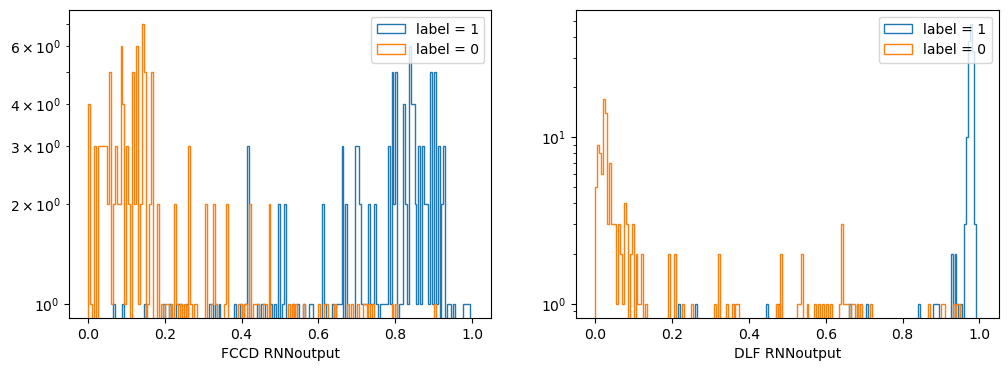

accuracy_FCCD:  0.85
accuracy_DLF:  0.8933333333333333

EPOCH:  9 / 30
Training network...
Epoch [9/30], Iter [175/175] Loss: 0.3077
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.14it/s]


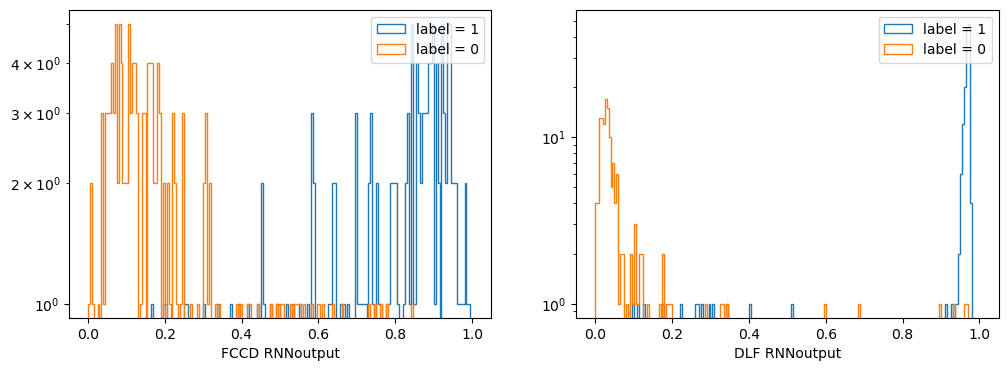

accuracy_FCCD:  0.88
accuracy_DLF:  0.94

EPOCH:  10 / 30
Training network...
Epoch [10/30], Iter [175/175] Loss: 0.1139
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.17it/s]


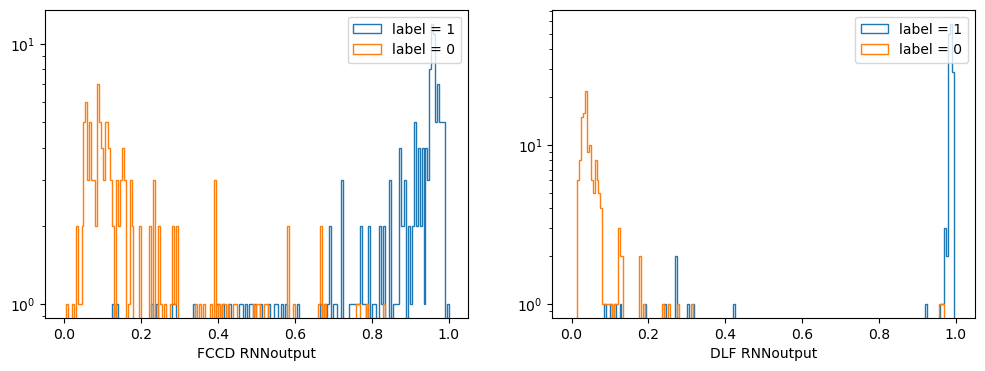

accuracy_FCCD:  0.89
accuracy_DLF:  0.9533333333333334

EPOCH:  11 / 30
Training network...
Epoch [11/30], Iter [175/175] Loss: 0.4210
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.73it/s]


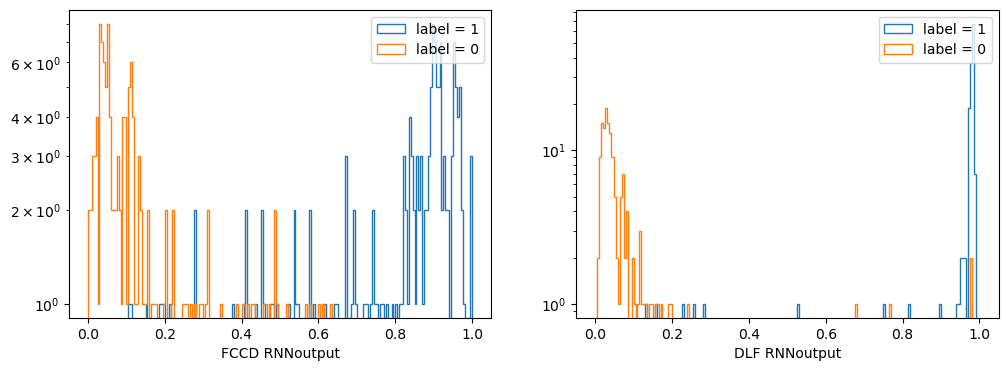

accuracy_FCCD:  0.9133333333333333
accuracy_DLF:  0.97

EPOCH:  12 / 30
Training network...
Epoch [12/30], Iter [175/175] Loss: 0.3611
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.85it/s]


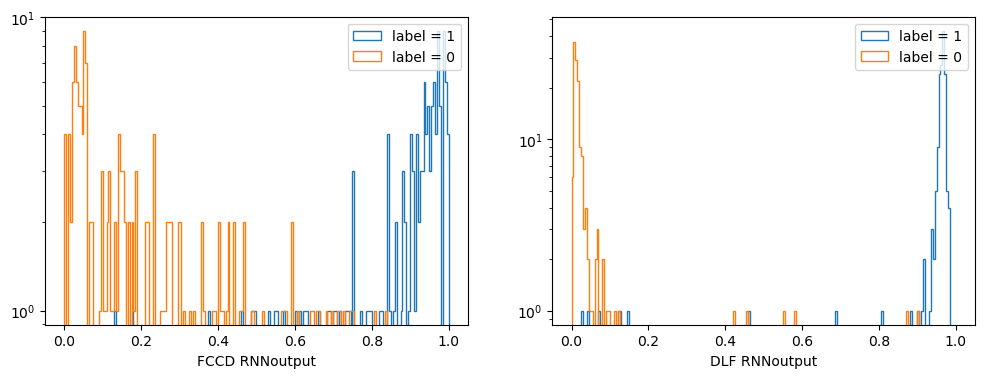

accuracy_FCCD:  0.9066666666666666
accuracy_DLF:  0.9633333333333334

EPOCH:  13 / 30
Training network...
Epoch [13/30], Iter [175/175] Loss: 0.4949
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.98it/s]


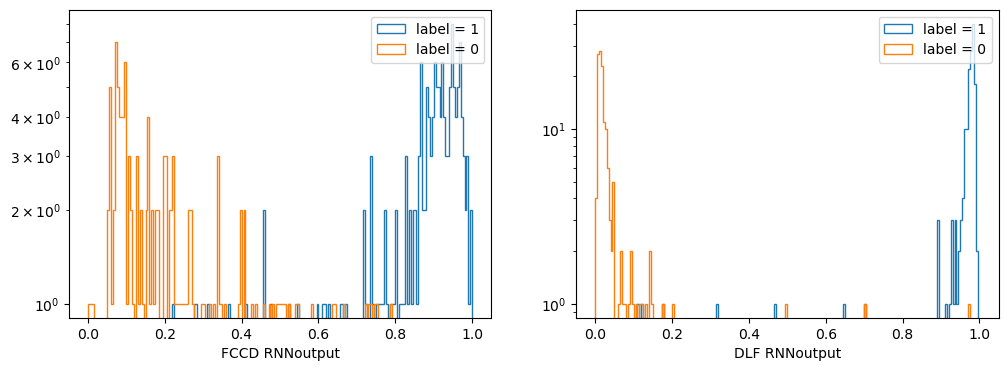

accuracy_FCCD:  0.9166666666666666
accuracy_DLF:  0.9733333333333334

EPOCH:  14 / 30
Training network...
Epoch [14/30], Iter [175/175] Loss: 0.1646
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.37it/s]


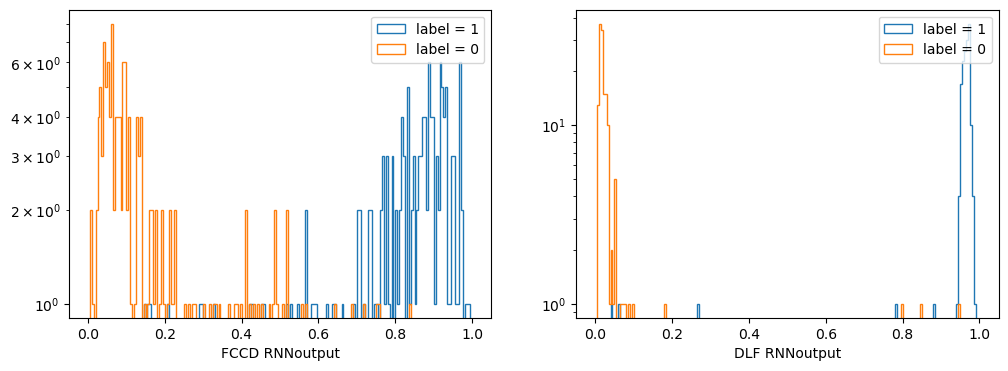

accuracy_FCCD:  0.9266666666666666
accuracy_DLF:  0.98

EPOCH:  15 / 30
Training network...
Epoch [15/30], Iter [175/175] Loss: 0.1870
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.44it/s]


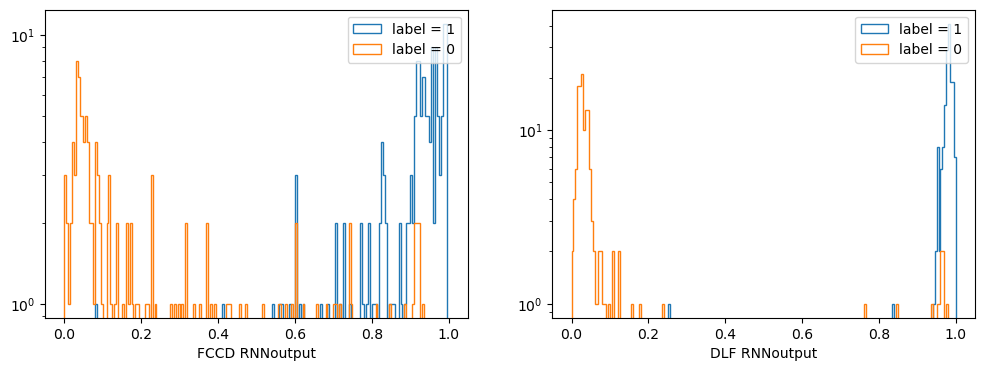

accuracy_FCCD:  0.9033333333333333
accuracy_DLF:  0.9633333333333334

EPOCH:  16 / 30
Training network...
Epoch [16/30], Iter [175/175] Loss: 0.2527
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.29it/s]


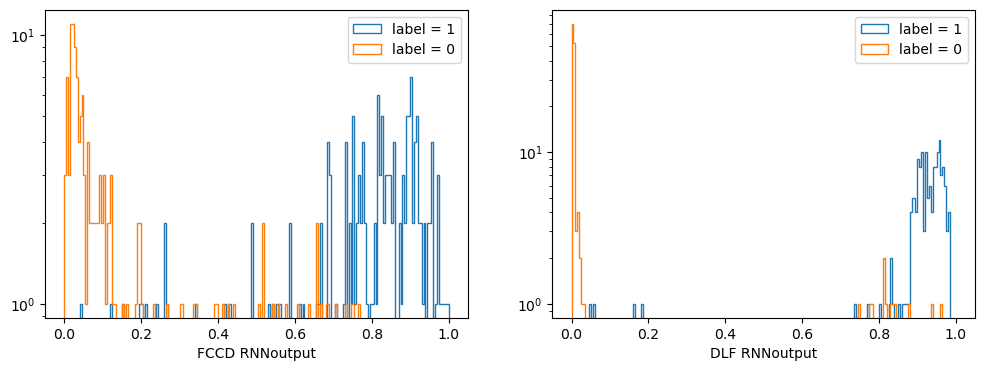

accuracy_FCCD:  0.8866666666666667
accuracy_DLF:  0.9466666666666667

EPOCH:  17 / 30
Training network...
Epoch [17/30], Iter [175/175] Loss: 0.3016
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.46it/s]


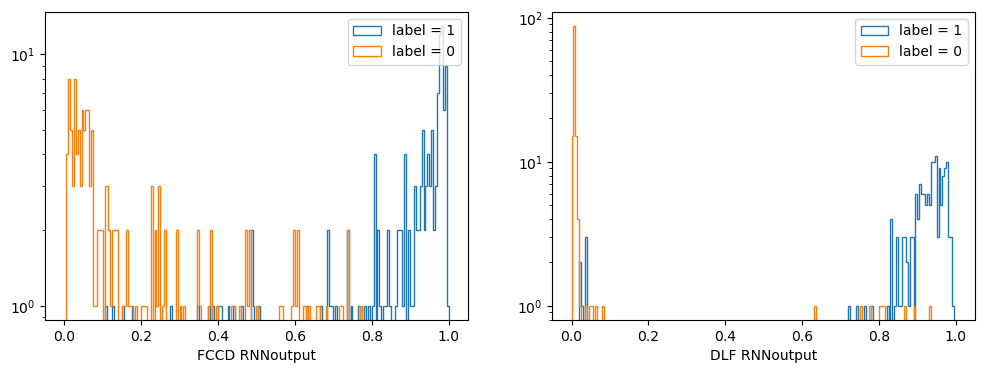

accuracy_FCCD:  0.88
accuracy_DLF:  0.95

EPOCH:  18 / 30
Training network...
Epoch [18/30], Iter [175/175] Loss: 0.1533
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.44it/s]


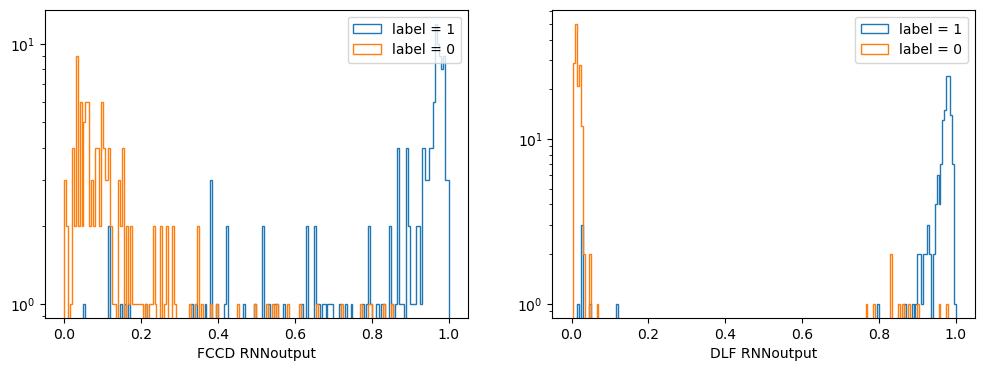

accuracy_FCCD:  0.8966666666666666
accuracy_DLF:  0.9466666666666667

EPOCH:  19 / 30
Training network...
Epoch [19/30], Iter [175/175] Loss: 0.1229
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.50it/s]


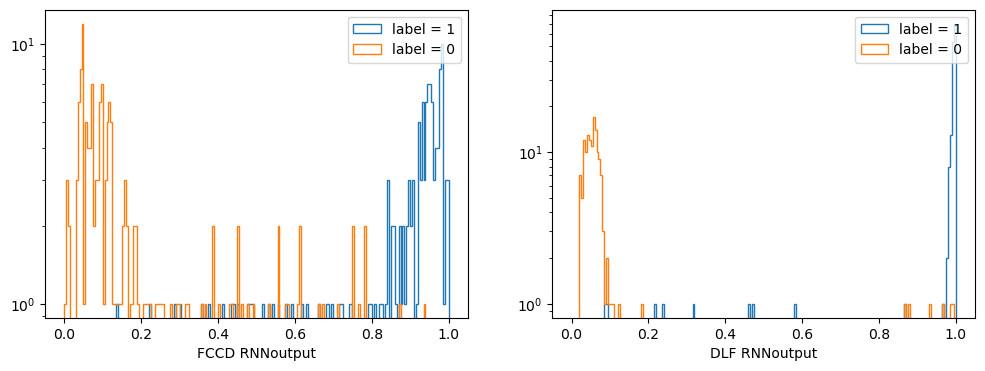

accuracy_FCCD:  0.8933333333333333
accuracy_DLF:  0.9566666666666667

EPOCH:  20 / 30
Training network...
Epoch [20/30], Iter [175/175] Loss: 0.2406
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.25it/s]


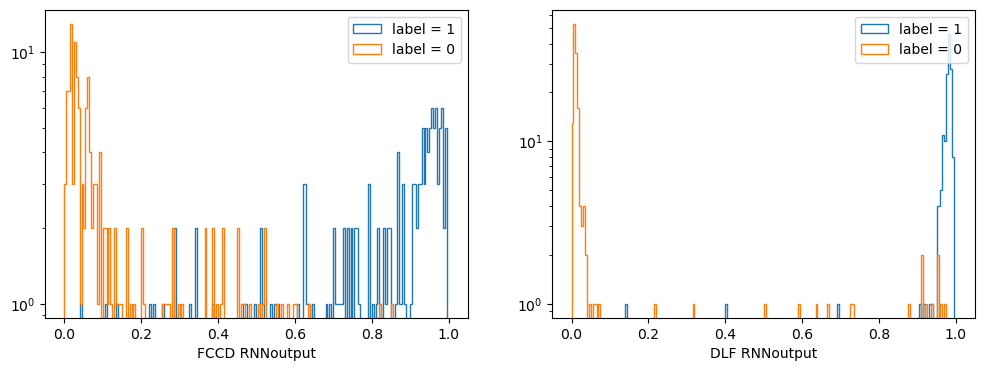

accuracy_FCCD:  0.91
accuracy_DLF:  0.9433333333333334

EPOCH:  21 / 30
Training network...
Epoch [21/30], Iter [175/175] Loss: 0.3875
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.20it/s]


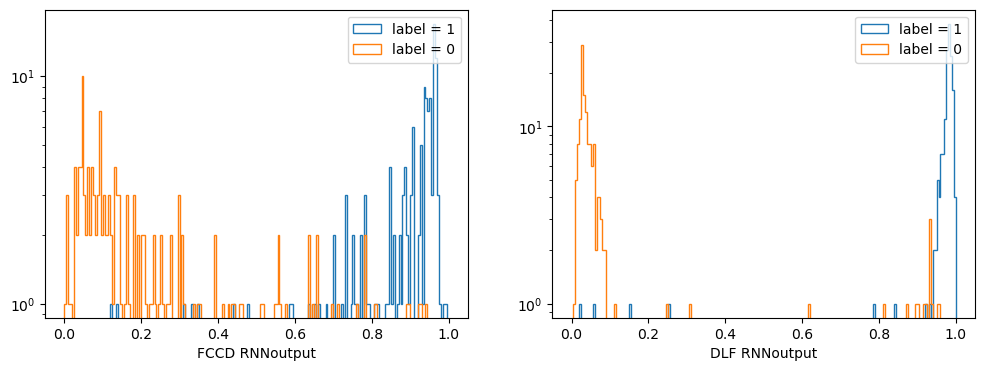

accuracy_FCCD:  0.8933333333333333
accuracy_DLF:  0.9433333333333334

EPOCH:  22 / 30
Training network...
Epoch [22/30], Iter [175/175] Loss: 0.0878
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 12.07it/s]


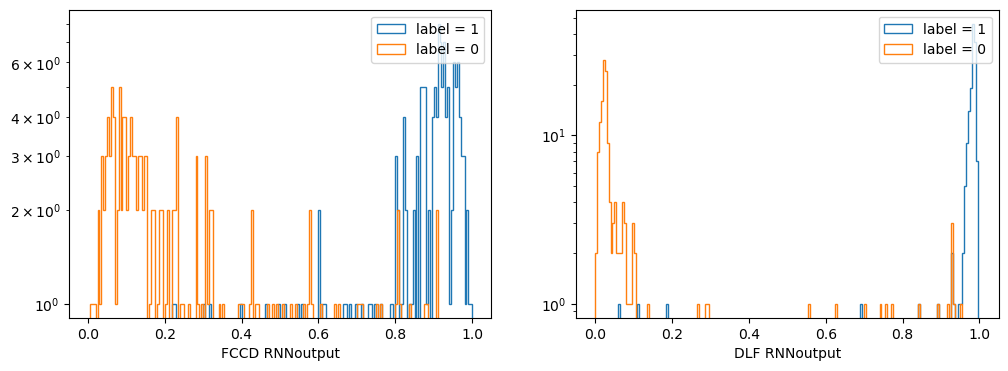

accuracy_FCCD:  0.8933333333333333
accuracy_DLF:  0.9433333333333334

EPOCH:  23 / 30
Training network...
Epoch [23/30], Iter [175/175] Loss: 0.1285
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.89it/s]


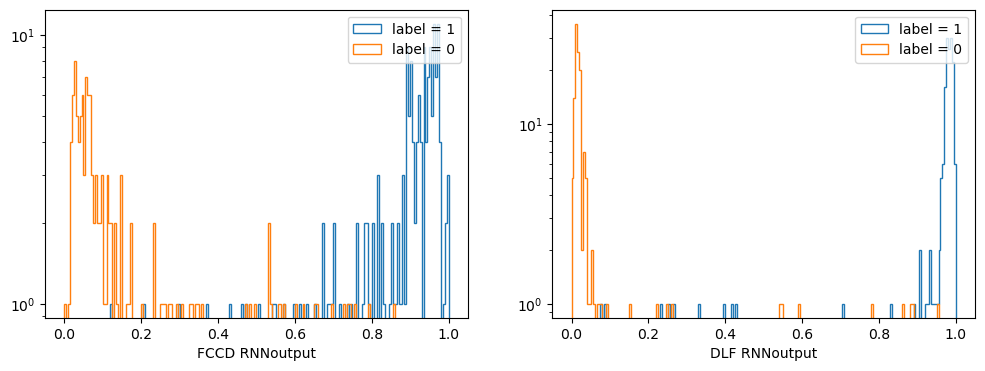

accuracy_FCCD:  0.92
accuracy_DLF:  0.9433333333333334

EPOCH:  24 / 30
Training network...
Epoch [24/30], Iter [175/175] Loss: 0.0572
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.99it/s]


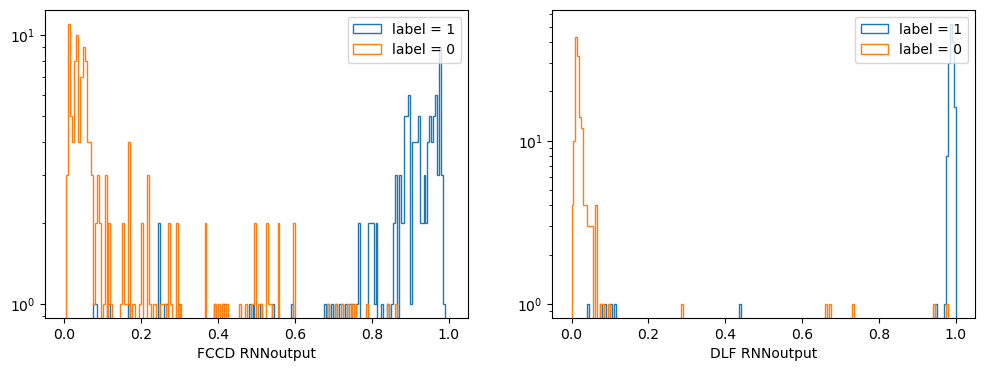

accuracy_FCCD:  0.8866666666666667
accuracy_DLF:  0.9633333333333334

EPOCH:  25 / 30
Training network...
Epoch [25/30], Iter [175/175] Loss: 0.0655
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.78it/s]


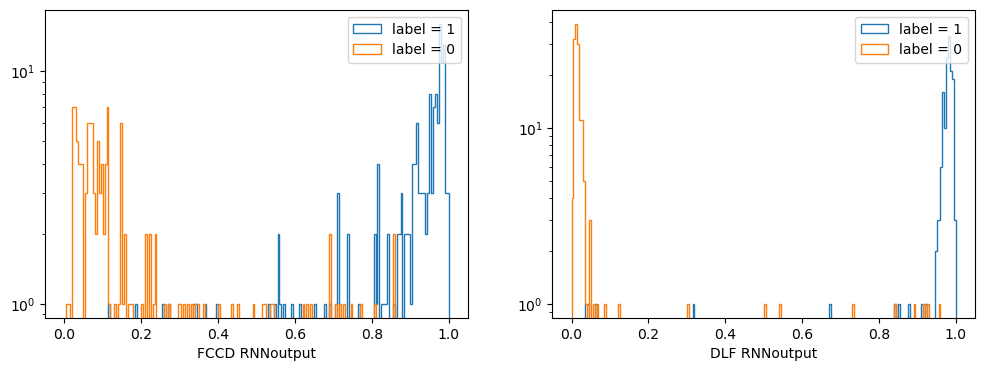

accuracy_FCCD:  0.9166666666666666
accuracy_DLF:  0.96

EPOCH:  26 / 30
Training network...
Epoch [26/30], Iter [175/175] Loss: 0.4688
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.68it/s]


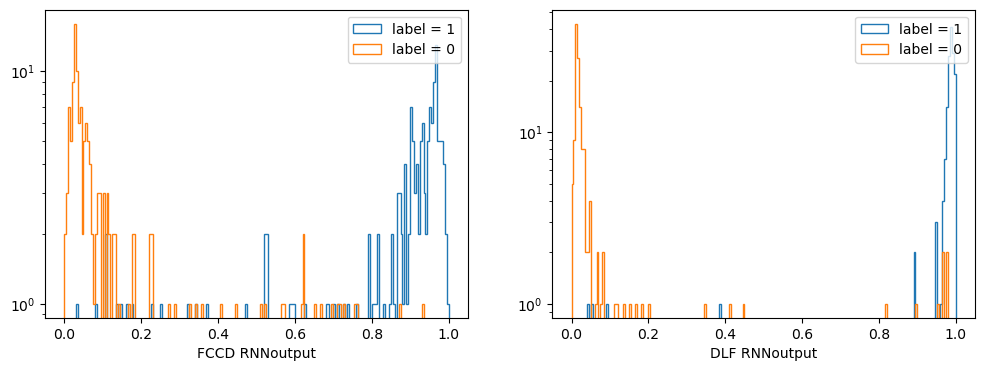

accuracy_FCCD:  0.8966666666666666
accuracy_DLF:  0.9633333333333334

EPOCH:  27 / 30
Training network...
Epoch [27/30], Iter [175/175] Loss: 0.1252
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.56it/s]


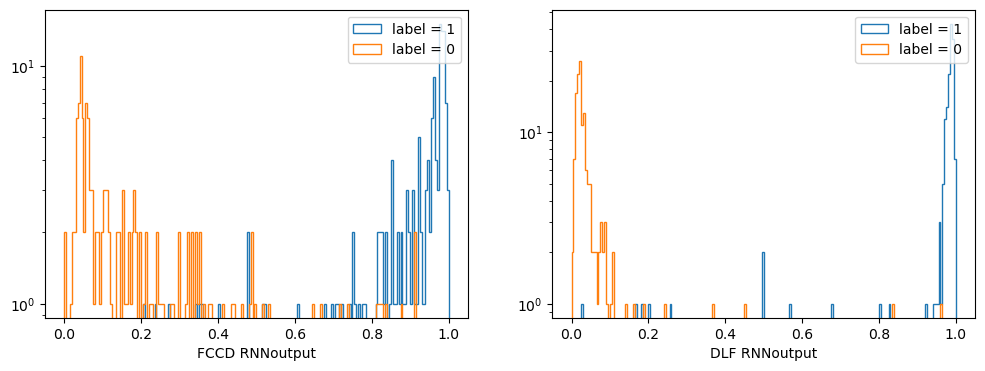

accuracy_FCCD:  0.9233333333333333
accuracy_DLF:  0.97

EPOCH:  28 / 30
Training network...
Epoch [28/30], Iter [175/175] Loss: 0.5584
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.74it/s]


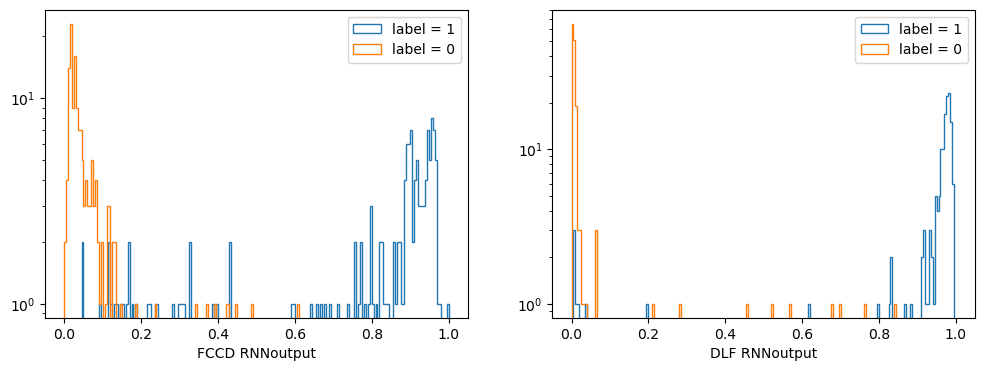

accuracy_FCCD:  0.8966666666666666
accuracy_DLF:  0.9566666666666667

EPOCH:  29 / 30
Training network...
Epoch [29/30], Iter [175/175] Loss: 0.3777
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.44it/s]


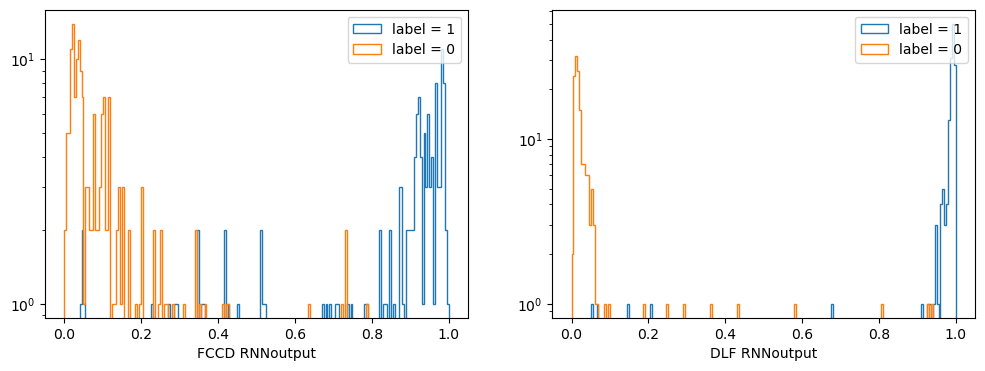

accuracy_FCCD:  0.93
accuracy_DLF:  0.9733333333333334

EPOCH:  30 / 30
Training network...
Epoch [30/30], Iter [175/175] Loss: 0.2083
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.23it/s]


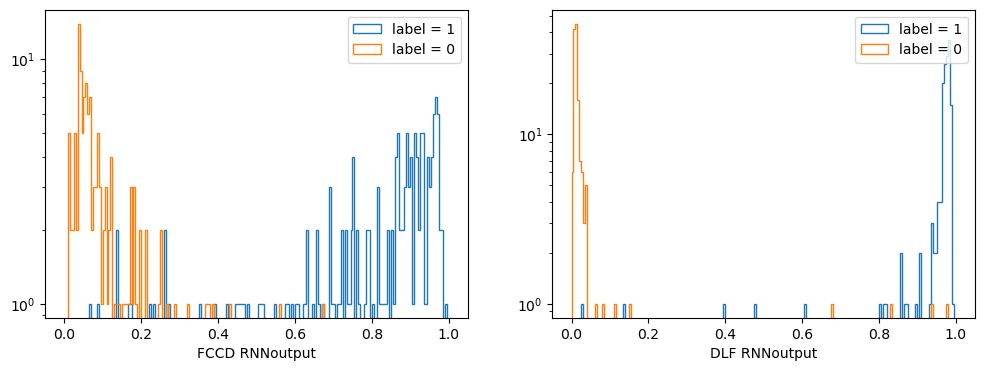

accuracy_FCCD:  0.9266666666666666
accuracy_DLF:  0.9733333333333334

Training complete.

Saving RNN at /unix/legend/abi/ML_DL/saved_models/RNN_30epochs_LR0.005_maxFCCDdiff0.25mm/RNN_30epochs_LR0.005_maxFCCDdiff0.25mm.pkl


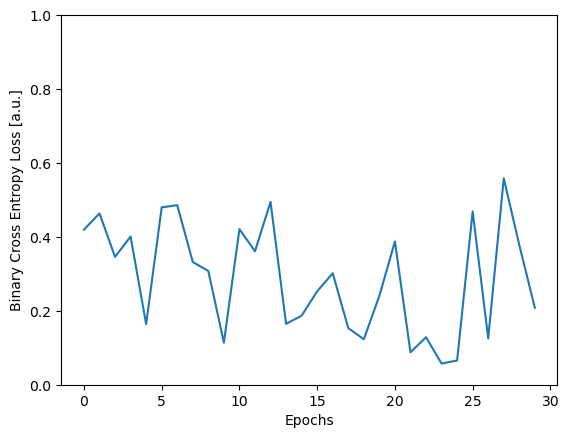

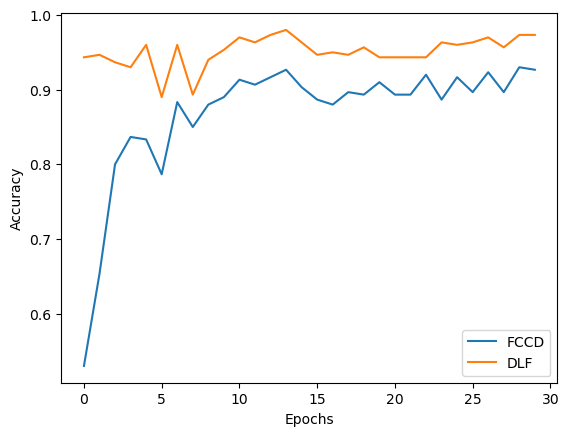

In [34]:
#Training - do not rerun if not necesarry
# torch.cuda.empty_cache()
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)

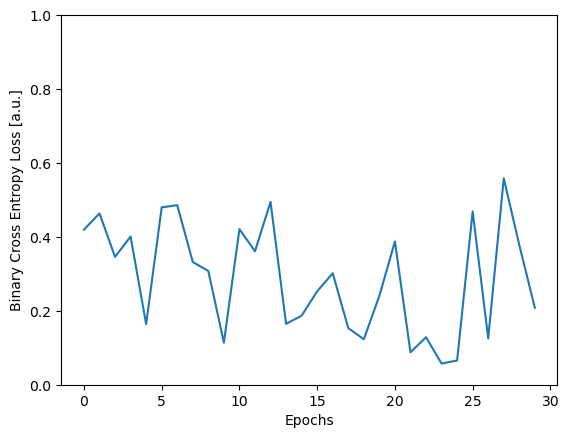

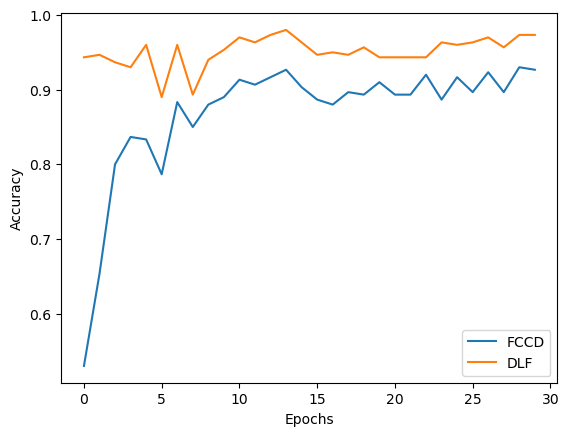

In [35]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing

In [36]:
# Load saved model
RNNclassifier_maxFCCDdiff0_25mm = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_25mm.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_25mm.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

 12%|████████▊                                                                | 9/75 [00:00<00:06, 10.09it/s]

DLF and FCCD misclassified for same trial:
j:  7 , i:  1
FCCD1:  0.532 , FCCD2:  0.674 , FCCD_diff:  -0.14200000000000002 , RNNoutput:  0.75907964
DLF1:  0.29 , DLF2:  0.28 , DLF_diff:  0.009999999999999953 , RNNoutput:  0.065571725
DLF and FCCD misclassified for same trial:
j:  8 , i:  0
FCCD1:  0.674 , FCCD2:  0.532 , FCCD_diff:  0.14200000000000002 , RNNoutput:  0.32992327
DLF1:  0.28 , DLF2:  0.29 , DLF_diff:  -0.009999999999999953 , RNNoutput:  0.90662503


 17%|████████████▍                                                           | 13/75 [00:01<00:05, 10.34it/s]

DLF and FCCD misclassified for same trial:
j:  11 , i:  3
FCCD1:  0.214 , FCCD2:  0.202 , FCCD_diff:  0.011999999999999983 , RNNoutput:  0.481122
DLF1:  0.63 , DLF2:  0.64 , DLF_diff:  -0.010000000000000009 , RNNoutput:  0.7987715


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.07it/s]


FCCD accuracies: 
total:  300
TP:  147
FP:  7
TN:  131
FN:  15
accuracy:  0.9266666666666666
precision:  0.9545454545454546
recall:  0.9074074074074074

DLF accuracies: 
total:  300
TP:  141
FP:  7
TN:  147
FN:  5
accuracy:  0.96
precision:  0.9527027027027027
recall:  0.9657534246575342
Total # misclassified trials FCCD:  22  / 300
Total # misclassified trials DLF:  12  / 300


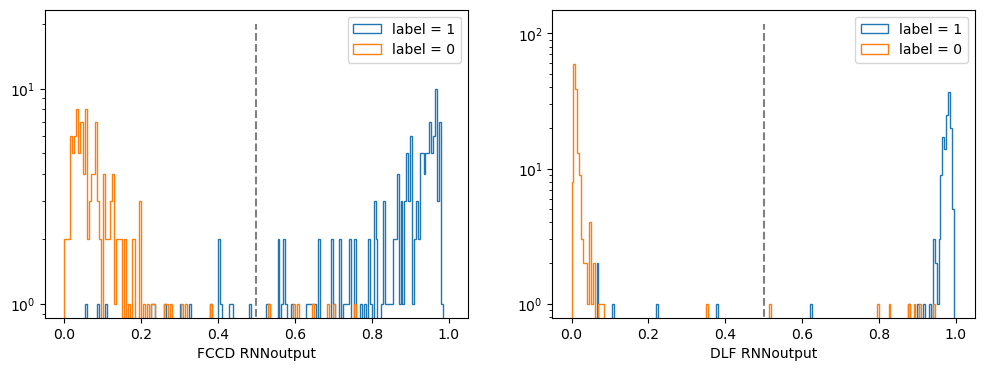

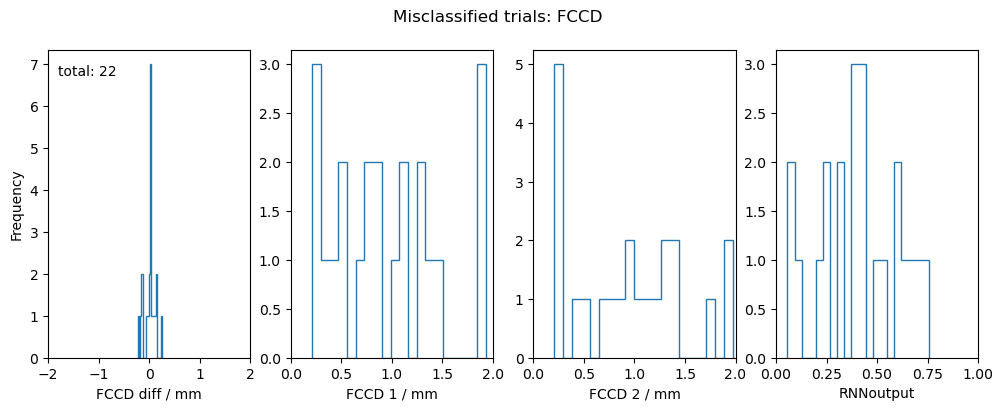

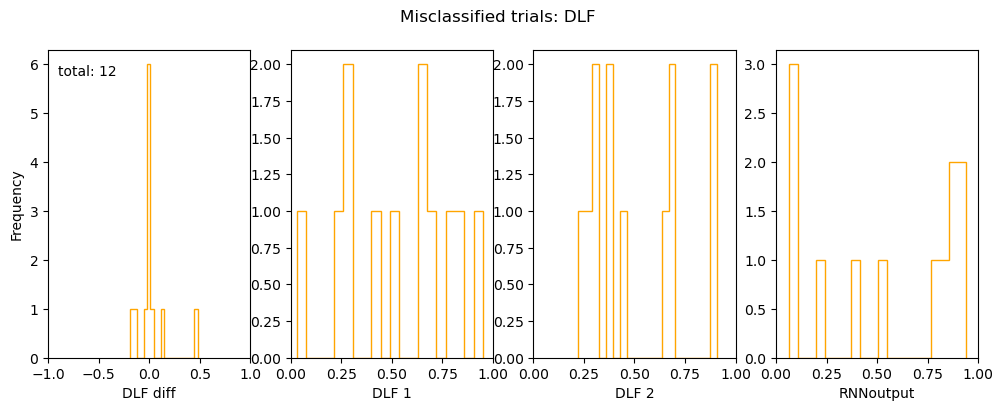

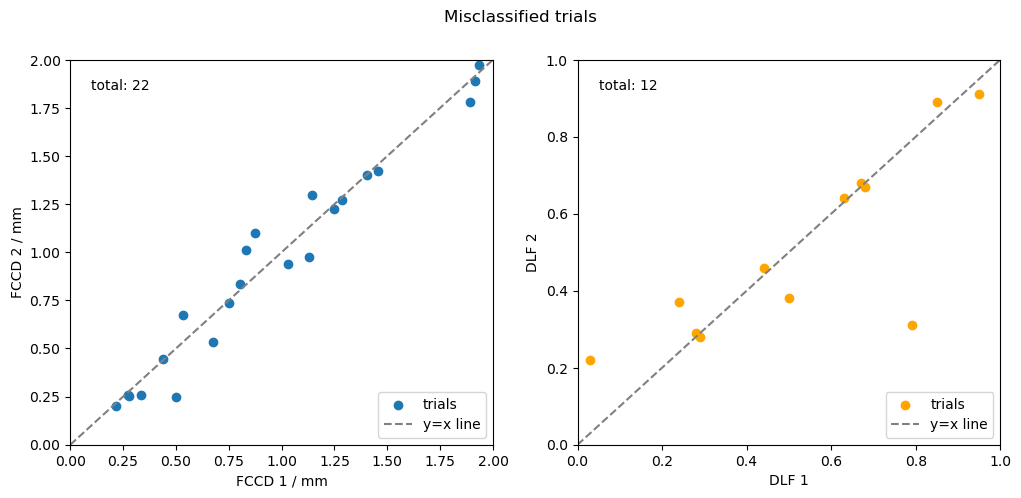

In [37]:
#testing
accuracies_maxFCCDdiff0_25mm = test_RNN(RNNclassifier_maxFCCDdiff0_25mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


## Investigate Attention

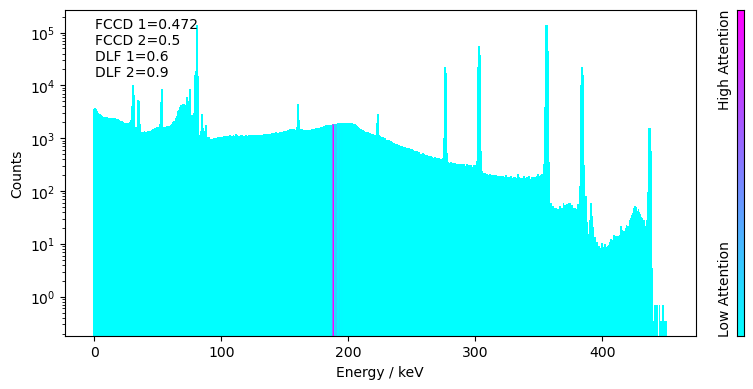

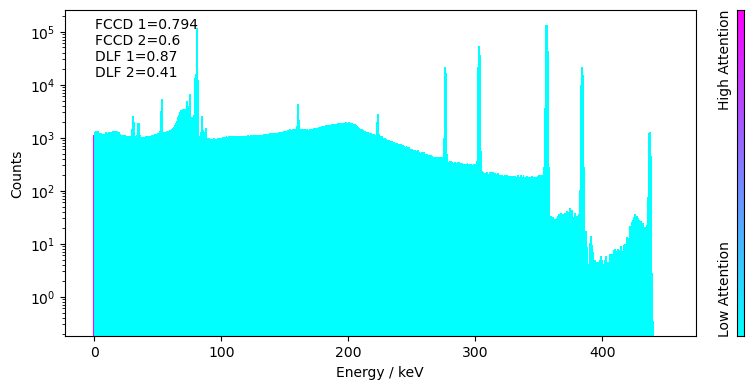

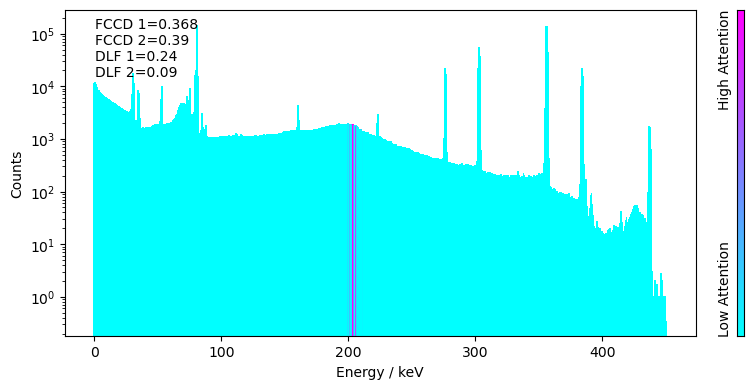

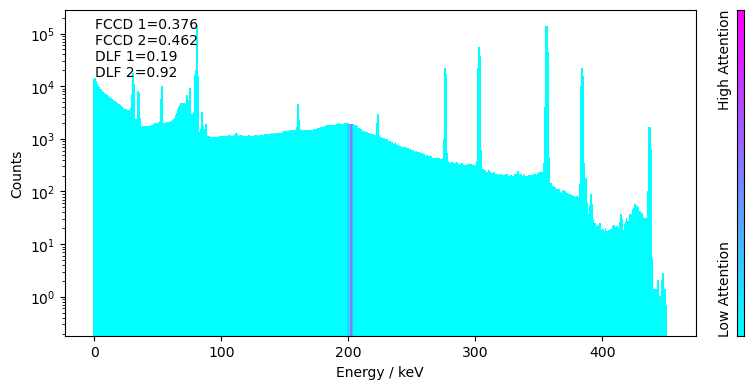

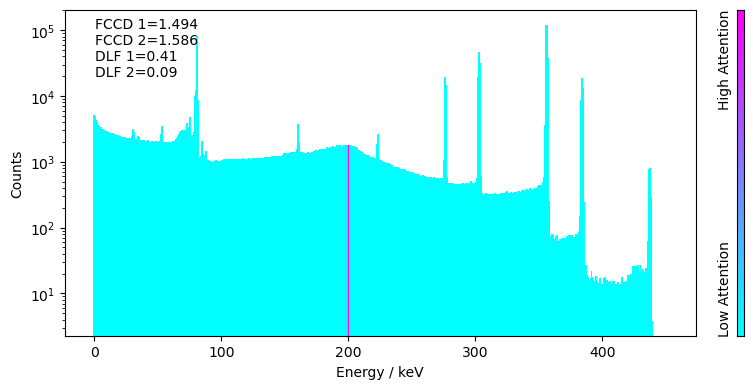

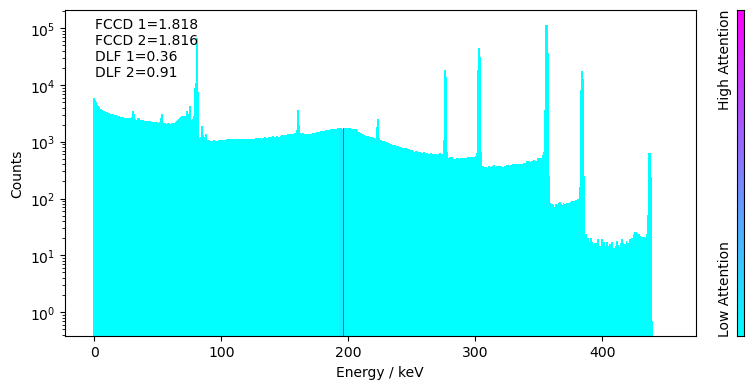

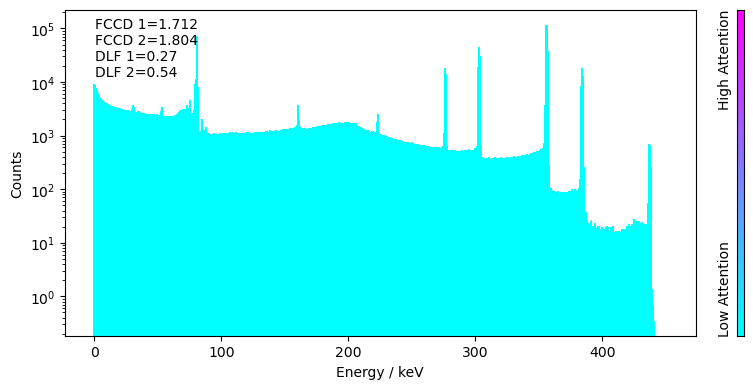

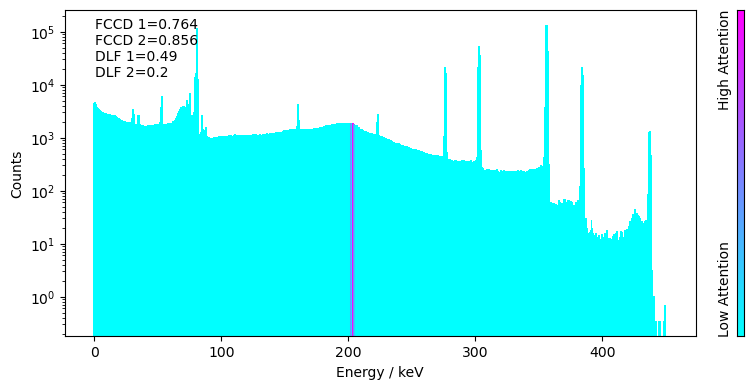

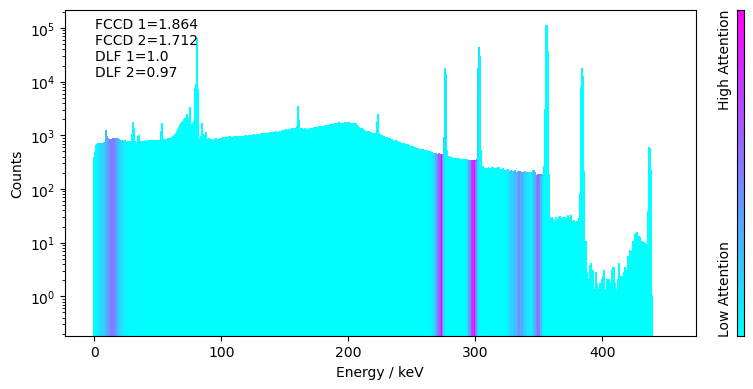

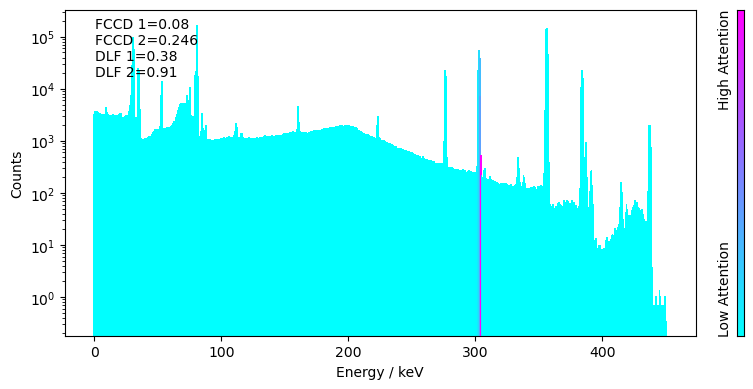

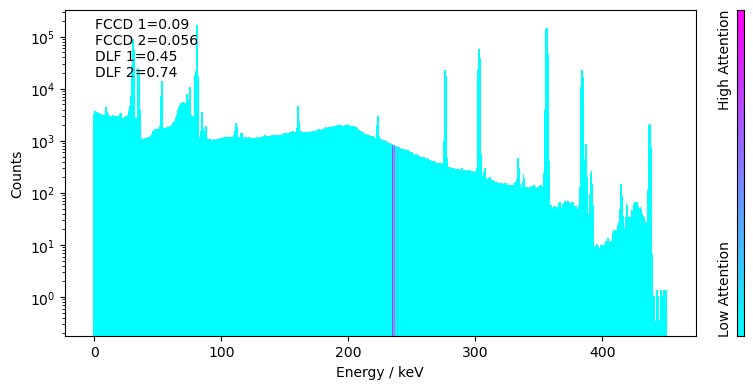

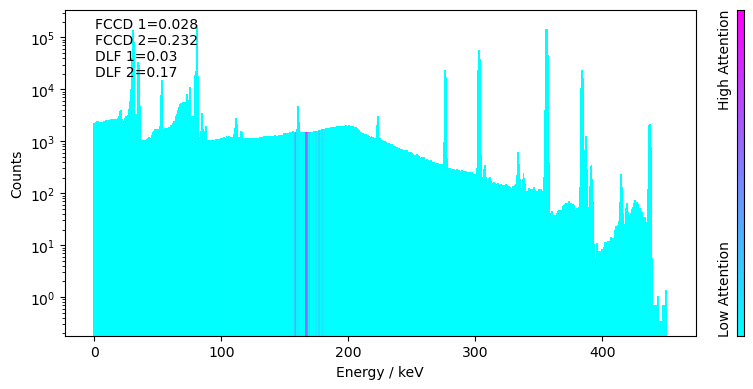

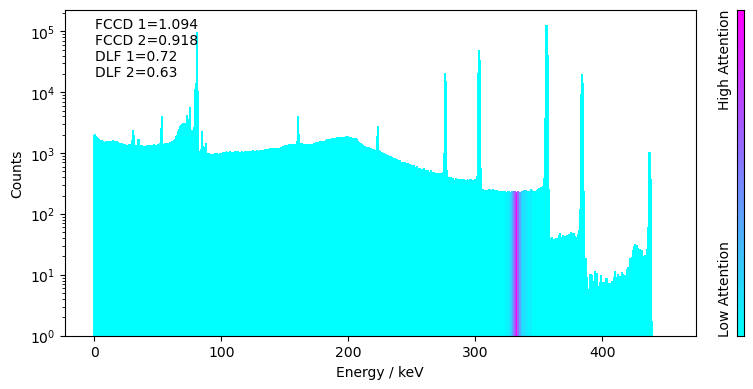

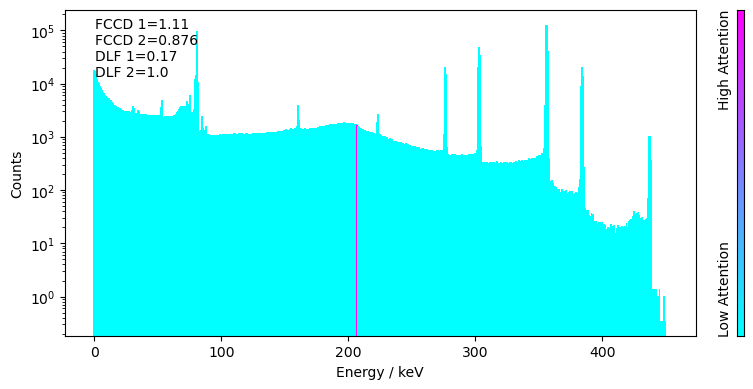

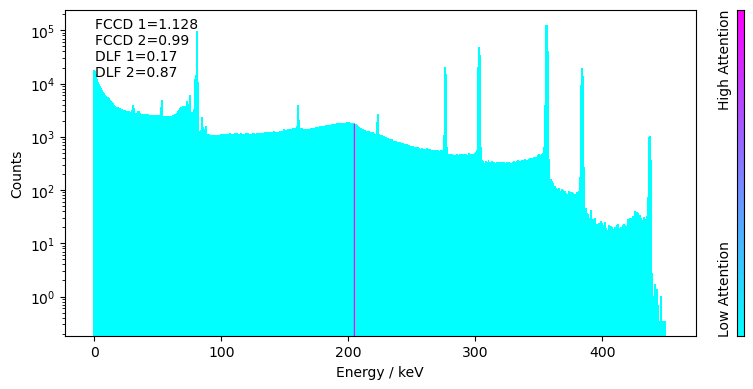

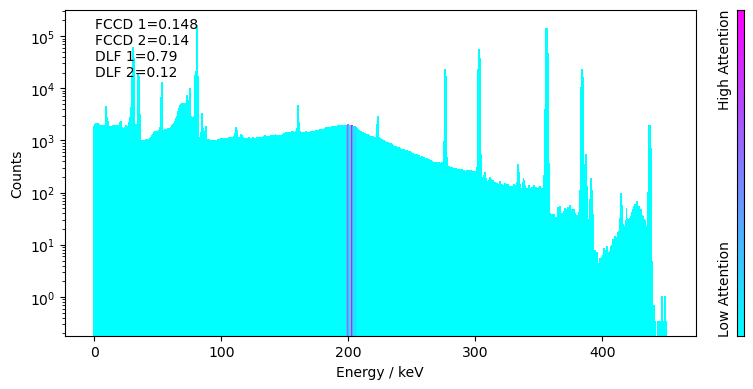

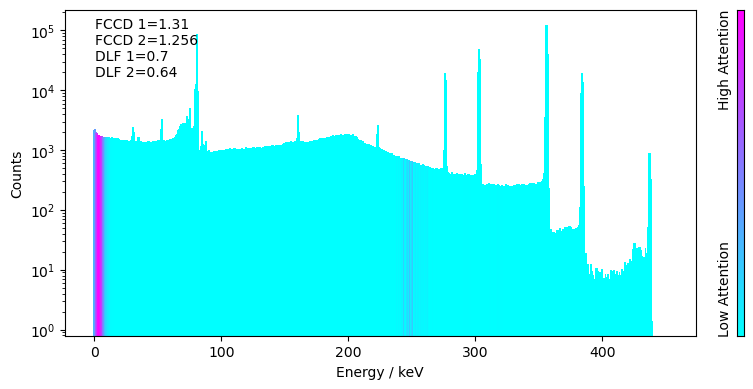

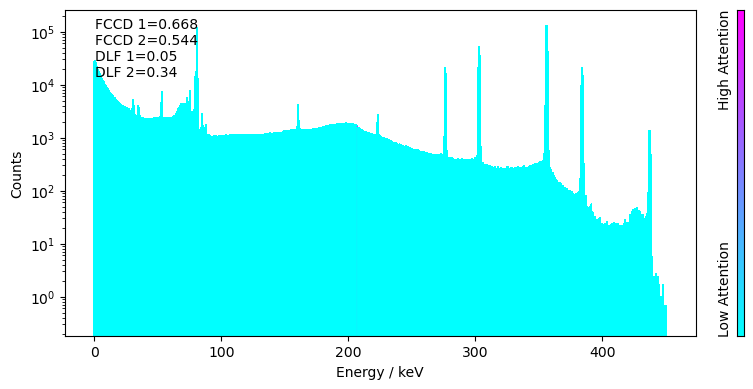

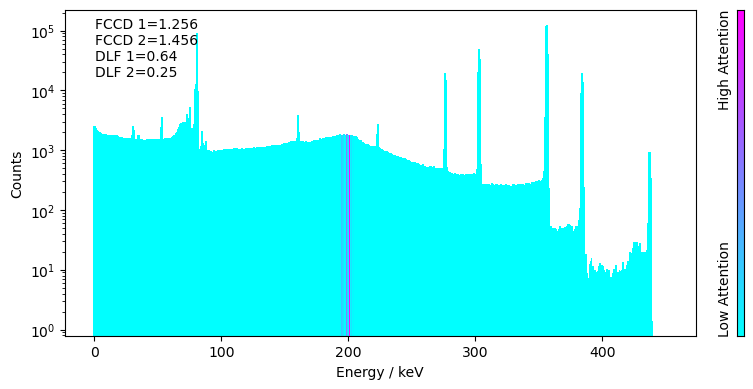

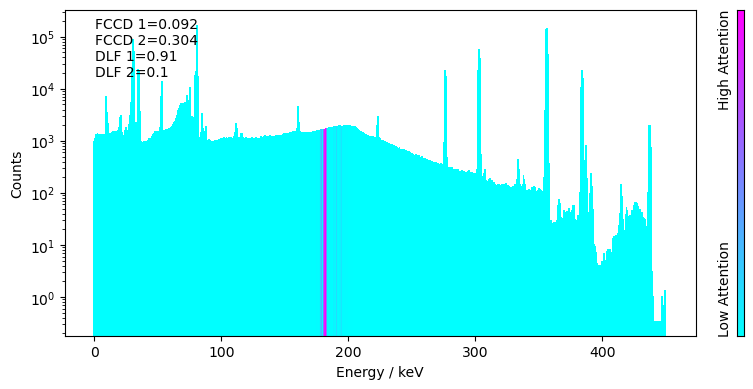

In [38]:
#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

# TRAINING 4: restircted dataset - Max FCCD diff = 0.25 mm AND Max DLF diff = 0.25

In [46]:
NUM_EPOCHS = 30 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
maxFCCDdiff = 0.25
maxDLFdiff = 0.25 
RNN_ID = "RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_maxDLFdiff"+str(maxDLFdiff)

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

In [47]:
#load dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict)

100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.95it/s]

(1000, 900)


## Training - DO NOT RERUN UNLESS NECESARRY

#params 2106114
Warmup Size: 400
- - - - - - - - - - -

EPOCH:  1 / 30
Training network...
Epoch [1/30], Iter [175/175] Loss: 0.4869
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.03it/s]


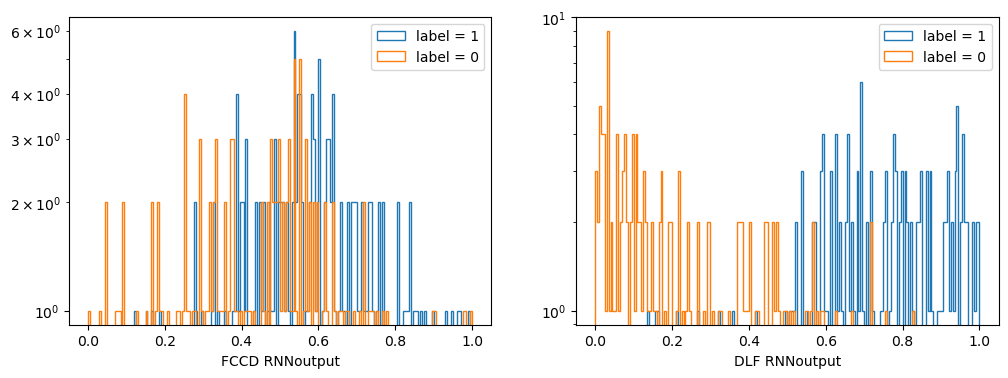

accuracy_FCCD:  0.6433333333333333
accuracy_DLF:  0.9166666666666666

EPOCH:  2 / 30
Training network...
Epoch [2/30], Iter [175/175] Loss: 0.5412
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.75it/s]


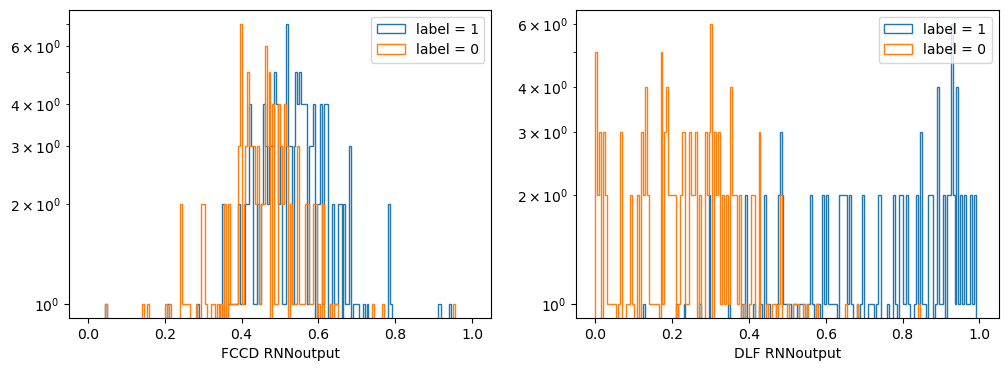

accuracy_FCCD:  0.6533333333333333
accuracy_DLF:  0.8766666666666667

EPOCH:  3 / 30
Training network...
Epoch [3/30], Iter [175/175] Loss: 0.4527
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.06it/s]


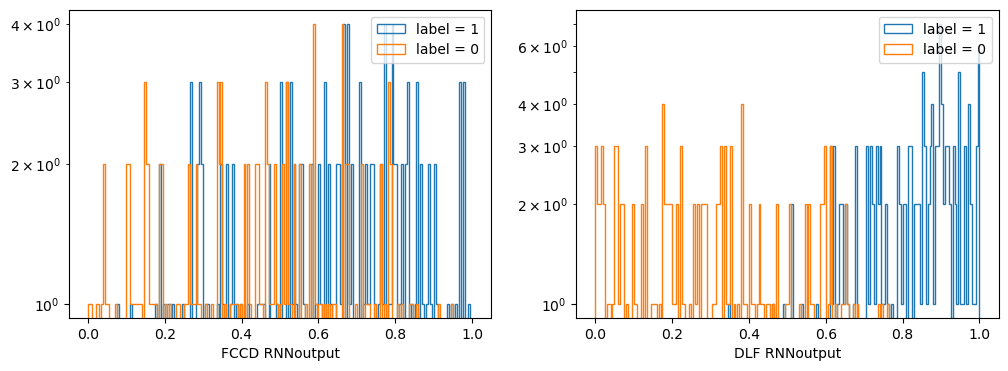

accuracy_FCCD:  0.67
accuracy_DLF:  0.8833333333333333

EPOCH:  4 / 30
Training network...
Epoch [4/30], Iter [175/175] Loss: 0.4541
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.59it/s]


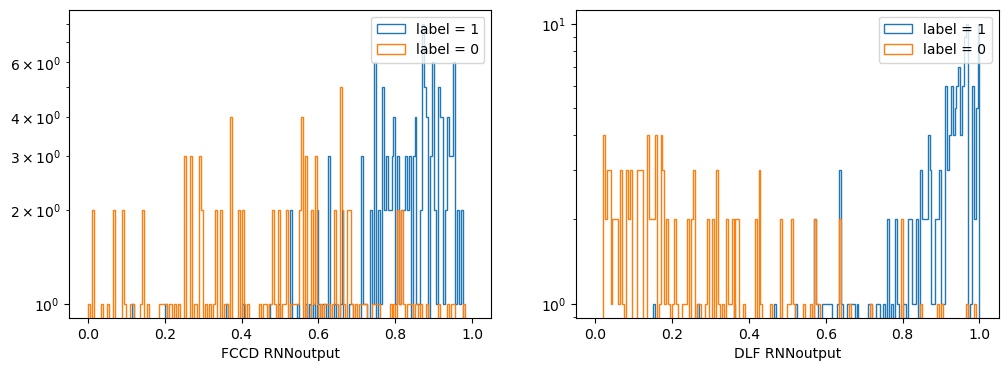

accuracy_FCCD:  0.73
accuracy_DLF:  0.9133333333333333

EPOCH:  5 / 30
Training network...
Epoch [5/30], Iter [175/175] Loss: 0.3069
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.71it/s]


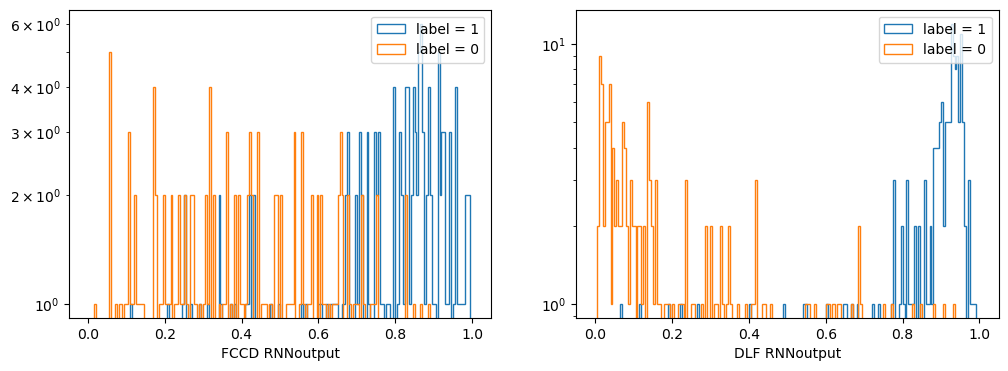

accuracy_FCCD:  0.75
accuracy_DLF:  0.9066666666666666

EPOCH:  6 / 30
Training network...
Epoch [6/30], Iter [175/175] Loss: 0.2105
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.91it/s]


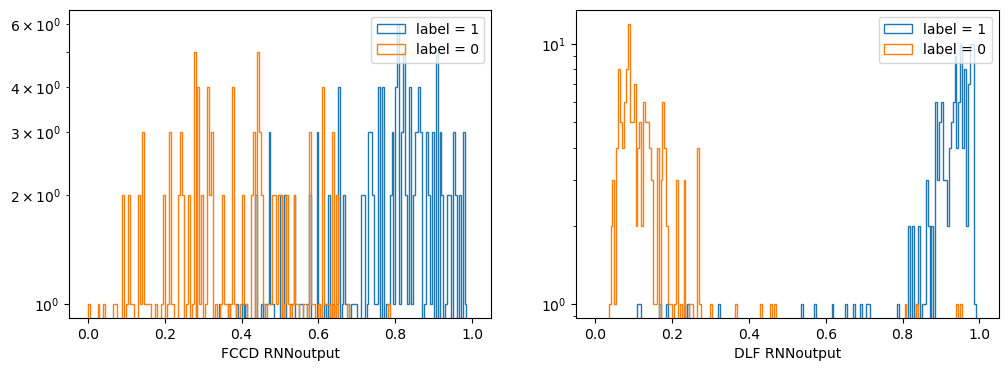

accuracy_FCCD:  0.8366666666666667
accuracy_DLF:  0.9633333333333334

EPOCH:  7 / 30
Training network...
Epoch [7/30], Iter [175/175] Loss: 0.2225
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.81it/s]


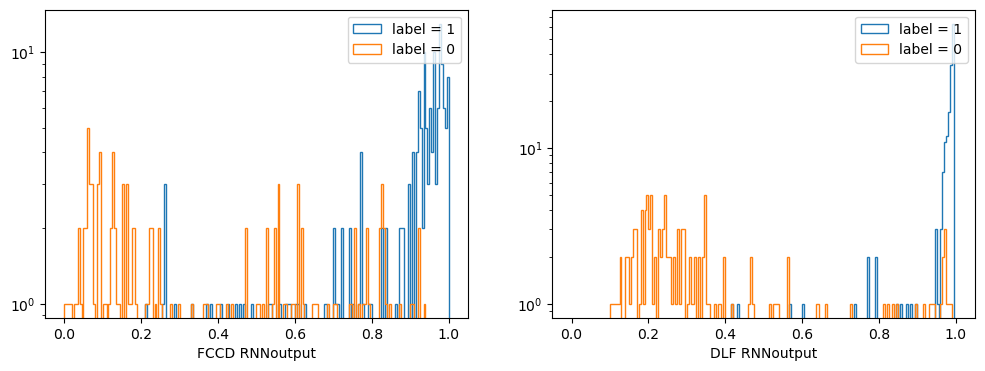

accuracy_FCCD:  0.7766666666666666
accuracy_DLF:  0.9

EPOCH:  8 / 30
Training network...
Epoch [8/30], Iter [175/175] Loss: 0.2210
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.54it/s]


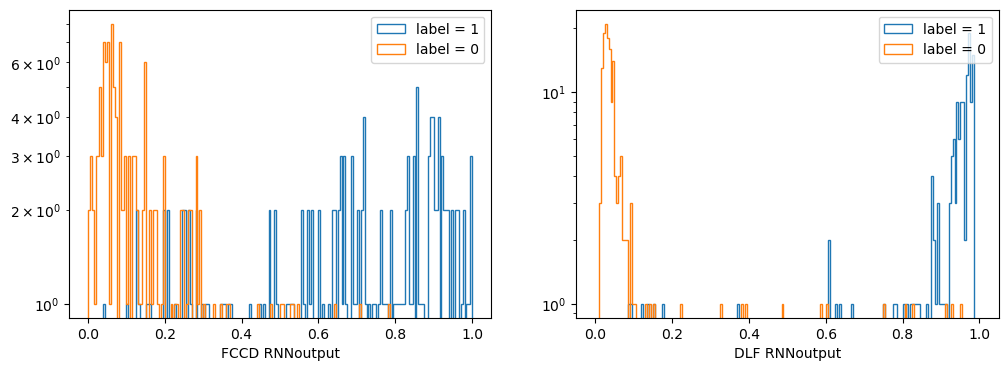

accuracy_FCCD:  0.8466666666666667
accuracy_DLF:  0.95

EPOCH:  9 / 30
Training network...
Epoch [9/30], Iter [175/175] Loss: 0.6991
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 12.03it/s]


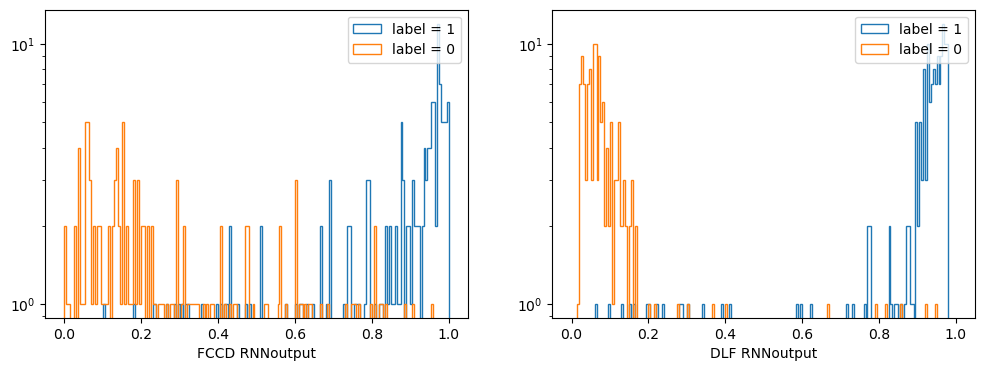

accuracy_FCCD:  0.8333333333333334
accuracy_DLF:  0.93

EPOCH:  10 / 30
Training network...
Epoch [10/30], Iter [175/175] Loss: 0.4844
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.88it/s]


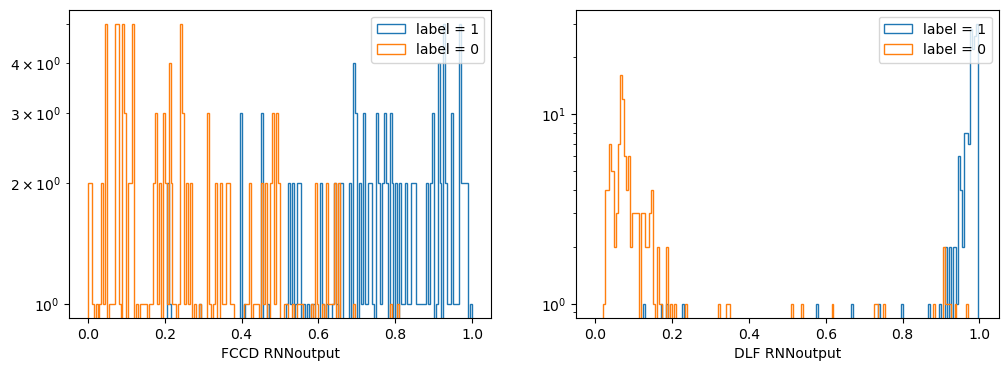

accuracy_FCCD:  0.8833333333333333
accuracy_DLF:  0.94

EPOCH:  11 / 30
Training network...
Epoch [11/30], Iter [175/175] Loss: 0.4757
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.94it/s]


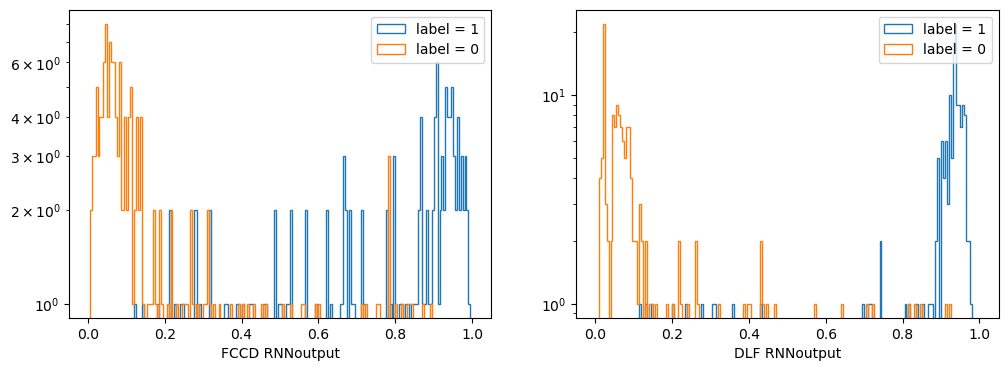

accuracy_FCCD:  0.8433333333333334
accuracy_DLF:  0.9366666666666666

EPOCH:  12 / 30
Training network...
Epoch [12/30], Iter [175/175] Loss: 0.9267
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 12.01it/s]


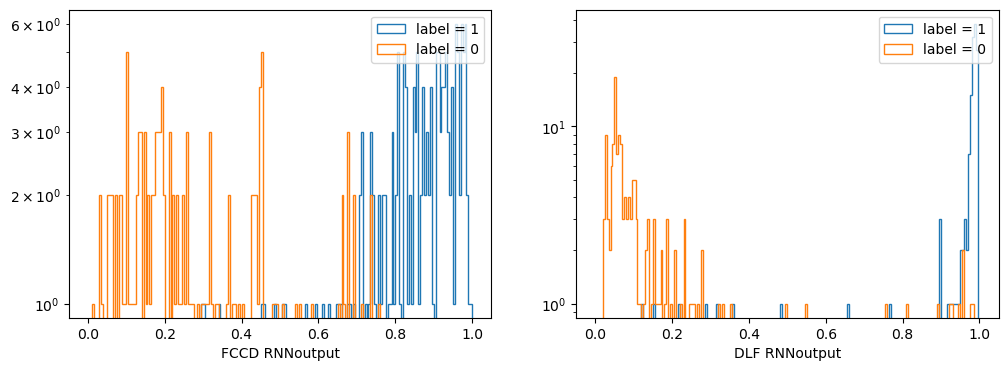

accuracy_FCCD:  0.9233333333333333
accuracy_DLF:  0.94

EPOCH:  13 / 30
Training network...
Epoch [13/30], Iter [175/175] Loss: 0.7031
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.39it/s]


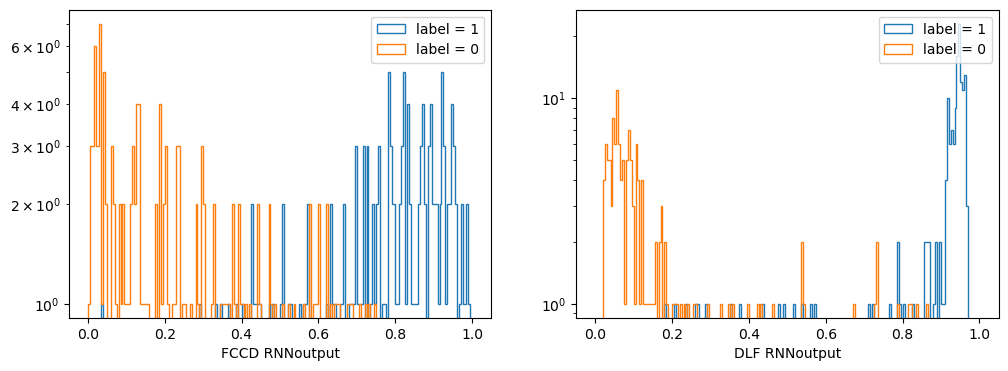

accuracy_FCCD:  0.87
accuracy_DLF:  0.9233333333333333

EPOCH:  14 / 30
Training network...
Epoch [14/30], Iter [175/175] Loss: 0.5500
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.25it/s]


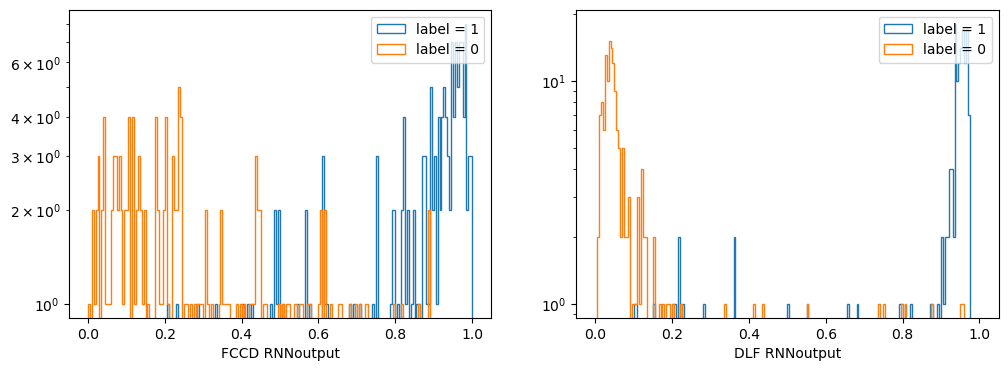

accuracy_FCCD:  0.8666666666666667
accuracy_DLF:  0.9366666666666666

EPOCH:  15 / 30
Training network...
Epoch [15/30], Iter [175/175] Loss: 0.4313
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.96it/s]


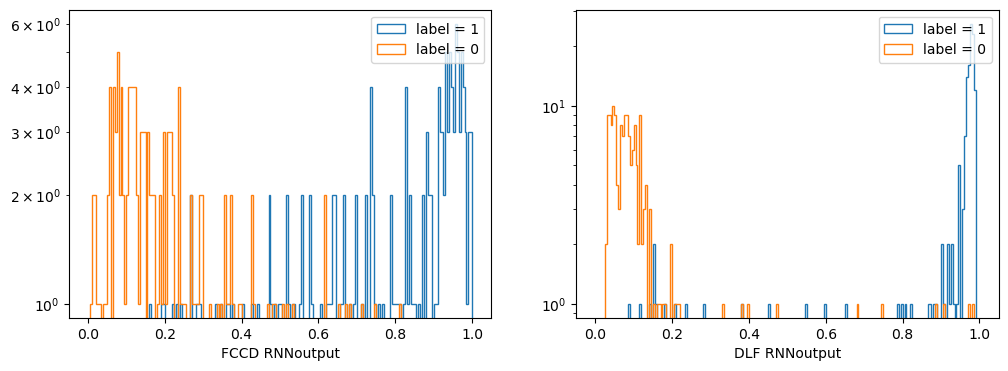

accuracy_FCCD:  0.8833333333333333
accuracy_DLF:  0.94

EPOCH:  16 / 30
Training network...
Epoch [16/30], Iter [175/175] Loss: 0.2630
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.59it/s]


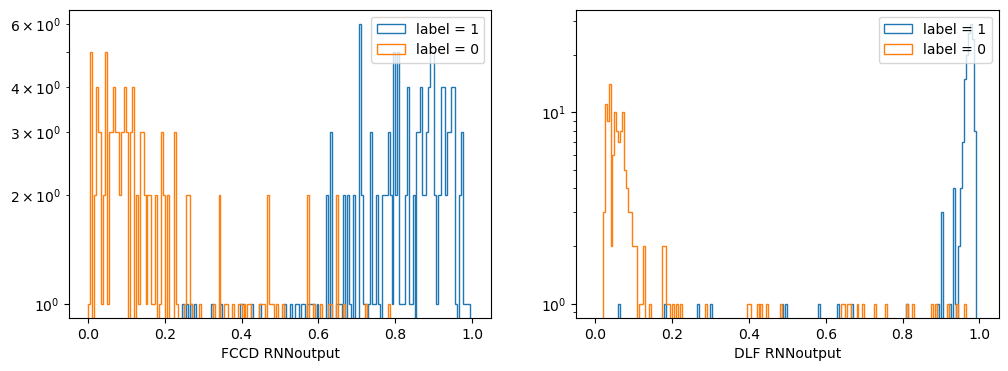

accuracy_FCCD:  0.9266666666666666
accuracy_DLF:  0.93

EPOCH:  17 / 30
Training network...
Epoch [17/30], Iter [175/175] Loss: 0.2978
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.22it/s]


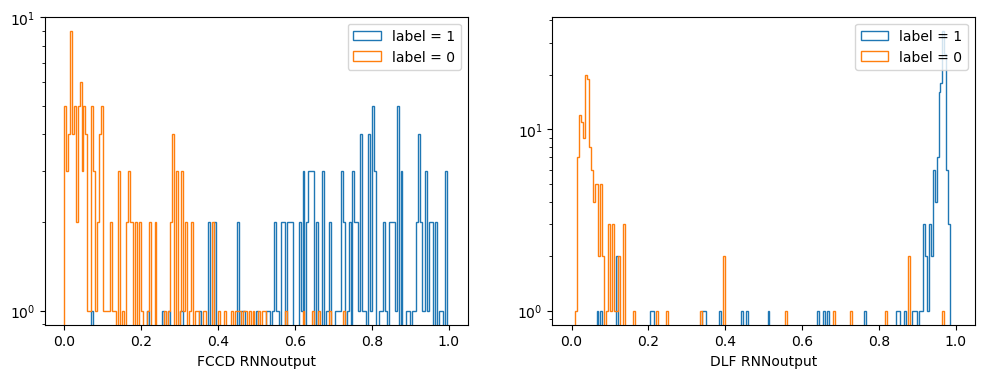

accuracy_FCCD:  0.92
accuracy_DLF:  0.94

EPOCH:  18 / 30
Training network...
Epoch [18/30], Iter [175/175] Loss: 0.1386
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.81it/s]


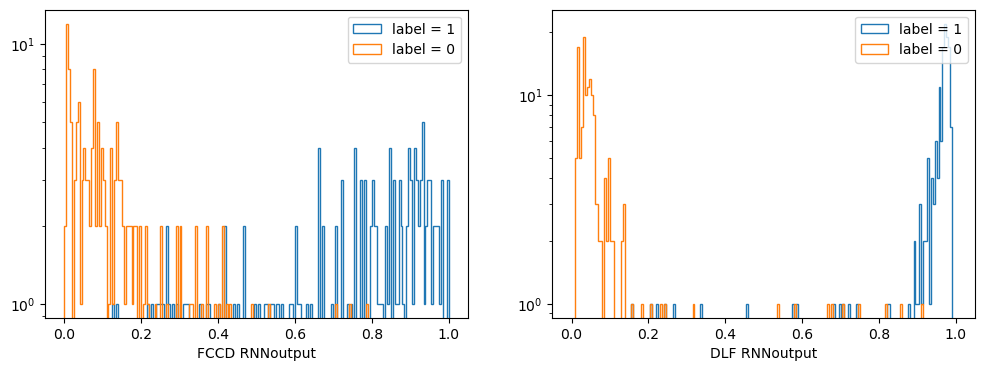

accuracy_FCCD:  0.8966666666666666
accuracy_DLF:  0.9466666666666667

EPOCH:  19 / 30
Training network...
Epoch [19/30], Iter [175/175] Loss: 0.1496
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.17it/s]


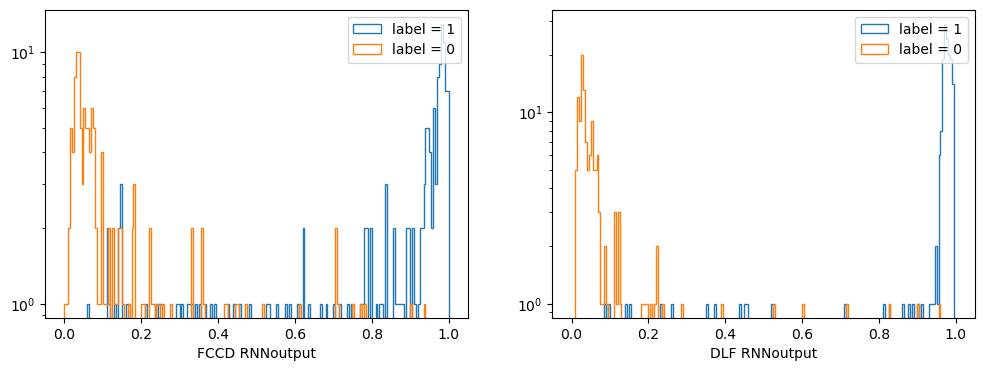

accuracy_FCCD:  0.8633333333333333
accuracy_DLF:  0.9433333333333334

EPOCH:  20 / 30
Training network...
Epoch [20/30], Iter [175/175] Loss: 0.1195
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.69it/s]


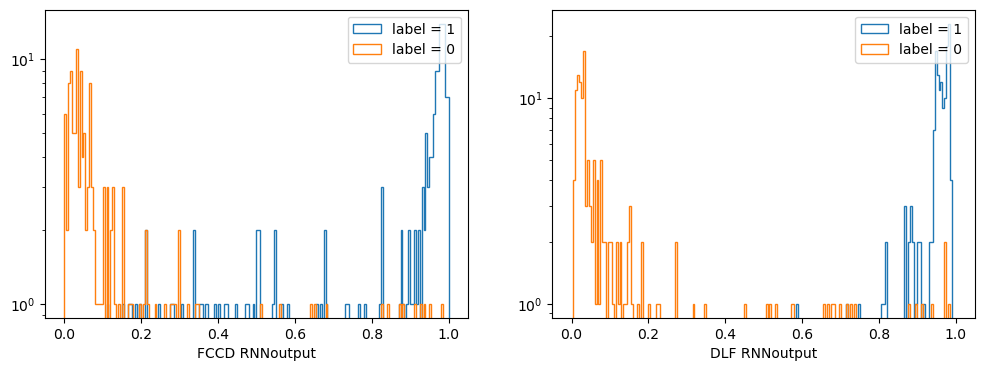

accuracy_FCCD:  0.8666666666666667
accuracy_DLF:  0.9333333333333333

EPOCH:  21 / 30
Training network...
Epoch [21/30], Iter [175/175] Loss: 0.2480
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.70it/s]


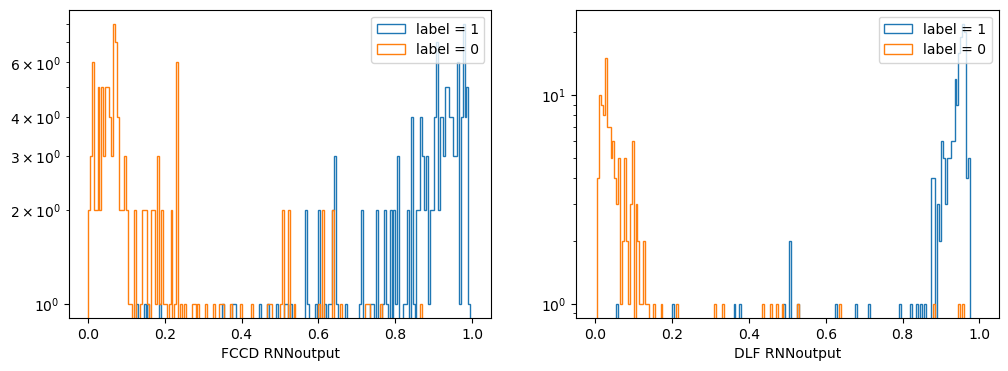

accuracy_FCCD:  0.91
accuracy_DLF:  0.9666666666666667

EPOCH:  22 / 30
Training network...
Epoch [22/30], Iter [175/175] Loss: 0.3783
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 12.21it/s]


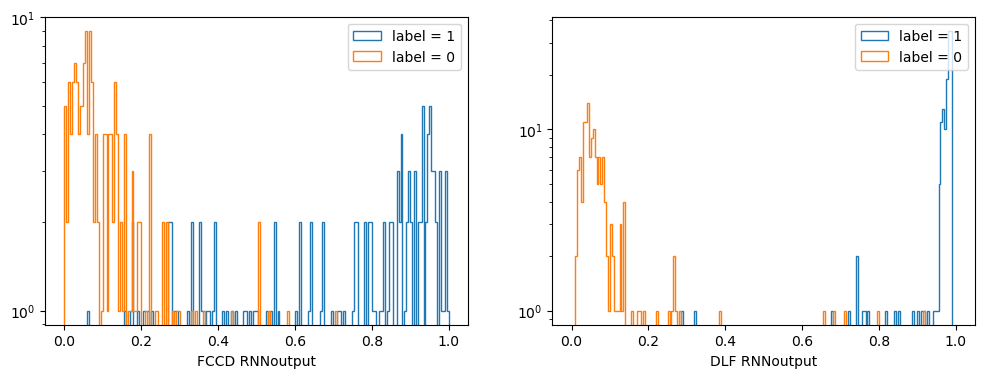

accuracy_FCCD:  0.86
accuracy_DLF:  0.9766666666666667

EPOCH:  23 / 30
Training network...
Epoch [23/30], Iter [175/175] Loss: 0.6251
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00,  9.90it/s]


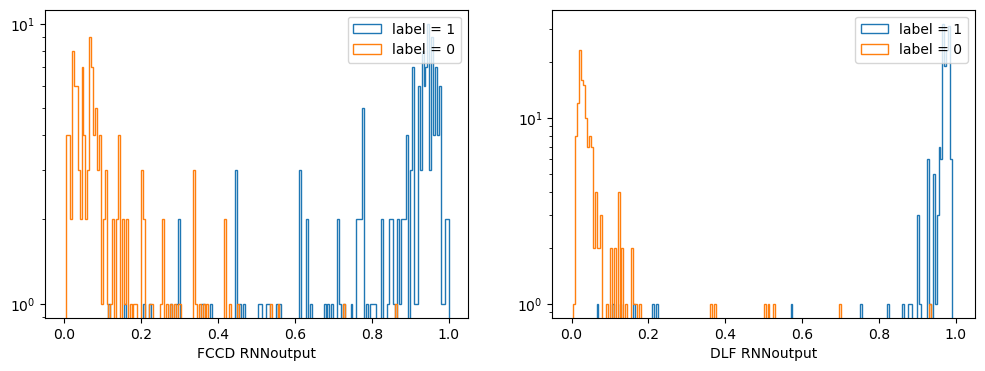

accuracy_FCCD:  0.9333333333333333
accuracy_DLF:  0.9633333333333334

EPOCH:  24 / 30
Training network...
Epoch [24/30], Iter [175/175] Loss: 0.3095
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.74it/s]


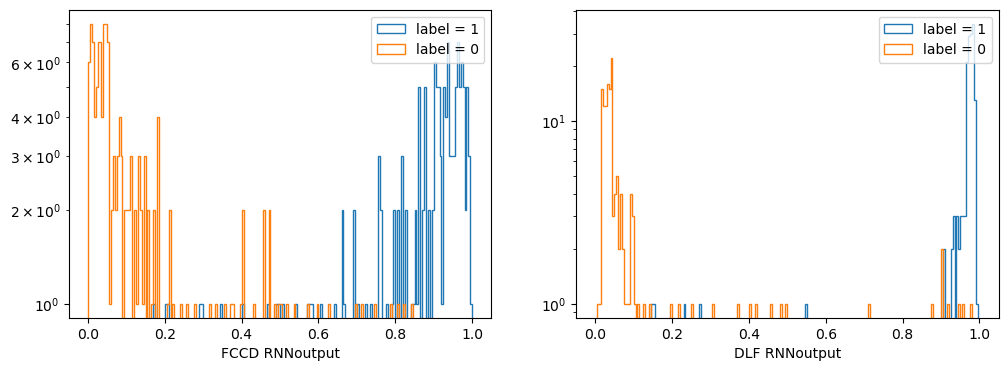

accuracy_FCCD:  0.9233333333333333
accuracy_DLF:  0.96

EPOCH:  25 / 30
Training network...
Epoch [25/30], Iter [175/175] Loss: 0.0503
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.14it/s]


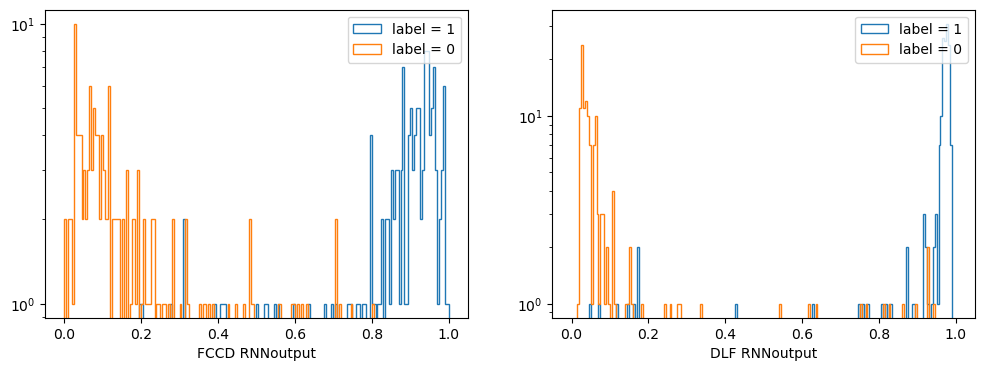

accuracy_FCCD:  0.93
accuracy_DLF:  0.9333333333333333

EPOCH:  26 / 30
Training network...
Epoch [26/30], Iter [175/175] Loss: 0.5862
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 12.12it/s]


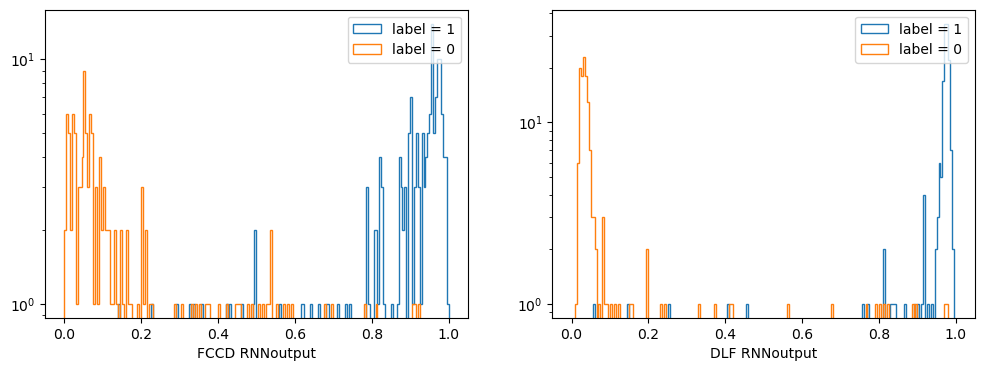

accuracy_FCCD:  0.9033333333333333
accuracy_DLF:  0.9466666666666667

EPOCH:  27 / 30
Training network...
Epoch [27/30], Iter [175/175] Loss: 0.1412
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.26it/s]


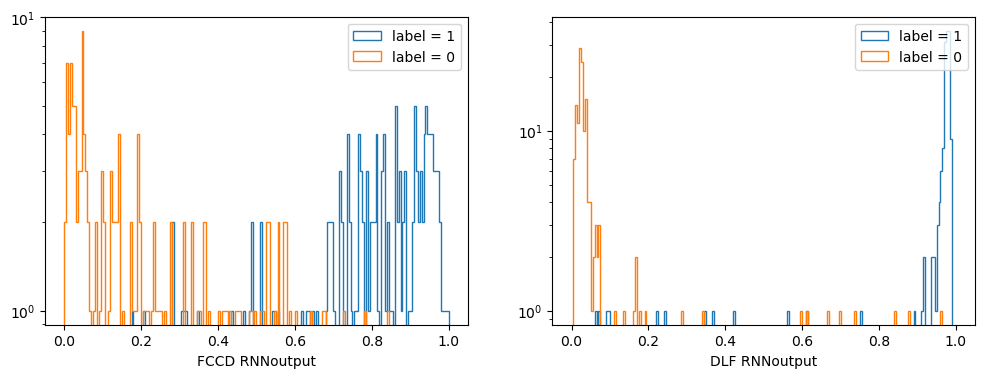

accuracy_FCCD:  0.8866666666666667
accuracy_DLF:  0.9433333333333334

EPOCH:  28 / 30
Training network...
Epoch [28/30], Iter [175/175] Loss: 0.0818
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.24it/s]


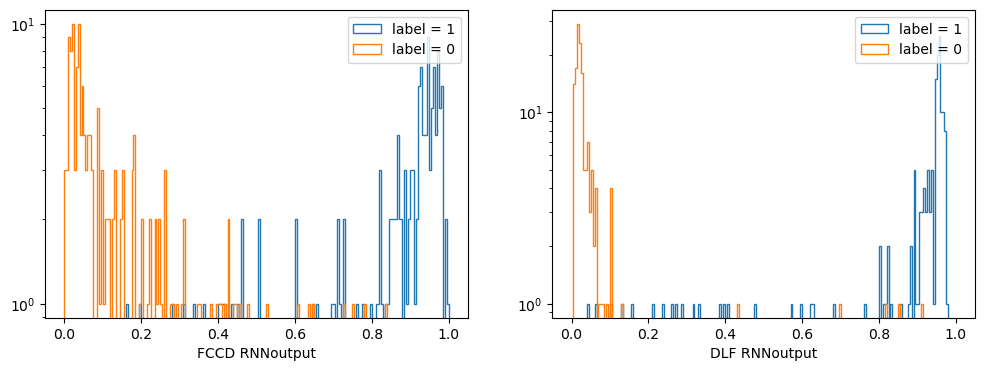

accuracy_FCCD:  0.9266666666666666
accuracy_DLF:  0.9333333333333333

EPOCH:  29 / 30
Training network...
Epoch [29/30], Iter [175/175] Loss: 0.7942
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.14it/s]


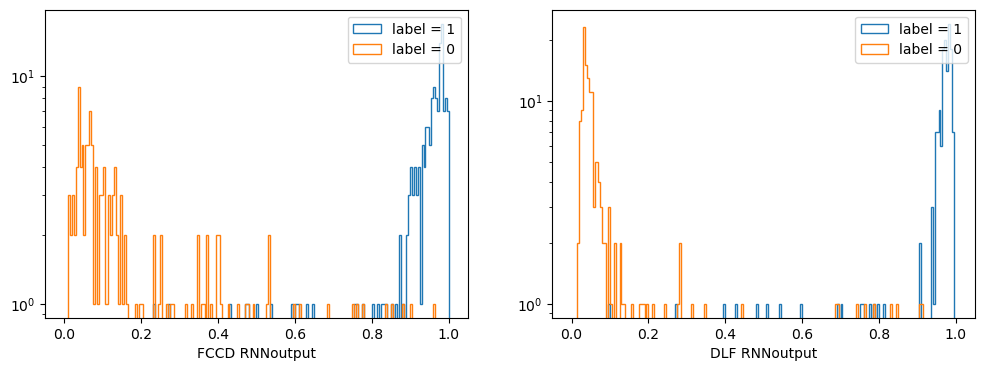

accuracy_FCCD:  0.9366666666666666
accuracy_DLF:  0.9533333333333334

EPOCH:  30 / 30
Training network...
Epoch [30/30], Iter [175/175] Loss: 0.4411
Testing/Validating...


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.31it/s]


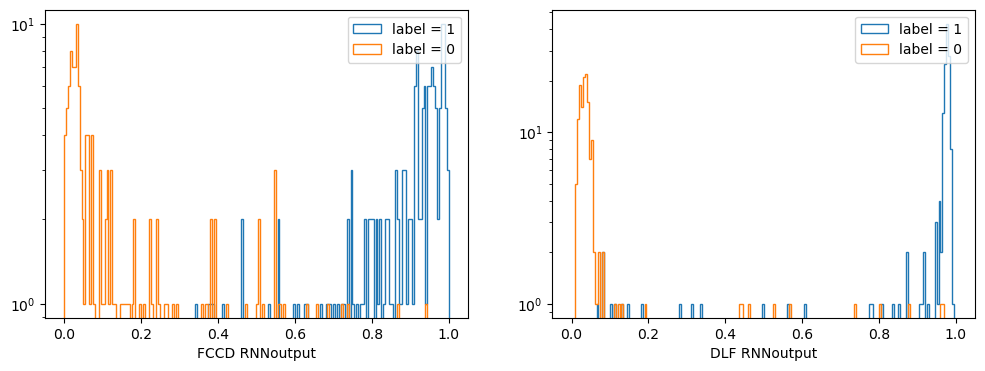

accuracy_FCCD:  0.92
accuracy_DLF:  0.9366666666666666

Training complete.

Saving RNN at /unix/legend/abi/ML_DL/saved_models/RNN_30epochs_LR0.005_maxFCCDdiff0.25mm_maxDLFdiff0.25/RNN_30epochs_LR0.005_maxFCCDdiff0.25mm_maxDLFdiff0.25.pkl


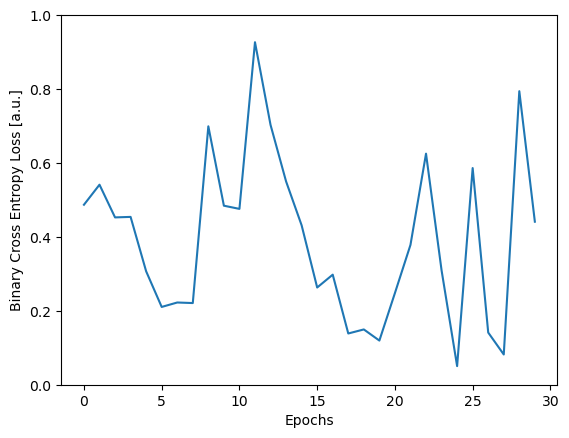

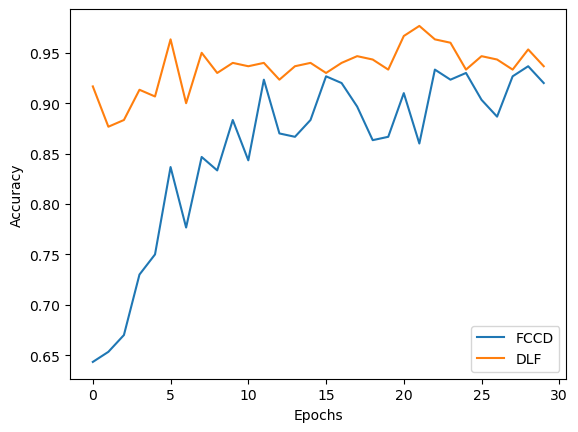

In [48]:
#Training - do not rerun if not necesarry
# torch.cuda.empty_cache()
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)

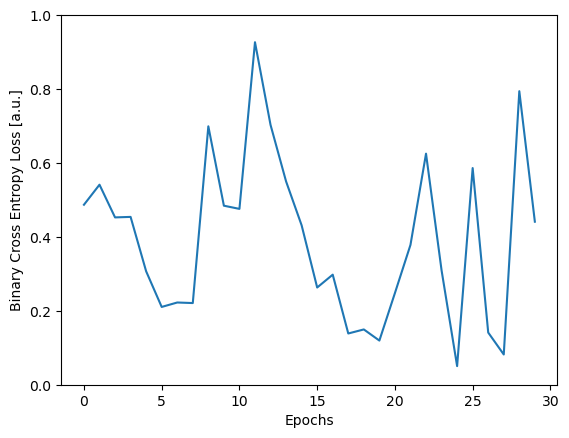

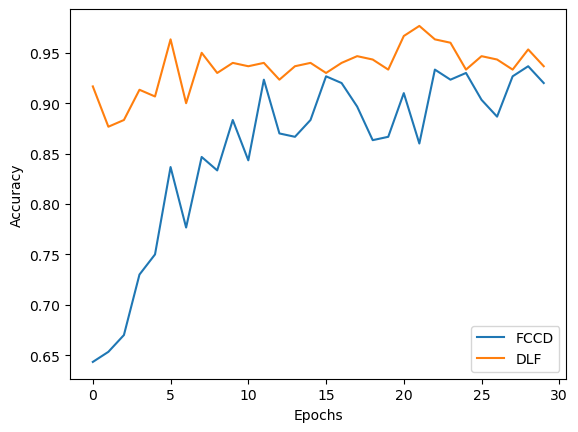

In [49]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing

In [50]:
# Load saved model
RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25 = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

 29%|█████████████████████                                                   | 22/75 [00:02<00:05, 10.44it/s]

DLF and FCCD misclassified for same trial:
j:  19 , i:  1
FCCD1:  0.536 , FCCD2:  0.674 , FCCD_diff:  -0.138 , RNNoutput:  0.80609536
DLF1:  0.4 , DLF2:  0.38 , DLF_diff:  0.020000000000000018 , RNNoutput:  0.09534854


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:08<00:00,  9.21it/s]


FCCD accuracies: 
total:  300
TP:  152
FP:  10
TN:  128
FN:  10
accuracy:  0.9333333333333333
precision:  0.9382716049382716
recall:  0.9382716049382716

DLF accuracies: 
total:  300
TP:  150
FP:  9
TN:  133
FN:  8
accuracy:  0.9433333333333334
precision:  0.9433962264150944
recall:  0.9493670886075949
Total # misclassified trials FCCD:  20  / 300
Total # misclassified trials DLF:  17  / 300


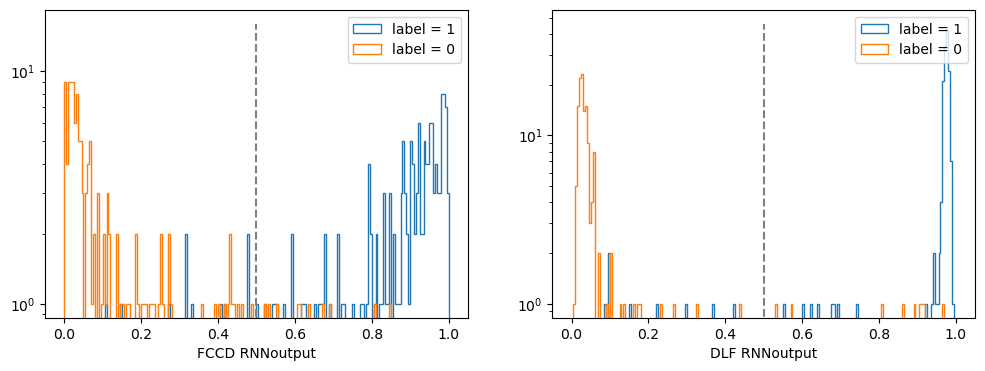

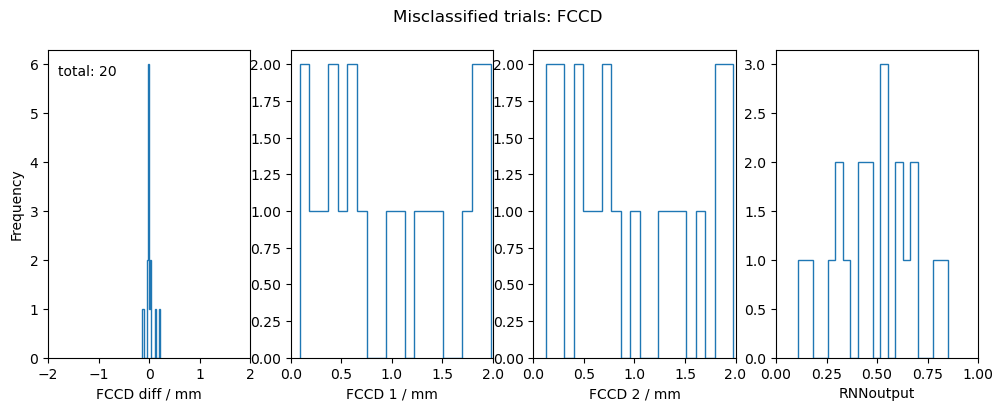

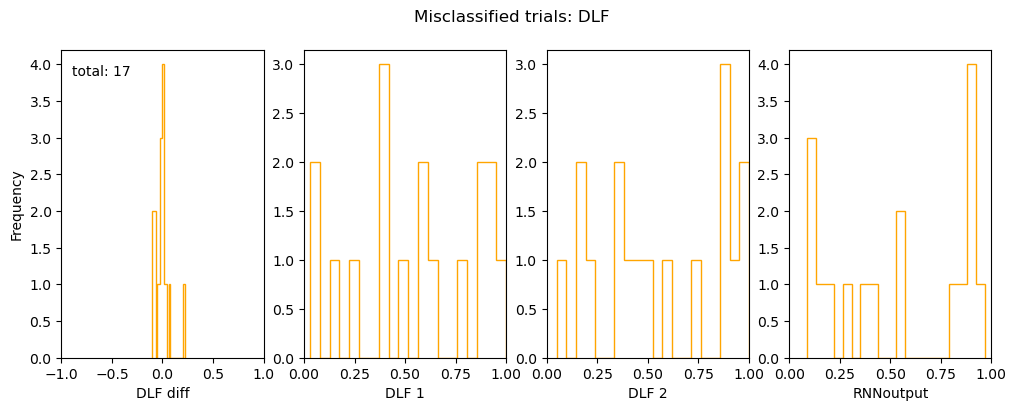

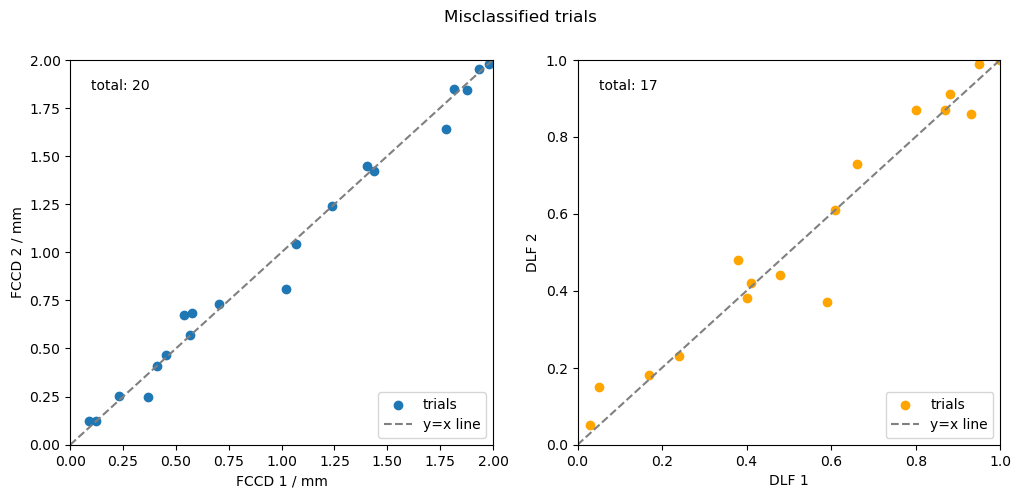

In [51]:
#testing
accuracies_maxFCCDdiff0_25mm_maxDLFdiff0_25 = test_RNN(RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


## Investigate Attention

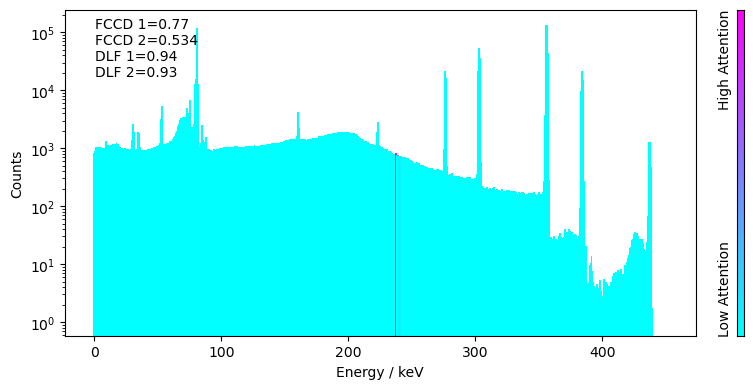

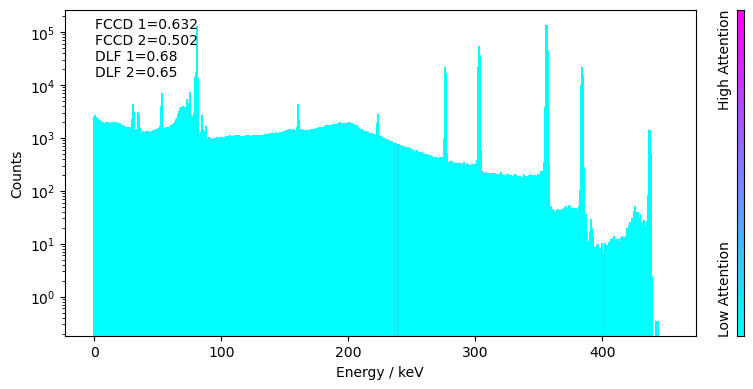

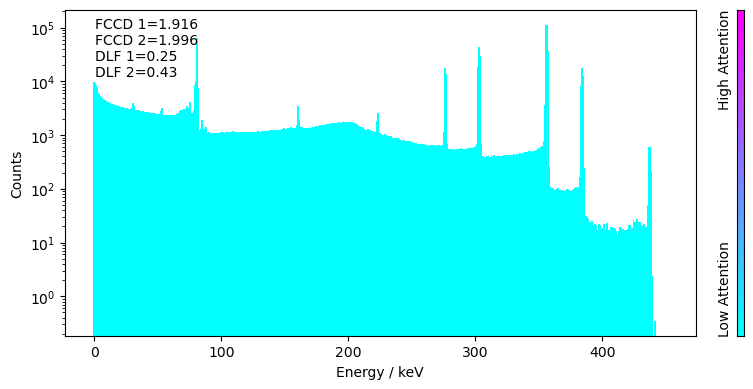

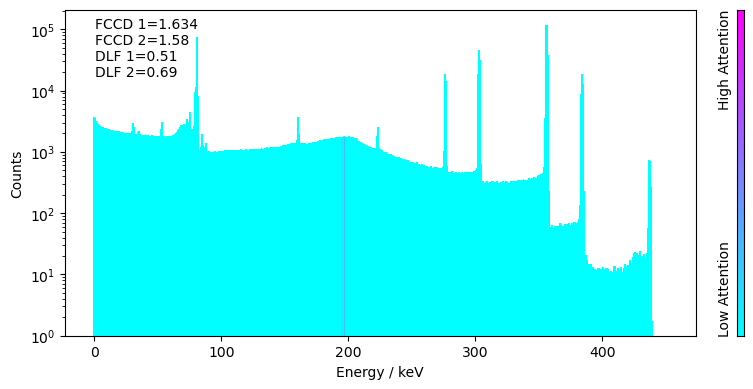

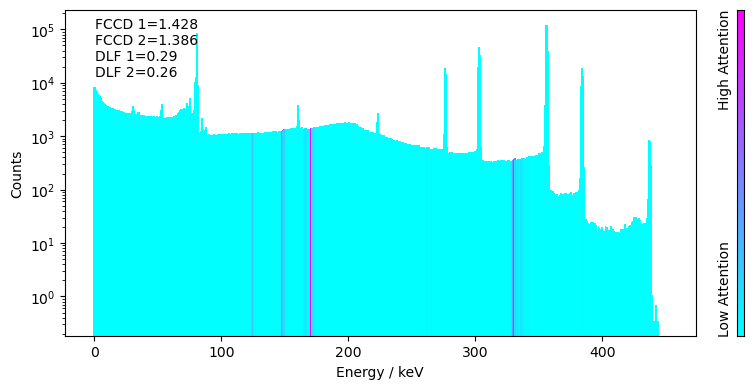

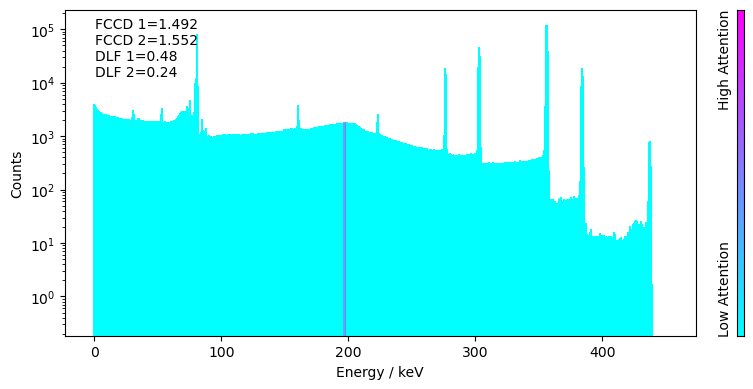

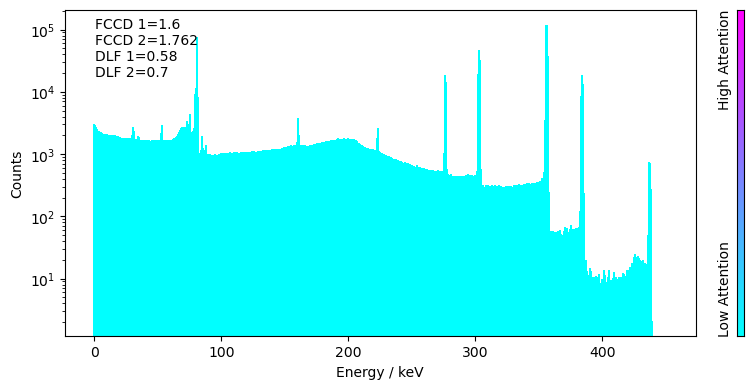

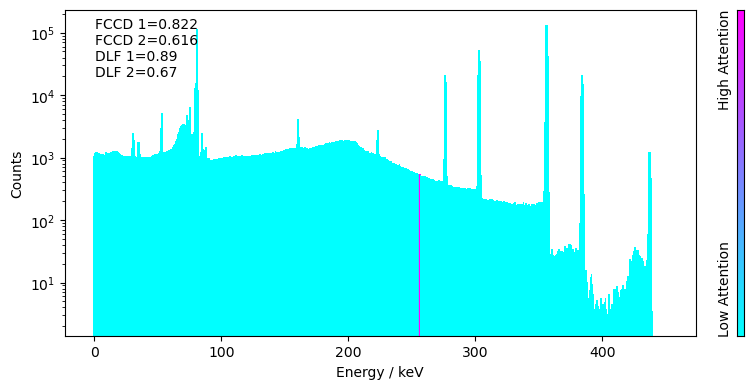

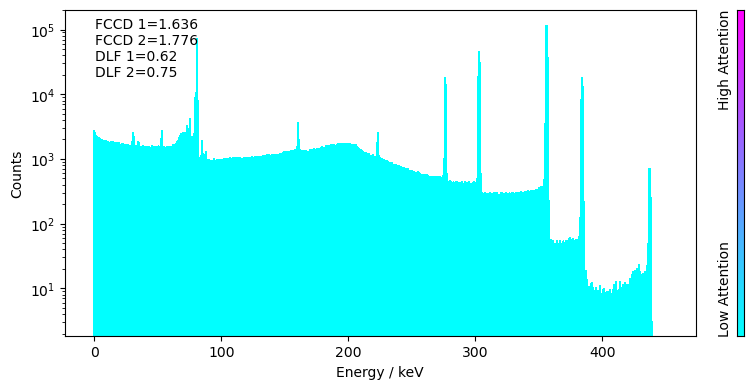

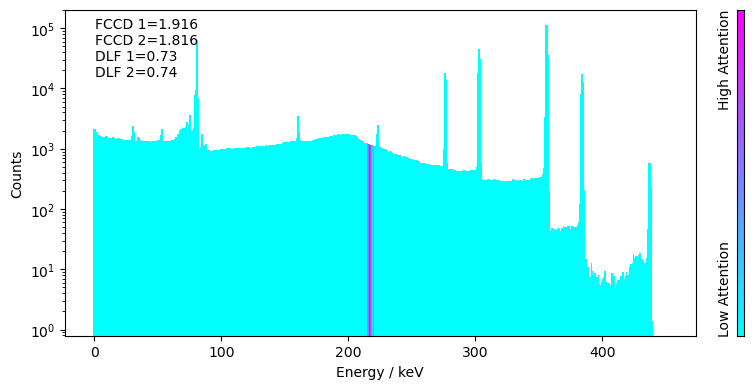

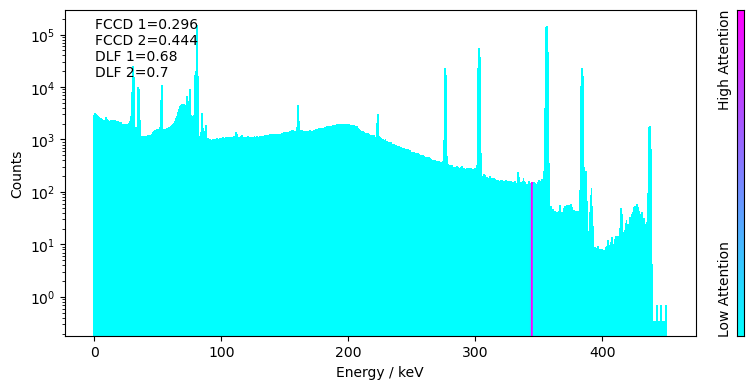

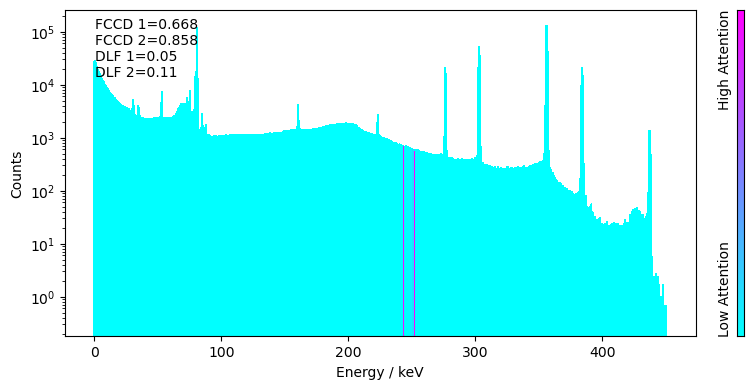

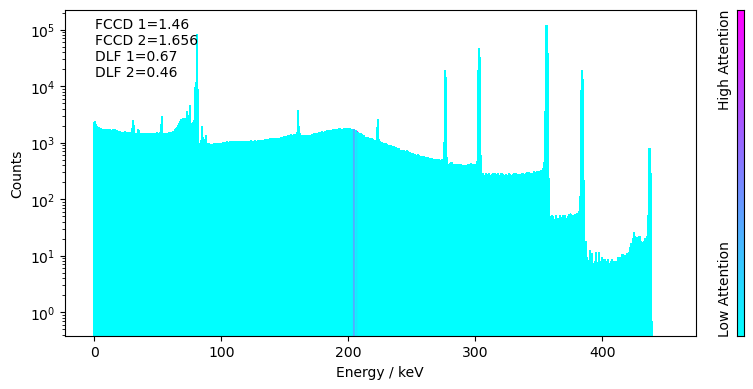

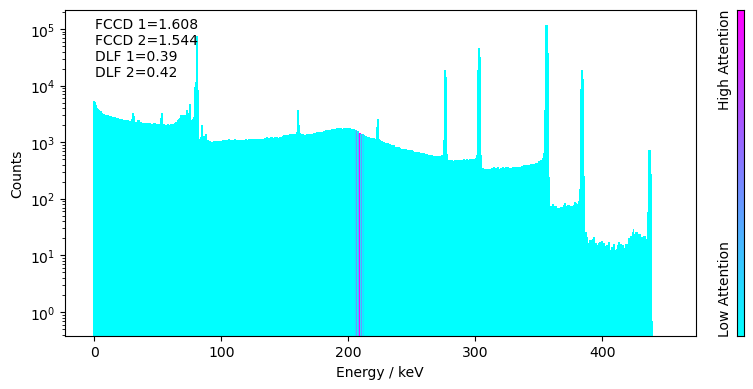

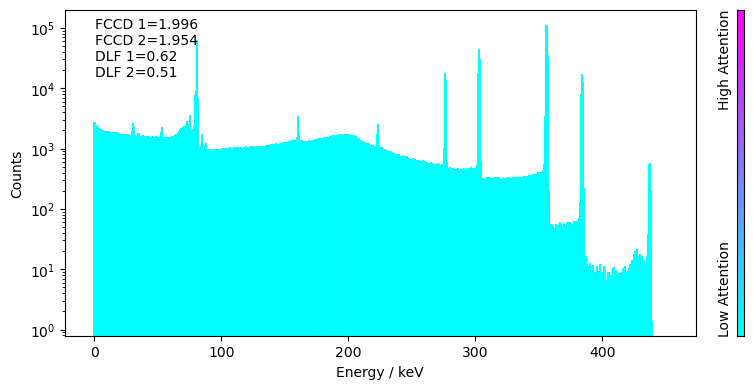

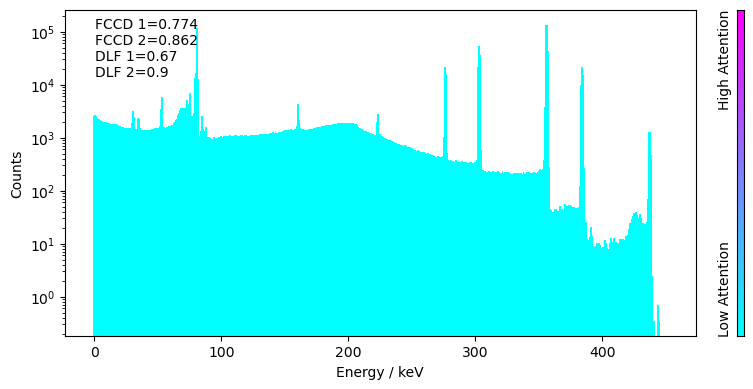

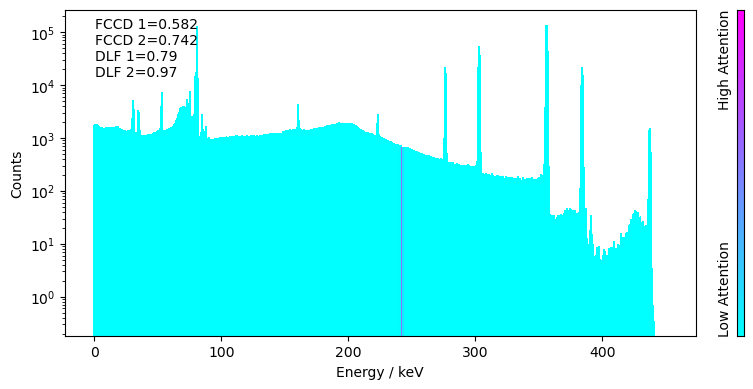

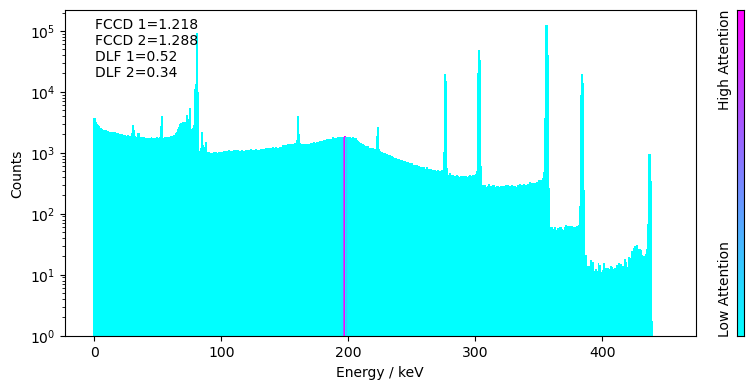

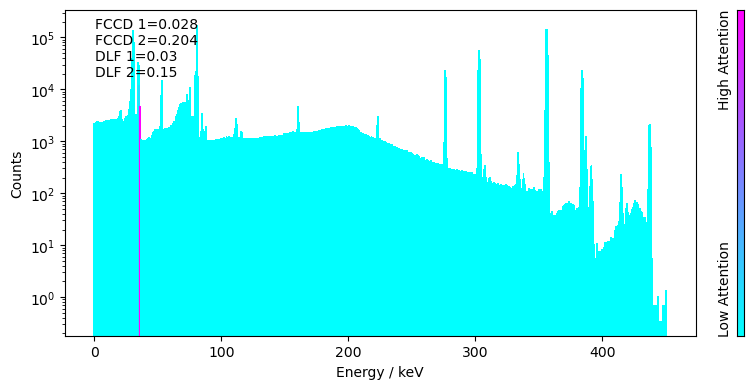

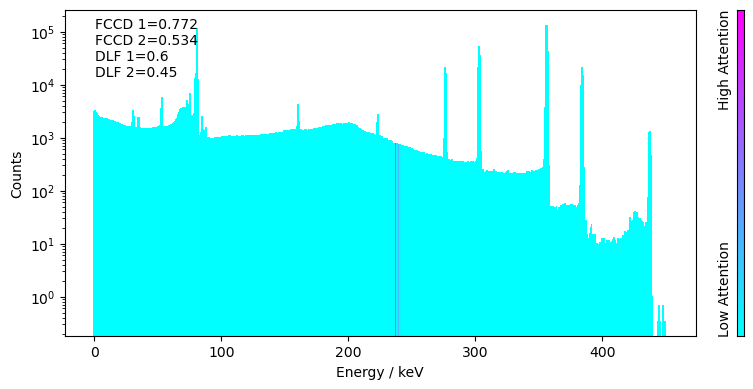

In [52]:
#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

### -----------------------------------------------------------
# Questions to ask:
- warm up attention mechanism
- why does loss value oscillate
- saving trained model -> how do you also save the train/test split/seed so that we dont test on data that was used for training
- how to decouple testing from training
- how to use attention mechanism:
    - create RNNinterprator with RNNinterpretor.get_attention = True?
    - should there be an attention score for DLF and FCCD?


In [ ]:

#     binwidth = 0.5 #keV
#     bins = np.arange(0,450+binwidth,binwidth)
#     bins_centres = np.delete(bins+binwidth/2,-1)